The following code requires these data exported as csv file: timestamps of each event, Tone active, Bar press  active in anymaze. Settup these data to be exported under "Protocol-Reports-Test data report" and export all the test data under "File-Export-Export test data" in Anymaze with filename format as \[Stage\]\_\[AnimalID\]\_\[ExperimentFileName\]. For more information please refer to anymaze's manual. 

In [90]:
%%capture
# %load_ext autoreload
# %autoreload 2

%matplotlib inline
import numpy as np
import pandas as pd
import os
import glob
import matplotlib
import matplotlib.pyplot as plt
from matplotlib.collections import PolyCollection
from matplotlib.colors import to_rgb
from matplotlib.colors import ListedColormap
from matplotlib.lines import Line2D
import matplotlib.cm as cm
import matplotlib.lines as mlines
import ntpath as nt
import re
import itertools as itt
import sys
import seaborn as sns
from scipy import stats
from scipy.stats import ttest_rel
from scipy.stats import ttest_ind
from scipy.stats import t
from itertools import combinations
from statsmodels.stats.anova import AnovaRM
from statsmodels.sandbox.stats.multicomp import multipletests
from statsmodels.formula.api import mixedlm
from statsmodels.regression.mixed_linear_model import MixedLM
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans, SpectralClustering, AffinityPropagation, AgglomerativeClustering, DBSCAN, MeanShift
from sklearn.mixture import GaussianMixture
from sklearn.metrics import silhouette_score, silhouette_samples
from sklearn.metrics import calinski_harabasz_score
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
import pingouin as pg
from math import sqrt, pi
from sklearn.manifold import TSNE



#Put file directory here
base_dir = os.path.abspath('/scratch/09117/xz6783/minian/Behavior_Files/')



In [2]:
import matplotlib as mpl
plt.rcParams['font.family'] = 'Liberation Sans'
plt.rcParams['pdf.fonttype'] = 42
plt.rcParams['text.color'] = 'k'

In [3]:
def load_behavior_csv(base_dir, filename_prefix):
    """
    Reads behavior CSV files from a given directory, extracts animal IDs from filenames,
    and stores the contents in a dictionary keyed by these IDs.

    :param base_dir: The base directory where the files are located.
    :param filename_prefix: The prefix pattern to identify relevant CSV files.
    :return: A dictionary with animal IDs as keys and lists of DataFrames as values.
    """
    
    # Get a list of all files in the base directory and directly construct the full file paths for the relevant CSV files
    file_paths = [os.path.join(base_dir, file) for file in os.listdir(base_dir)
                      if file.startswith(filename_prefix) and file.endswith(".csv")]

    # Dictionary to hold the CSV contents, keyed by animal IDs
    animal_data = {}

    for file_path in file_paths:
        # Extract the filename from the path
        filename = os.path.basename(file_path)
        
        # Extract the animal ID from the filename
        parts = filename.split('_')
        if len(parts) > 2:
            animal_id = parts[1]  # Animal ID is between the first and second underscore

            # Read the CSV file
            df = pd.read_csv(file_path)

            # Add the DataFrame to the animal_data dictionary
            if animal_id not in animal_data:
                animal_data[animal_id] = [df]  # Initialize with a list containing the DataFrame
            else:
                animal_data[animal_id].append(df)  # Append the DataFrame to the existing list
        else:
            print(f"Filename format error: {filename}")

    return animal_data

# Example usage
# base_dir = 'path/to/directory'
# filename_prefix = 'Day 2 - Cat Odor Conflict'
# behavior_data = load_behavior_csv(base_dir, filename_prefix)


In [4]:
cue_length = 15
num_hungry_cues = 12
num_satiated_cues = 12

def process_cues(a):
    cue_changes = np.diff(a['Tone active'].values)
    cue_start_indices = np.where(cue_changes > 0)[0]+1
    cue_end_indices = np.where(cue_changes < 0)[0]
    return cue_start_indices, cue_end_indices


def calculate_latency(a, cue_start_indices, cue_end_indices, cue_length):
    time = a['Time (s)'].values
    bar_press_indices = np.where(np.diff(a['Bar Press active'].values) > 0)[0]+1
    latencies = []
    rewarded = []

    for start_idx, end_idx in zip(cue_start_indices, cue_end_indices):
        # Find bar presses that occurred after the cue start and before cue end
        valid_bar_presses = bar_press_indices[(bar_press_indices >= start_idx) & (bar_press_indices <= end_idx)]

        if valid_bar_presses.size > 0:
            # First bar press time minus cue start time
            latency = time[valid_bar_presses[0]] - time[start_idx]
            reward = True
        else:
            # Default latency if no bar press during the cue
            latency = cue_length
            reward = False

        latencies.append(latency)
        rewarded.append(reward)

    return latencies,rewarded

def calculate_continuous_average(a, column, cue_start_indices, cue_end_indices, cue_length):
    time = a['Time (s)'].values
    continuous_data = a[column].values
    cue_average = []
    cue_average_1s = []
    
    for start_idx, end_idx in zip(cue_start_indices, cue_end_indices):
        average = np.mean(continuous_data[start_idx:end_idx])
        diff = time - time[start_idx] - 1
        onesecondaftercue_index = list(diff).index(min(diff[diff>0]))
        average_1s = np.mean(continuous_data[start_idx:onesecondaftercue_index])

        cue_average.append(average)
        cue_average_1s.append(average_1s)

    return cue_average, cue_average_1s

def calculate_duration_cue(a, column, cue_start_indices, cue_length):
    # Extracting the time values from the DataFrame
    time = a['Time (s)'].values

    # Identifying indices where the animal is in the specified area
    area = np.where(a[column].values > 0)[0]

    # Finding indices where the animal enters (area_start) and exits (area_end) the area
    area_start = np.where(np.diff(a[column].values, prepend=0, append=0) > 0)[0]
    area_end = np.where(np.diff(a[column].values, prepend=0, append=0) < 0)[0]

    # Initializing an array to store the duration of time spent in the area for each cue
    area_durations = []

    for start_idx in cue_start_indices:
        # Calculating the end of the cue window based on cue length
        cue_window_end = start_idx + np.where(time[start_idx:] >= time[start_idx] + cue_length)[0][0]
        
        # Difference between all area indices and the current cue start index
        diff = area - start_idx
        duration = 0

        # Process each cue start index
        if len(diff[diff >= 0]) == 0:
            # No entry into the area after the cue start
            duration = 0
        elif area[list(diff).index(min(diff[diff >= 0]))] > cue_window_end:
            # The first entry into the area occurs after the cue window end
            duration = 0
        else:
            # Identifying the first area entry index after the cue start
            area_start_index = area[list(diff).index(min(diff[diff >= 0]))]
            
            # Finding all subsequent area entry indices within the cue window
            area_index_within = area_start[(area_start > area_start_index) & (area_start <= cue_window_end)]
            area_start_index = np.append(area_start_index, area_index_within)

            # Calculating the total duration in the area within the cue window
            for i in range(len(area_start_index)):
                # Finding the nearest area exit index for each entry
                area_end_index = area_end[area_end > area_start_index[i]].min()
                
                # Adjusting the exit index if it exceeds the cue window end
                if area_end_index > cue_window_end:
                    area_end_index = cue_window_end

                # Adding the period of presence in the area to the total duration
                period = time[area_end_index] - time[area_start_index[i]]
                duration += period

        # Convert the total duration to a percentage of the cue length
        percentage_duration = min(100, (duration / cue_length) * 100)
        area_durations.append(percentage_duration)

    return np.array(area_durations)

def calculate_duration(a, column, phase_time):
    time = a['Time (s)'].values
    area = np.where(a[column].values > 0)[0]
    area_start = np.where(np.diff(a[column].values, prepend=0, append=0) > 0)[0]
    area_end = np.where(np.diff(a[column].values, prepend=0, append=0) < 0)[0]

    start_idx = np.searchsorted(time, phase_time[0], side='left')
    end_idx = min(np.searchsorted(time, phase_time[1], side='right'), len(time)-1)

    # Convert to percentage of the total phase time
    phase_duration = time[end_idx] - time[start_idx]
    duration = 0
    diff = area - start_idx

    if len(diff[diff >= 0]) == 0:
        # No entry into the area after the phase start
        duration = 0
    elif area[list(diff).index(min(diff[diff >= 0]))] > end_idx:
        # The first entry into the area occurs after the phase end
        duration = 0
    else:
        # Identifying the first area entry index after the phase start
        area_start_index = area[list(diff).index(min(diff[diff >= 0]))]
        if (a[column].values[start_idx] > 0) & (len(area_end[(area_end >= start_idx) & (area_end <= end_idx)])==0):
            duration = phase_duration
        else:
            # Finding all subsequent area entry indices within the cue window
            area_index_within = area_start[(area_start > area_start_index) & (area_start <= end_idx)]
            area_start_index = np.append(area_start_index, area_index_within)
            
            # Calculating the total duration in the area within the phase
            for i in range(len(area_start_index)):
                    # Use the next area end or the phase end, whichever comes first
                    area_end_candidates = [idx for idx in area_end if idx > area_start_index[i]]
                    if area_end_candidates:
                        area_end_idx = min(area_end_candidates[0], end_idx)
                    else:
                        area_end_idx = end_idx

                    # Calculate the duration for this segment, ensuring indices are within bounds
                    area_end_idx = min(area_end_idx, len(time) - 1)
                    duration += time[area_end_idx] - time[area_start_index[i]]
                        
    percentage_duration = (duration / phase_duration) * 100 if phase_duration > 0 else 0
    
    return percentage_duration  


def analyze_behavior(dataframes, num_hungry_cues, num_satiated_cues, cue_length, min_time_length=30):
    # Initialize empty DataFrames for each category with 'animal_id' as the first column
    cue_based_categories = [
        'hungry_food_area_cue', 'satiated_food_area_cue', 
        'hungry_latency', 'satiated_latency', 'hungry_rewarded', 'satiated_rewarded', 
        'hungry_freezing_cue', 'satiated_freezing_cue', 'hungry_speed_cue', 'satiated_speed_cue',
       'hungry_speed_cue_1s', 'satiated_speed_cue_1s'
    ]

    phase_based_categories = [
        'hungry_food_area', 'satiated_food_area',
        'hungry_freezing', 'satiated_freezing'
    ]
    
    # Initialize DataFrames for cue-based categories
    results = {category: pd.DataFrame(columns=['animal_id'] + [f'Cue {i+1}' for i in range(max(num_hungry_cues, num_satiated_cues))]) for category in cue_based_categories}

    # Initialize DataFrames for phase-based categories
    results.update({category: pd.DataFrame(columns=['animal_id', 'Data']) for category in phase_based_categories})


    for animal_id, dfs in dataframes.items():
        if len(dfs) != 1:
            raise ValueError(f"Expected 1 DataFrame for animal ID {animal_id}, got {len(dfs)}")
        df = dfs[0]  # Extract the single DataFrame from the list

        if df['Time (s)'].iloc[-1] - df['Time (s)'].iloc[0] < min_time_length:
            print(f"Skipping animal ID {animal_id} due to insufficient time length.")
            continue

        cue_start_indices, cue_end_indices = process_cues(df)

        # Splitting the data for safe and threat cues
        safe_indices = slice(0, num_hungry_cues)
        threat_indices = slice(20+num_hungry_cues, 20+num_hungry_cues + num_satiated_cues)
        
        #Splitting the data for hungry, and satiated phases
        hungry_phase = [0, 780] 
        satiated_phase = [3810, 4560]
        

        # Latency Processing 
        latency, rewarded = calculate_latency(df, cue_start_indices, cue_end_indices, cue_length)
        
        # Area Duration Processing with Cue Length Cap
        food_area_duration_cue = calculate_duration_cue(df, 'In Food Area', cue_start_indices, cue_length)
        
        # Freezing calculation during cue
        freezing_cue = calculate_duration_cue(df, 'Freezing', cue_start_indices, cue_length)
        
        #Speed during cue
        speed_cue, speed_cue_1s = calculate_continuous_average(df, 'Speed (m/s)', cue_start_indices, cue_end_indices, cue_length)

        # Calculate durations for different phases
        hungry_food_area = calculate_duration(df, 'In Food Area', hungry_phase)
        satiated_food_area = calculate_duration(df, 'In Food Area', satiated_phase)

        hungry_freezing = calculate_duration(df, 'Freezing', hungry_phase)
        satiated_freezing = calculate_duration(df, 'Freezing', satiated_phase)


        
        # Append results for each DataFrame to the respective DataFrame in 'results', including animal ID
        for category, data in zip(cue_based_categories, [food_area_duration_cue, food_area_duration_cue,latency, latency, rewarded, rewarded, freezing_cue, freezing_cue, speed_cue, speed_cue, speed_cue_1s, speed_cue_1s]):
            if 'hungry' in category:
                data_segment = data[safe_indices]
                
            else:
                data_segment = data[threat_indices]
            row = [animal_id] + list(data_segment) + [np.nan] * (results[category].shape[1] - 1 - len(data_segment))
            results[category].loc[len(results[category])] = row
        
        # Append results for phase-based calculations

        results['hungry_food_area'].loc[len(results['hungry_food_area'])] = [animal_id, hungry_food_area]
        results['satiated_food_area'].loc[len(results['satiated_food_area'])] = [animal_id, satiated_food_area]

        results['hungry_freezing'].loc[len(results['hungry_freezing'])] = [animal_id, hungry_freezing]
        results['satiated_freezing'].loc[len(results['satiated_freezing'])] = [animal_id, satiated_freezing]

    return results


In [5]:
experiment = 'Satiation Protocol'
satiation_day = load_behavior_csv(base_dir, experiment)

/work/09117/xz6783/ls6/Anaconda/envs/sklearn/lib/python3.11/site-packages/outdated/utils.py:14: OutdatedPackageWarning: The package pingouin is out of date. Your version is 0.5.3, the latest is 0.5.4.
Set the environment variable OUTDATED_IGNORE=1 to disable these warnings.
  return warn(


In [6]:
behavior_results = analyze_behavior(satiation_day, num_hungry_cues = 12, num_satiated_cues = 12, cue_length=30)

Skipping animal ID 10B6 due to insufficient time length.


/work/09117/xz6783/ls6/Anaconda/envs/sklearn/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/work/09117/xz6783/ls6/Anaconda/envs/sklearn/lib/python3.11/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Skipping animal ID 3H6 due to insufficient time length.
Skipping animal ID 6Z4 due to insufficient time length.
Skipping animal ID 2B6 due to insufficient time length.


In [7]:
behavior_results

{'hungry_food_area_cue':    animal_id       Cue 1       Cue 2       Cue 3       Cue 4       Cue 5  \
 0        9M6   82.506667   40.530000   19.303333   98.096667   51.536667   
 1        7H6   76.106667   61.556667   62.116667   50.133333   26.653333   
 2        2N6   37.120000   53.206667   44.906667   63.920000   74.203333   
 3        6H6   61.456667   55.633333   38.663333   54.113333   54.346667   
 4        2I5   42.453333   38.880000   50.863333   48.693333   35.150000   
 5        8H6   61.426667   89.626667   71.893333   61.553333   33.173333   
 6        1H6  100.000000   58.023333   69.110000   48.040000   41.013333   
 7        6S5  100.000000   80.086667   68.693333  100.000000   69.500000   
 8        8S5   66.600000   67.993333   65.573333   12.000000   74.723333   
 9        7M6   51.200000   31.040000   96.756667   55.786667   98.370000   
 10       6M6   40.426667   19.890000   54.450000   28.640000   25.333333   
 11       5B6   83.073333   67.840000   67.096667  1

In [8]:
# Extracting 'Data' column for safe and threat areas
hungry_food_area = behavior_results['hungry_food_area']['Data']
satiated_food_area = behavior_results['satiated_food_area']['Data']

# Ensure both datasets have the same length
if len(hungry_food_area) == len(satiated_food_area):
    t_stat, p_value = stats.ttest_rel(hungry_food_area, satiated_food_area)
    print(f"Paired t-test results: t-statistic = {t_stat}, p-value = {p_value}")
else:
    print("Datasets are not of equal length, cannot perform paired t-test.")
behavior_results['hungry_food_area'].merge(behavior_results['satiated_food_area'], on ='animal_id')

Paired t-test results: t-statistic = 4.5784116076093015, p-value = 0.0002052546165309333


animal_id     Data_x     Data_y
0        9M6  41.518805  15.471462
1        7H6  53.503023  53.721896
2        2N6  47.596740  25.134012
3        6H6  48.313549   9.625053
4        2I5  53.570192   2.472685
5        8H6  57.380288  26.369736
6        1H6  37.755046  22.520833
7        6S5  73.639557  29.792574
8        8S5  55.831376  26.598494
9        7M6  39.985104  50.193153
10       6M6  39.546341  37.809007
11       5B6  53.000692  65.210683
12       1S5  68.389727  90.696211
13       2S5  72.162251  41.428794
14       2Z4  42.746227  23.174042
15       4N6  63.585689  13.638904
16       7B6  72.486439  18.215726
17       4B6  57.927111  11.387919
18       1I5  33.941760  14.138866
19       1B6  79.575693   7.494686

In [9]:
def boxplot_with_lines(ax, data1, data2, data1_name, data2_name, title, y_label, ylim, line_width=0.6):
    # Extracting the first part of the variable names for x-tick labels
    data1_label = data1_name
    data2_label = data2_name
    
    value1 = data1['Data']
    value2 = data2['Data']
    # Perform paired t-test
    if len(value1) != len(value2):
        print("Datasets are not of equal length, cannot perform paired t-test.")
        return

    # Normality test
    normality1 = stats.shapiro(value1)
    normality2 = stats.shapiro(value2)
    print(f"Normality test results for value1: Statistics = {normality1[0]}, p-value = {normality1[1]}")
    print(f"Normality test results for value2: Statistics = {normality2[0]}, p-value = {normality2[1]}")

    # Check if both datasets are normally distributed
    if normality1[1] > 0.05 and normality2[1] > 0.05:
        # Perform paired t-test
        t_stat, p_value = stats.ttest_rel(value1, value2)
        print(f"Paired t-test results: t-statistic = {t_stat}, p-value = {p_value}")
    else:
        # Perform Wilcoxon signed-rank test
        w_stat, p_value = stats.wilcoxon(value1, value2)
        print(f"Wilcoxon signed-rank test results: Statistics = {w_stat}, p-value = {p_value}")

    if len(data1) != len(data2):
        print("Datasets are not of equal length, cannot perform paired t-test.")
        return

    # Combining data for the plot
    combined_data = pd.DataFrame({data1_label: value1, data2_label: value2})

    # Plot the box plots for data1 and data2
    ax.boxplot(combined_data[data1_label], positions=[0], widths=0.5, patch_artist=True,
               boxprops=dict(facecolor='#2680ff', lw=line_width),
               medianprops=dict(color="black", linewidth=line_width),
               whiskerprops=dict(linewidth=line_width))
    ax.boxplot(combined_data[data2_label], positions=[1], widths=0.5, patch_artist=True,
               boxprops=dict(facecolor='#ff310d', lw=line_width),
               medianprops=dict(color="black", linewidth=line_width),
               whiskerprops=dict(linewidth=line_width))

    # Draw connecting lines between corresponding data1 and data2 values
    for val1, val2 in zip(combined_data[data1_label], combined_data[data2_label]):
        ax.plot([0, 1], [val1, val2], color='darkgray', linestyle='-', linewidth=0.5, zorder=3)

    # Customize the plot
    ax.set_ylim(*ylim)
    ax.set_xticks([0, 1])
    ax.set_xticklabels([data1_label, data2_label], fontsize=8)
    ax.set_title(title, fontsize=6, pad = 25)
    ax.set_ylabel(y_label, fontsize=12)
    ax.tick_params(labelsize=12)
    sns.despine()

    # Adjust for significance annotation
    if p_value < 0.05:
        y_max = min(max(combined_data.max())*1.05, ylim[1]*1.05)
        ax.plot([-0.1, 0.1, 0.9, 1.1], [y_max, y_max, y_max, y_max], lw=0.8, c='k', clip_on=False)
        ax.text(0.5, y_max, "*", ha='center', va='bottom', color='k', fontsize=16)

    
def scatterplot_with_lines(ax, data1, data2, data1_name, data2_name, title, y_label, ylim=(None, 100), point_size=8, line_width=0.6):
    # Extracting the first part of the variable names for x-tick labels
    data1_label = data1_name
    data2_label = data2_name

    value1 = data1['Data']
    value2 = data2['Data']
    # Perform paired t-test
    if len(value1) != len(value2):
        print("Datasets are not of equal length, cannot perform paired t-test.")
        return

    # Normality test
    normality1 = stats.shapiro(value1)
    normality2 = stats.shapiro(value2)
    print(f"Normality test results for value1: Statistics = {normality1[0]}, p-value = {normality1[1]}")
    print(f"Normality test results for value2: Statistics = {normality2[0]}, p-value = {normality2[1]}")

    # Check if both datasets are normally distributed
    if normality1[1] > 0.05 and normality2[1] > 0.05:
        # Perform paired t-test
        t_stat, p_value = stats.ttest_rel(value1, value2)
        print(f"Paired t-test results: t-statistic = {t_stat}, p-value = {p_value}")
    else:
        # Perform Wilcoxon signed-rank test
        w_stat, p_value = stats.wilcoxon(value1, value2)
        print(f"Wilcoxon signed-rank test results: Statistics = {w_stat}, p-value = {p_value}")

    if len(data1) != len(data2):
        print("Datasets are not of equal length, cannot perform paired t-test.")
        return

    # Combining data for the plot
    combined_data = pd.DataFrame({data1_label: value1, data2_label: value2})

    # Adjust the x-coordinates for plotting
    x_coords = [0, 1]

    # Plotting lines and points for each data point
    for idx, row in combined_data.iterrows():
        ax.plot(x_coords, [row[data1_label], row[data2_label]], color='lightgray', linestyle='-', linewidth=line_width)
        ax.scatter(x_coords, [row[data1_label], row[data2_label]], color='#2680ff', 
                   edgecolors='gray', alpha=1, clip_on=False, s=point_size, lw=line_width, zorder=3)

    # Customizing plot
    ax.set_ylim(*ylim)
    ax.set_xticks(x_coords)
    ax.set_xticklabels([data1_label, data2_label], fontsize=8)
    ax.set_title(title, fontsize=6, pad = 25)
    ax.set_ylabel(y_label, fontsize=12)
    ax.tick_params(labelsize=10)

    # Checking for significance to add asterisk
    if p_value < 0.05:
        y_max = min(max(combined_data.max())*1.05, ylim[1]*1.05)
        ax.plot([0, 0, 1, 1], [y_max, y_max, y_max, y_max], lw=0.8, c='k', clip_on=False)
        ax.text(0.5, y_max, "*", ha='center', va='bottom', color='k', fontsize=16)

    ax.margins(x=0.5)  # Adds padding to the x-axis
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)

def violinplot_with_dots_lines(ax, data1, data2, data1_name, data2_name, title, y_label, ylim, point_size=8, line_width=0.6):
    value1 = data1['Data']
    value2 = data2['Data']
    # Perform paired t-test
    if len(value1) != len(value2):
        print("Datasets are not of equal length, cannot perform paired t-test.")
        return

    # Normality test
    normality1 = stats.shapiro(value1)
    normality2 = stats.shapiro(value2)
    print(f"Normality test results for value1: Statistics = {normality1[0]}, p-value = {normality1[1]}")
    print(f"Normality test results for value2: Statistics = {normality2[0]}, p-value = {normality2[1]}")

    # Check if both datasets are normally distributed
    if normality1[1] > 0.05 and normality2[1] > 0.05:
        # Perform paired t-test
        t_stat, p_value = stats.ttest_rel(value1, value2)
        print(f"Paired t-test results: t-statistic = {t_stat}, p-value = {p_value}")
    else:
        # Perform Wilcoxon signed-rank test
        w_stat, p_value = stats.wilcoxon(value1, value2)
        print(f"Wilcoxon signed-rank test results: Statistics = {w_stat}, p-value = {p_value}")

    # First, create a copy to manipulate for plotting
    dt1 = data1.copy()
    dt2 = data2.copy()
    dt1['Condition'] = data1_name
    dt2['Condition'] = data2_name
    plot_data = pd.concat([dt1, dt2])

    # Assign numeric x positions based on 'Sex' and 'Condition'
    plot_data.loc[(plot_data['Condition'] == data1_name), 'PlotSex'] = 0
    plot_data.loc[(plot_data['Condition'] == data2_name), 'PlotSex'] = 1

    # Plot the violin plot with adjusted positions
    sns.violinplot(x='PlotSex', y='Data', hue = 'Condition', data=plot_data, fill=False, split=False, dodge=False,
                   linewidth=1.4, palette=["#2680ff", "#ff310d"], width=0.6, inner='quart', cut=0, ax=ax)

    plt.setp(ax.collections, alpha=.8)

    
    #Adjust linestyle for mean
    for l in ax.lines[1::3]:
        l.set_linestyle('-')    

    # Plot the scatter plot with connecting lines
    combined_data = pd.DataFrame({data1_name: value1, data2_name: value2})

    x_coords = [0, 1]
    for idx, row in combined_data.iterrows():
        ax.plot(x_coords, [row[data1_name], row[data2_name]], color='darkgray', linestyle='-', linewidth=line_width)
        ax.scatter([x_coords[0]], [row[data1_name]], color='#2680ff', edgecolors='gray', alpha=1, clip_on=False, s=point_size, lw=line_width, zorder=3)
        ax.scatter([x_coords[1]], [row[data2_name]], color='lightgray', edgecolors='gray', alpha=1, clip_on=False, s=point_size, lw=line_width, zorder=3)


    # Customize the plot
    ax.legend().remove()
    ax.set_xticks([x_coords[0], x_coords[1]])
    ax.set_xticklabels([data1_name, data2_name], fontsize=8)
    ax.set_xlabel(None)
    ax.set_title(title, fontsize=6, pad = 25)
    ax.set_ylabel(y_label, fontsize=12)
    ax.set_ylim(*ylim)
    ax.tick_params(labelsize=12)
    sns.despine()
    ax.margins(x=0.1)

    # Adjust for significance annotation
    if p_value < 0.05:
        y_max = min(max(combined_data.max())*1.05, ylim[1]*1.05)
        ax.plot([x_coords[0], x_coords[0], x_coords[1], x_coords[1]], [y_max, y_max, y_max, y_max], lw=0.8, c='k', clip_on=False)
        ax.text(0.5, y_max, "*", ha='center', va='bottom', color='k', fontsize=16)
    
def generate_symmetric_points(center, spread, n_points):
    if n_points == 1:
        return np.array([center])
    else:
        offsets = np.linspace(-spread, spread, n_points)
        return center + offsets

def group_values_with_indices(values, threshold):
    sorted_indices = np.argsort(values)
    sorted_values = values[sorted_indices]
    groups = [([sorted_values[0]], [sorted_indices[0]])]
    for i in range(1, len(values)):
        if abs(sorted_values[i] - groups[-1][0][-1]) <= threshold:
            groups[-1][0].append(sorted_values[i])
            groups[-1][1].append(sorted_indices[i])
        else:
            groups.append(([sorted_values[i]], [sorted_indices[i]]))
    return groups

def split_violin_with_dots_lines(ax, data1, data2, data1_name, data2_name, title, y_label, ylim, point_size=8, line_width=0.6):
    
    value1 = data1['Data']
    value2 = data2['Data']
    # Perform paired t-test
    if len(value1) != len(value2):
        print("Datasets are not of equal length, cannot perform paired t-test.")
        return

    # Normality test
    normality1 = stats.shapiro(value1)
    normality2 = stats.shapiro(value2)
    print(f"Normality test results for value1: Statistics = {normality1[0]}, p-value = {normality1[1]}")
    print(f"Normality test results for value2: Statistics = {normality2[0]}, p-value = {normality2[1]}")

    # Check if both datasets are normally distributed
    if normality1[1] > 0.05 and normality2[1] > 0.05:
        # Perform paired t-test
        t_stat, p_value = stats.ttest_rel(value1, value2)
        print(f"Paired t-test results: t-statistic = {t_stat}, p-value = {p_value}")
    else:
        # Perform Wilcoxon signed-rank test
        w_stat, p_value = stats.wilcoxon(value1, value2)
        print(f"Wilcoxon signed-rank test results: Statistics = {w_stat}, p-value = {p_value}")

    # First, create a copy to manipulate for plotting
    dt1 = data1.copy()
    dt2 = data2.copy()
    dt1['Condition'] = data1_name
    dt2['Condition'] = data2_name
    combined_data = pd.concat([dt1, dt2])
    plot_data = combined_data.copy()

    # Assign numeric x positions based on 'Sex' and 'Condition'
    plot_data.loc[(plot_data['Condition'] == data1_name), 'PlotSex'] = 0
    plot_data.loc[(plot_data['Condition'] == data2_name), 'PlotSex'] = 1

    # Plot the violin plot with adjusted positions
    sns.violinplot(x='PlotSex', y='Data', hue='Condition', data=plot_data, fill=False, split=True, dodge=1,
                   linewidth=1.4, palette=["#2680ff", "#ff310d"], width=1, inner='quart', cut=0, ax=ax)

    plt.setp(ax.collections, alpha=.8)
    
    #Adjust linestyle for mean
    for l in ax.lines[1::3]:
        l.set_linestyle('-')

    # Adjust for offset and coordinates
    spread = 0.1
    x_coords_cond = {data1_name: 0, data2_name: 1}

    # Store coordinates for connecting lines
    coords = {}

    # Process each sex and condition combination
    for condition, group_data in combined_data.groupby('Condition'):
        grouped_values = group_values_with_indices(group_data['Data'].values, ylim[1]*0.01)

        for group, indices in grouped_values:
            x_coords = generate_symmetric_points(x_coords_cond[condition], spread, len(group))
            
            for i, idx in enumerate(indices):
                original_idx = group_data.iloc[idx].name  # Correct index from group_data
                x_coord = x_coords[i]
                y_value = group_data.loc[original_idx, 'Data']

                # Store the coordinates for lines
                coords[(original_idx, condition)] = (x_coord, y_value)

                # Plot the individual scatter points
                color = '#2680ff' if condition == data1_name else '#ff310d'
                ax.scatter(x_coord, y_value, color=color, edgecolors='gray', alpha=0.9, clip_on=False, s=point_size, lw=line_width, zorder=3)

    # Draw connecting lines using stored coordinates
    for animal_id in combined_data['animal_id'].unique():
        animal_data = combined_data[combined_data['animal_id'] == animal_id]

        data1_key = next((key for key in coords if key[0] in animal_data.index and key[1] == data1_name), None)
        data2_key = next((key for key in coords if key[0] in animal_data.index and key[1] == data2_name), None)
        if data1_key and data2_key:
            data1_coord = coords[data1_key]
            data2_coord = coords[data2_key]
            ax.plot([data1_coord[0], data2_coord[0]], [data1_coord[1], data2_coord[1]], 
                    color='gray', alpha=0.5, linewidth=line_width)
    # Adjust for significance annotation
    if p_value < 0.05:
        y_max = min(combined_data['Data'].max()*1.05, ylim[1]*1.05)
        ax.plot([x_coords_cond[data1_name], x_coords_cond[data1_name], x_coords_cond[data2_name], x_coords_cond[data2_name]], [y_max, y_max, y_max, y_max], lw=0.8, c='k', clip_on=False)
        ax.text(0.5, y_max, "*", ha='center', va='bottom', color='k', fontsize=16)
    
    # Remove the legend
    ax.legend().remove()
    ax.set_xticks([x_coords_cond[data1_name], x_coords_cond[data2_name]])
    ax.set_xticklabels([data1_name, data2_name], fontsize=8, rotation=45, ha='right')
    ax.set_xlabel(None)
    ax.set_title(title, fontsize=6, pad = 25)
    ax.set_ylabel(y_label, fontsize=12)
    ax.set_ylim(*ylim)
    ax.tick_params(labelsize=12)
    sns.despine() 
    ax.margins(x=0.2)



In [10]:
hungry_food_area = behavior_results['hungry_food_area']
satiated_food_area = behavior_results['satiated_food_area']
title_box = 'Box Plot of Hungry vs Satiated Food Areas'
title_scatter = 'Scatter Plot of Hungry vs Satiated Food Areas'
title_violin = 'Violin Plot of Hungry vs Satiated Food Areas'
title_splitviolin = 'Split Violin Plot of Safe vs Threat Food Areas'
figsize = (10, 2.5)  # Adjusted for 4 subplots side by side

y_label = 'Food Area Duration(%)'
ylim = (None, 100)

# Create a figure with 4 subplots
fig, axs = plt.subplots(1, 4, figsize=figsize, dpi=300)


# First Plot - Boxplot with Lines
boxplot_with_lines(axs[0], hungry_food_area, satiated_food_area, 'Hungry', 'Satiated',title_box, y_label, ylim)

# Second Plot - Scatterplot with Lines
scatterplot_with_lines(axs[1], hungry_food_area, satiated_food_area, 'Hungry', 'Satiated',title_scatter, y_label, ylim)

# Third Plot - Violinplot with Dots and Lines
violinplot_with_dots_lines(axs[2], hungry_food_area, satiated_food_area, 'Hungry', 'Satiated',title_violin, y_label, ylim)

# Fourth Plot - Split Violin Plot with Dots and Lines
split_violin_with_dots_lines(axs[3], hungry_food_area, satiated_food_area, 'Hungry', 'Satiated',title_splitviolin, y_label, ylim)

plt.tight_layout()
plt.show()

Normality test results for value1: Statistics = 0.9518702626228333, p-value = 0.3963746726512909
Normality test results for value2: Statistics = 0.8837166428565979, p-value = 0.02064925990998745
Wilcoxon signed-rank test results: Statistics = 16.0, p-value = 0.0003223419189453125
Normality test results for value1: Statistics = 0.9518702626228333, p-value = 0.3963746726512909
Normality test results for value2: Statistics = 0.8837166428565979, p-value = 0.02064925990998745
Wilcoxon signed-rank test results: Statistics = 16.0, p-value = 0.0003223419189453125
Normality test results for value1: Statistics = 0.9518702626228333, p-value = 0.3963746726512909
Normality test results for value2: Statistics = 0.8837166428565979, p-value = 0.02064925990998745
Wilcoxon signed-rank test results: Statistics = 16.0, p-value = 0.0003223419189453125
Normality test results for value1: Statistics = 0.9518702626228333, p-value = 0.3963746726512909
Normality test results for value2: Statistics = 0.8837166428

Normality test results for value1: Statistics = 0.6289352178573608, p-value = 5.961316674074624e-06
Normality test results for value2: Statistics = 0.8984771966934204, p-value = 0.0386185497045517
Wilcoxon signed-rank test results: Statistics = 4.0, p-value = 1.33514404296875e-05
Normality test results for value1: Statistics = 0.6289352178573608, p-value = 5.961316674074624e-06
Normality test results for value2: Statistics = 0.8984771966934204, p-value = 0.0386185497045517
Wilcoxon signed-rank test results: Statistics = 4.0, p-value = 1.33514404296875e-05
Normality test results for value1: Statistics = 0.6289352178573608, p-value = 5.961316674074624e-06
Normality test results for value2: Statistics = 0.8984771966934204, p-value = 0.0386185497045517
Wilcoxon signed-rank test results: Statistics = 4.0, p-value = 1.33514404296875e-05
Normality test results for value1: Statistics = 0.6289352178573608, p-value = 5.961316674074624e-06
Normality test results for value2: Statistics = 0.8984771

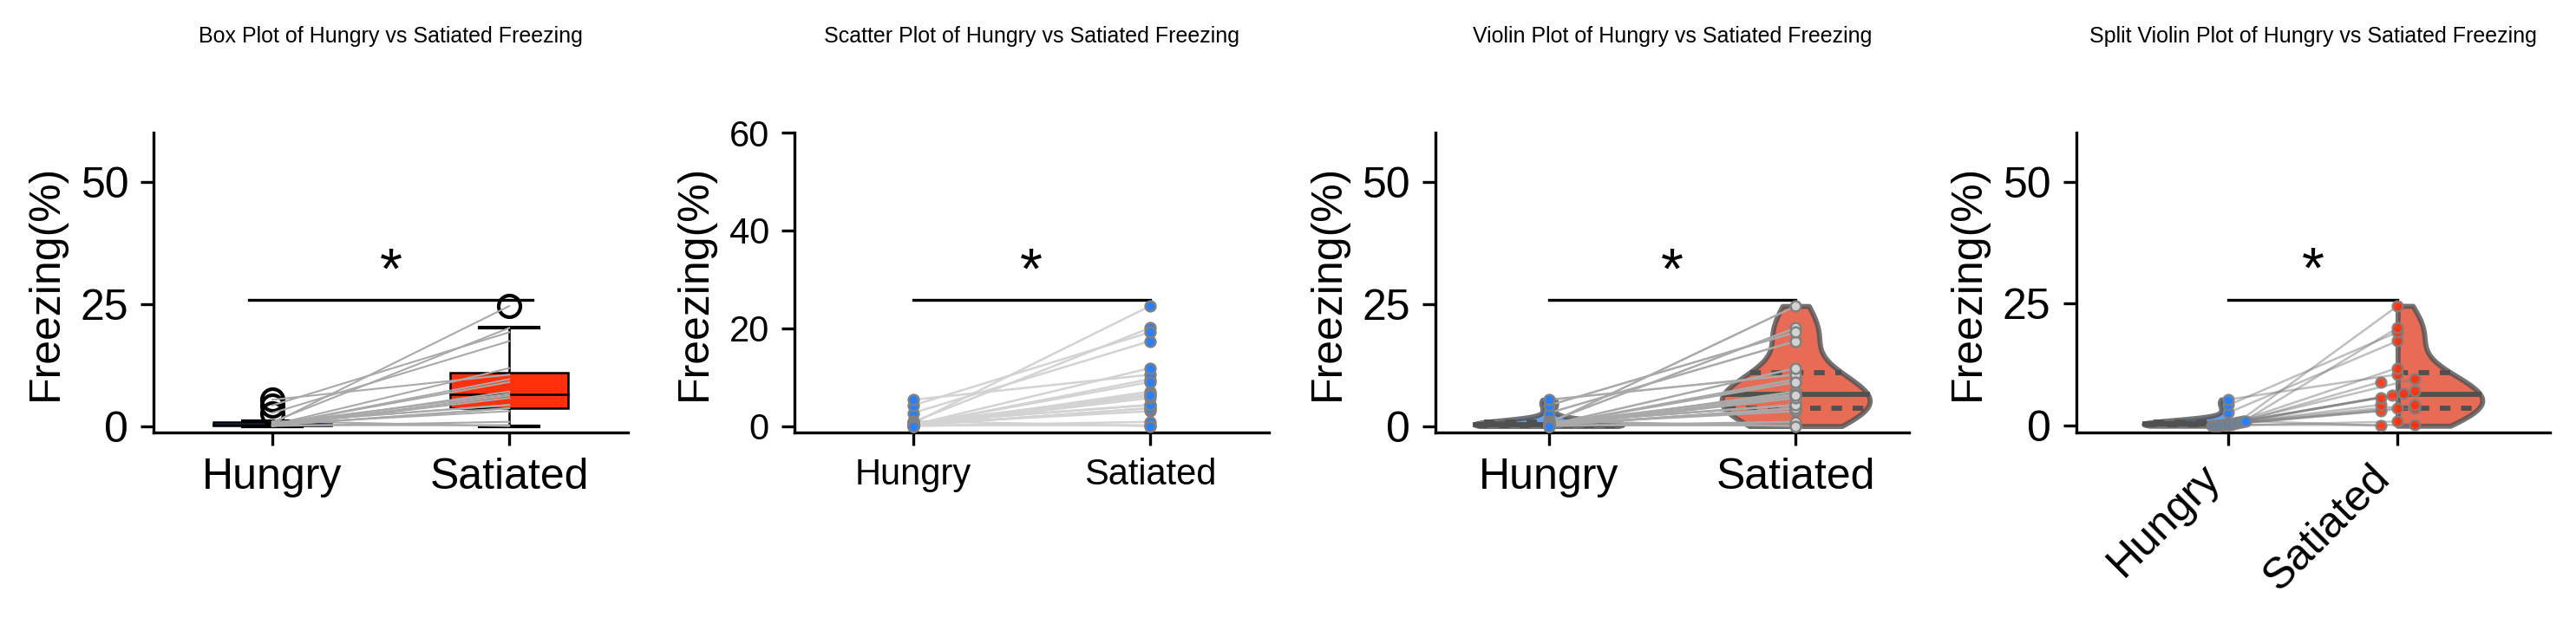

In [11]:
hungry_freezing = behavior_results['hungry_freezing']
satiated_freezing = behavior_results['satiated_freezing']
title_box = 'Box Plot of Hungry vs Satiated Freezing'
title_scatter = 'Scatter Plot of Hungry vs Satiated Freezing'
title_violin = 'Violin Plot of Hungry vs Satiated Freezing'
title_splitviolin = 'Split Violin Plot of Hungry vs Satiated Freezing'
figsize = (10, 2.5)  # Adjusted for 4 subplots side by side

y_label = 'Freezing(%)'
ylim = (None, 60)

# Create a figure with 4 subplots
fig, axs = plt.subplots(1, 4, figsize=figsize, dpi=300)


# First Plot - Boxplot with Lines
boxplot_with_lines(axs[0], hungry_freezing, satiated_freezing, 'Hungry', 'Satiated',title_box, y_label, ylim)

# Second Plot - Scatterplot with Lines
scatterplot_with_lines(axs[1], hungry_freezing, satiated_freezing, 'Hungry', 'Satiated',title_scatter, y_label, ylim)

# Third Plot - Violinplot with Dots and Lines
violinplot_with_dots_lines(axs[2], hungry_freezing, satiated_freezing, 'Hungry', 'Satiated',title_violin, y_label, ylim)

# Fourth Plot - Split Violin Plot with Dots and Lines
split_violin_with_dots_lines(axs[3], hungry_freezing, satiated_freezing, 'Hungry', 'Satiated',title_splitviolin, y_label, ylim)

plt.tight_layout()
plt.show()

In [12]:
hungry_rewarded = behavior_results['hungry_rewarded'].copy()
satiated_rewarded = behavior_results['satiated_rewarded'].copy()
hungry_rewarded['Data'] = pd.DataFrame(behavior_results['hungry_rewarded'].iloc[:,1:].mean(axis =1)*100)
satiated_rewarded['Data'] = pd.DataFrame(behavior_results['satiated_rewarded'].iloc[:,1:].mean(axis =1)*100)
title_box = 'Box Plot of Hungry vs Satiated Rewarded Tials'
title_scatter = 'Scatter Plot of Hungry vs Satiated Tials'
title_violin = 'Violin Plot of Hungry vs Satiated Tials'
title_splitviolin = 'Split Violin Plot of Hungry vs Satiated Tials'
figsize = (10, 2.5)  # Adjusted for 4 subplots side by side

y_label = 'Rewarded Trials(%)'
ylim = (0, 100)

# Create a figure with 4 subplots
fig, axs = plt.subplots(1, 4, figsize=figsize, dpi=300)


# First Plot - Boxplot with Lines
boxplot_with_lines(axs[0], hungry_rewarded, satiated_rewarded, 'Hungry', 'Satiated',title_box, y_label, ylim)

# Second Plot - Scatterplot with Lines
scatterplot_with_lines(axs[1], hungry_rewarded, satiated_rewarded, 'Hungry', 'Satiated',title_scatter, y_label, ylim)

# Third Plot - Violinplot with Dots and satiated_rewarded
violinplot_with_dots_lines(axs[2], hungry_rewarded, satiated_rewarded, 'Hungry', 'Satiated',title_violin, y_label, ylim)

# Fourth Plot - Split Violin Plot with Dots and Lines
split_violin_with_dots_lines(axs[3], hungry_rewarded, satiated_rewarded, 'Hungry', 'Satiated',title_splitviolin, y_label, ylim)

plt.tight_layout()
plt.show()

Normality test results for value1: Statistics = 0.3297882676124573, p-value = 1.2700994922454356e-08
Normality test results for value2: Statistics = 0.8669003248214722, p-value = 0.01036882121115923
Wilcoxon signed-rank test results: Statistics = 0.0, p-value = 1.9073486328125e-06
Normality test results for value1: Statistics = 0.3297882676124573, p-value = 1.2700994922454356e-08
Normality test results for value2: Statistics = 0.8669003248214722, p-value = 0.01036882121115923
Wilcoxon signed-rank test results: Statistics = 0.0, p-value = 1.9073486328125e-06
Normality test results for value1: Statistics = 0.3297882676124573, p-value = 1.2700994922454356e-08
Normality test results for value2: Statistics = 0.8669003248214722, p-value = 0.01036882121115923
Wilcoxon signed-rank test results: Statistics = 0.0, p-value = 1.9073486328125e-06
Normality test results for value1: Statistics = 0.3297882676124573, p-value = 1.2700994922454356e-08
Normality test results for value2: Statistics = 0.866

Normality test results for value1: Statistics = 0.9518702626228333, p-value = 0.3963746726512909
Normality test results for value2: Statistics = 0.8837166428565979, p-value = 0.02064925990998745
Wilcoxon signed-rank test results: Statistics = 16.0, p-value = 0.0003223419189453125
Normality test results for value1: Statistics = 0.3297882676124573, p-value = 1.2700994922454356e-08
Normality test results for value2: Statistics = 0.8669003248214722, p-value = 0.01036882121115923
Wilcoxon signed-rank test results: Statistics = 0.0, p-value = 1.9073486328125e-06
Normality test results for value1: Statistics = 0.7429776191711426, p-value = 0.00013687984028365463
Normality test results for value2: Statistics = 0.8601198196411133, p-value = 0.007913841865956783
Wilcoxon signed-rank test results: Statistics = 0.0, p-value = 1.9073486328125e-06
Normality test results for value1: Statistics = 0.9031149744987488, p-value = 0.04719184339046478
Normality test results for value2: Statistics = 0.723463

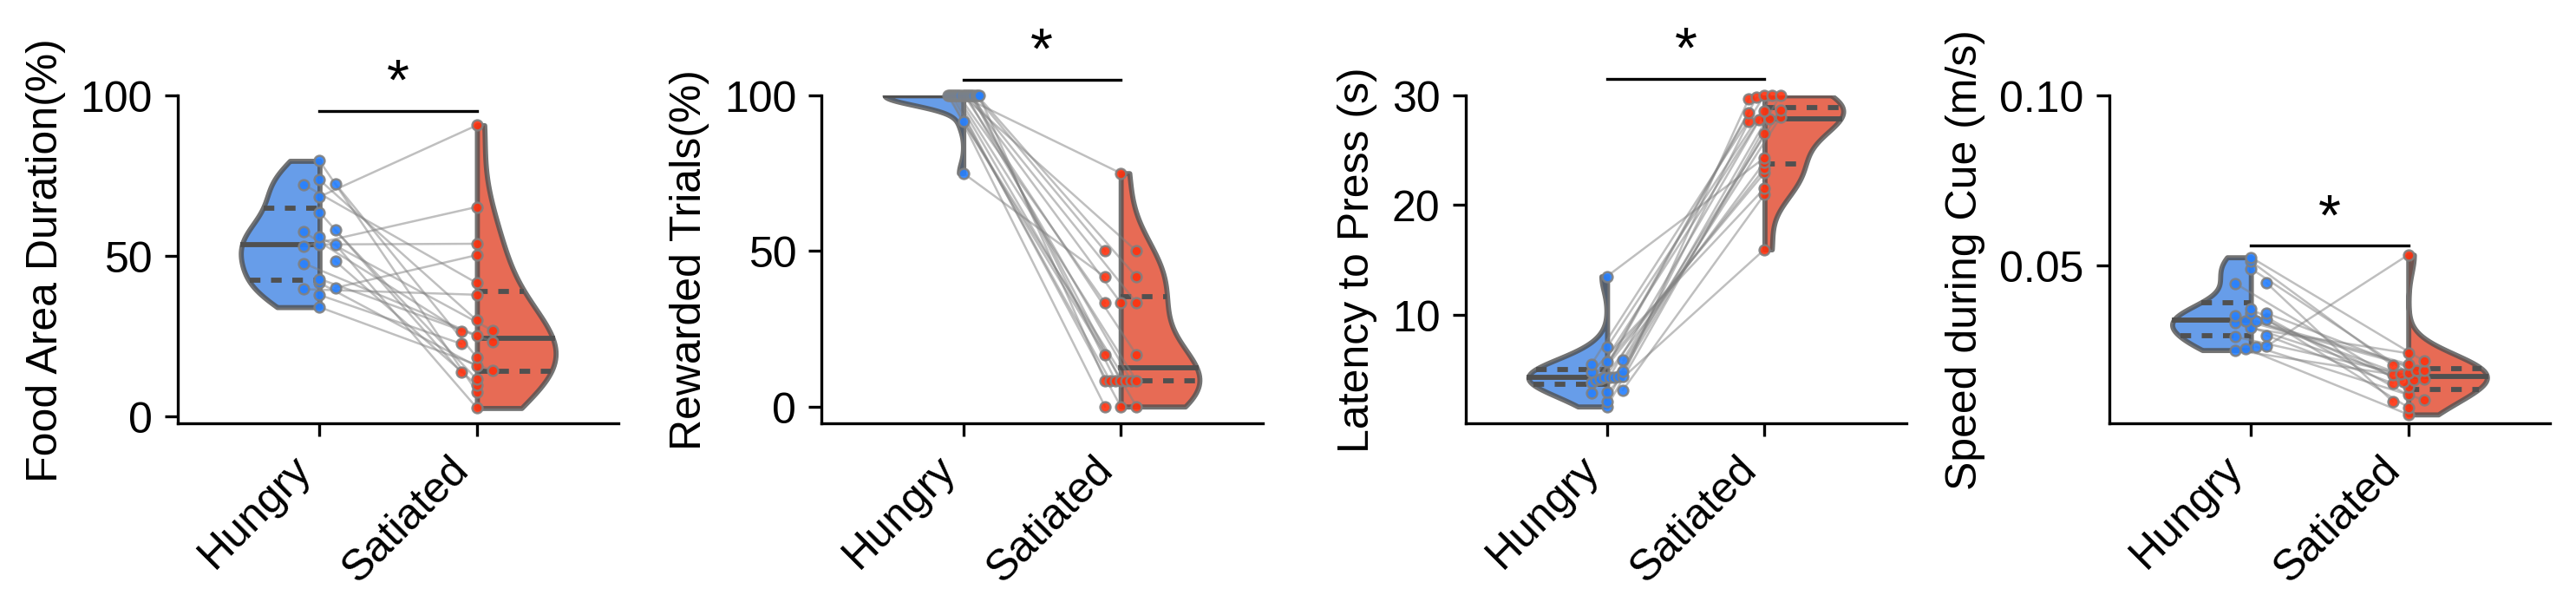

In [13]:
hungry_food_area = behavior_results['hungry_food_area']
satiated_food_area = behavior_results['satiated_food_area']

hungry_freezing = behavior_results['hungry_freezing']
satiated_freezing = behavior_results['satiated_freezing']

hungry_rewarded = behavior_results['hungry_rewarded'].copy()
satiated_rewarded = behavior_results['satiated_rewarded'].copy()
hungry_rewarded['Data'] = pd.DataFrame(behavior_results['hungry_rewarded'].iloc[:,1:].mean(axis =1)*100)
satiated_rewarded['Data'] = pd.DataFrame(behavior_results['satiated_rewarded'].iloc[:,1:].mean(axis =1)*100)

hungry_latency = behavior_results['hungry_latency'].copy()
satiated_latency  = behavior_results['satiated_latency'].copy()
hungry_latency['Data'] = pd.DataFrame(behavior_results['hungry_latency'].iloc[:,1:].mean(axis =1))
satiated_latency['Data'] = pd.DataFrame(behavior_results['satiated_latency'].iloc[:,1:].mean(axis =1))

hungry_speed = behavior_results['hungry_speed_cue'].copy()
satiated_speed  = behavior_results['satiated_speed_cue'].copy()
hungry_speed['Data'] = pd.DataFrame(behavior_results['hungry_speed_cue'].iloc[:,1:].mean(axis =1))
satiated_speed['Data'] = pd.DataFrame(behavior_results['satiated_speed_cue'].iloc[:,1:].mean(axis =1))

title_splitviolin = None
figsize = (10, 2.5)  # Adjusted for 4 subplots side by side

y_label_food = 'Food Area Duration(%)'
y_label_speed = 'Speed during Cue (m/s)'
y_label_rewarded = 'Rewarded Trials(%)'
y_label_latency = 'Latency to Press (s)'
ylim_food = (None, 100)
ylim_hidden = (None, 100)
ylim_speed = (None, 0.1)
ylim_rewarded = (None, 100)
ylim_latency = (None, 30)

fig, axs = plt.subplots(1, 4, figsize=figsize, dpi=300)


split_violin_with_dots_lines(axs[0], hungry_food_area, satiated_food_area, 'Hungry', 'Satiated',title_splitviolin, y_label_food, ylim_food)
split_violin_with_dots_lines(axs[1], hungry_rewarded, satiated_rewarded, 'Hungry', 'Satiated',title_splitviolin, y_label_rewarded, ylim_rewarded)
split_violin_with_dots_lines(axs[2], hungry_latency, satiated_latency, 'Hungry', 'Satiated',title_splitviolin, y_label_latency, ylim_latency)
split_violin_with_dots_lines(axs[3], hungry_speed, satiated_speed, 'Hungry', 'Satiated',title_splitviolin, y_label_speed, ylim_speed)

plt.tight_layout()
plt.show()

## Sex differences

In [14]:
sex_list = pd.read_csv(os.path.join(base_dir,'Miniscope_rat_sex.csv'))
np.unique(sex_list.sex, return_counts= True)

(array(['F', 'M'], dtype=object), array([16, 14]))

In [15]:

def add_sex_column_to_behavior_results(dfs, sex_list):
    """
    Adds a 'Sex' column to each DataFrame in the behavior_results dictionary based on the animal ID.
    :return: Updated behavior_results with the 'Sex' column added.
    """
    
    # Read the sex list
    sex_dict = dict(zip(sex_list['animal_id'], sex_list['sex']))

    # Iterate over each test in behavior_results and add the 'Sex' column
    updated_dfs = {}
    for test_name, df in dfs.items():
        # Make a copy of the DataFrame to avoid modifying the original
        df_copy = df.copy()

        # Check if 'animal_id' column exists in the DataFrame
        if 'animal_id' in df_copy.columns:
            # Map the 'Sex' based on 'animal_id'
            df_copy['Sex'] = df_copy['animal_id'].map(sex_dict).fillna('Unknown')
            updated_dfs[test_name] = df_copy
        else:
            print(f"No 'animal_id' column found in the DataFrame for test '{test_name}'")

    return updated_dfs


In [16]:
behavior_results_sex = add_sex_column_to_behavior_results(behavior_results, sex_list)
behavior_results_sex['hungry_food_area']

animal_id       Data Sex
0        9M6  41.518805   F
1        7H6  53.503023   F
2        2N6  47.596740   M
3        6H6  48.313549   F
4        2I5  53.570192   M
5        8H6  57.380288   F
6        1H6  37.755046   F
7        6S5  73.639557   M
8        8S5  55.831376   M
9        7M6  39.985104   F
10       6M6  39.546341   F
11       5B6  53.000692   F
12       1S5  68.389727   M
13       2S5  72.162251   M
14       2Z4  42.746227   M
15       4N6  63.585689   M
16       7B6  72.486439   F
17       4B6  57.927111   F
18       1I5  33.941760   M
19       1B6  79.575693   F

In [17]:
# Create an Excel file with each dataframe in its own sheet
excel_file_path = 'Satiation_miniscope_behavior_results_sex.xlsx'
with pd.ExcelWriter(excel_file_path, engine='xlsxwriter') as writer:
    for sheet_name, df in behavior_results_sex.items():
        df.to_excel(writer, sheet_name=sheet_name, index=False)

In [37]:
def split_violin_with_dots_lines_sexmarkers(ax, data1, data2, data1_name, data2_name, title, y_label, ylim, label, point_size=14, line_width=0.6):
    
    value1 = data1['Data']
    value2 = data2['Data']
    # Perform paired t-test
    if len(value1) != len(value2):
        print("Datasets are not of equal length, cannot perform paired t-test.")
        return

    # Normality test
    normality1 = stats.shapiro(value1)
    normality2 = stats.shapiro(value2)
    print(f"Normality test results for value1: Statistics = {normality1[0]}, p-value = {normality1[1]}")
    print(f"Normality test results for value2: Statistics = {normality2[0]}, p-value = {normality2[1]}")

    # Check if both datasets are normally distributed
    if normality1[1] > 0.05 and normality2[1] > 0.05:
        # Perform paired t-test
        t_stat, p_value = stats.ttest_rel(value1, value2)
        print(f"Paired t-test results: t-statistic = {t_stat}, p-value = {p_value}")
    else:
        # Perform Wilcoxon signed-rank test
        w_stat, p_value = stats.wilcoxon(value1, value2)
        print(f"Wilcoxon signed-rank test results: Statistics = {w_stat}, p-value = {p_value}")

    # First, create a copy to manipulate for plotting
    dt1 = data1.copy()
    dt2 = data2.copy()
    dt1['Condition'] = data1_name
    dt2['Condition'] = data2_name
    combined_data = pd.concat([dt1, dt2])
    plot_data = combined_data.copy()

    # Assign numeric x positions based on 'Sex' and 'Condition'
    plot_data.loc[(plot_data['Condition'] == data1_name), 'PlotSex'] = 0
    plot_data.loc[(plot_data['Condition'] == data2_name), 'PlotSex'] = 1

    # Plot the violin plot with adjusted positions
    sns.violinplot(x='PlotSex', y='Data', hue='Condition', data=plot_data, fill=False, split=True, dodge=1,
                   linewidth=0.8, palette=["orchid", "olivedrab"], width=1, inner='quart', cut=0, ax=ax, linecolor = 'white')
    ax.legend().remove()
    plt.setp(ax.collections, alpha=.5)
    
    #Adjust linestyle for mean
    for l in ax.lines[1::3]:
        l.set_linestyle('-')

    # Adjust for offset and coordinates
    spread = 0.1
    x_coords_cond = {data1_name: 0, data2_name: 1}

    # Store coordinates for connecting lines
    coords = {}

    # Define marker styles for each sex
    marker_styles = {'M': 'o', 'F': '^'}  # 'o' for male, '^' for female
    
    # Process each sex and condition combination
    for condition, group_data in combined_data.groupby('Condition'):
        grouped_values = group_values_with_indices(group_data['Data'].values, ylim[1]*0.01)

        for group, indices in grouped_values:
            x_coords = generate_symmetric_points(x_coords_cond[condition], spread, len(group))

            for i, idx in enumerate(indices):
                original_idx = group_data.iloc[idx].name  # Correct index from group_data
                x_coord = x_coords[i]
                y_value = group_data.loc[original_idx, 'Data']
                sex = group_data.loc[original_idx, 'Sex']

                # Store the coordinates for lines
                coords[(original_idx, condition)] = (x_coord, y_value)
                
                # Plot the individual scatter points with different markers for male and female
                color = 'orchid' if condition == data1_name else 'olivedrab'
                ax.scatter(x_coord, y_value, color=color, edgecolors='gray', alpha=0.9, clip_on=False, 
                           s=point_size, lw=line_width, zorder=3, marker=marker_styles[sex])

#     # Process each sex and condition combination
#     for condition, group_data in combined_data.groupby('Condition'):
#         grouped_values = group_values_with_indices(group_data['Data'].values, ylim[1]*0.01)

#         for group, indices in grouped_values:
#             x_coords = generate_symmetric_points(x_coords_cond[condition], spread, len(group))
            
#             for i, idx in enumerate(indices):
#                 original_idx = group_data.iloc[idx].name  # Correct index from group_data
#                 x_coord = x_coords[i]
#                 y_value = group_data.loc[original_idx, 'Data']

#                 # Store the coordinates for lines
#                 coords[(original_idx, condition)] = (x_coord, y_value)

#                 # Plot the individual scatter points
#                 color = '#2680ff' if condition == 'Safe' else '#ff310d'
#                 ax.scatter(x_coord, y_value, color=color, edgecolors='gray', alpha=0.9, clip_on=False, s=point_size, lw=line_width, zorder=3)

    # Draw connecting lines using stored coordinates
    for animal_id in combined_data['animal_id'].unique():
        animal_data = combined_data[combined_data['animal_id'] == animal_id]

        data1_key = next((key for key in coords if key[0] in animal_data.index and key[1] == data1_name), None)
        data2_key = next((key for key in coords if key[0] in animal_data.index and key[1] == data2_name), None)
        if data1_key and data2_key:
            data1_coord = coords[data1_key]
            data2_coord = coords[data2_key]
            ax.plot([data1_coord[0], data2_coord[0]], [data1_coord[1], data2_coord[1]], 
                    color='gray', alpha=0.5, linewidth=line_width)
    # Adjust for significance annotation
    if p_value < 0.05:
        y_max = min(combined_data['Data'].max()*1.05, ylim[1]*1.05)
        ax.plot([x_coords_cond[data1_name], x_coords_cond[data1_name], x_coords_cond[data2_name], x_coords_cond[data2_name]], [y_max, y_max, y_max, y_max], lw=0.8, c='k', clip_on=False)
        ax.text(0.5, y_max, "*", ha='center', va='bottom', color='k', fontsize=16)
    
    # Create a custom legend for sexes
    from matplotlib.lines import Line2D
    legend_elements = [Line2D([0], [0], marker='o', color='w', markersize=point_size, label='Male', mec = 'gray', markeredgewidth=line_width),
                       Line2D([0], [0], marker='^', color='w', markersize=point_size, label='Female', mec = 'gray', markeredgewidth=line_width)]

    # Custom function to simulate the desired legend
    def create_custom_legend(ax, point_size=10, line_width=2):
        # Define custom legend elements
        legend_elements = [
            Line2D([0], [0], marker='o', color='none', markerfacecolor='orchid', markersize=point_size, label='Male', markeredgewidth=line_width),
            Line2D([0], [0], marker='o', color='none', markerfacecolor='olivedrab', markersize=point_size, label=' ', markeredgewidth=line_width),
            Line2D([0], [0], marker='^', color='none', markerfacecolor='orchid', markersize=point_size, label='Female', markeredgewidth=line_width),
            Line2D([0], [0], marker='^', color='none', markerfacecolor='olivedrab', markersize=point_size, label=' ', markeredgewidth=line_width)
        ]
    
        # Create the legend
        legend = ax.legend(handles=legend_elements, ncol=2, frameon=False, handletextpad=0.5, columnspacing=1, loc='upper right', fontsize=10)

    # Remove the legend
    if label:
        create_custom_legend(ax)
#         ax.legend(handles=legend_elements, loc='upper right', frameon=False, markerscale = 0.5, fontsize = 8, bbox_to_anchor=(1.3, 1))
    ax.set_xticks([x_coords_cond[data1_name], x_coords_cond[data2_name]])
    ax.set_xticklabels([data1_name, data2_name], fontsize=8, rotation=45, ha='right')
    ax.set_xlabel(None)
    ax.set_title(title, fontsize=6, pad = 25)
    ax.set_ylabel(y_label, fontsize=16)
    ax.yaxis.set_label_coords(-0.25, 0.5)  # Adjust label position
    ax.set_ylim(*ylim)
    ax.tick_params(labelsize=16)
    sns.despine() 
    ax.margins(x=0.2)



In [62]:
def split_violin_with_dots_lines_sexmarkers(ax, data1, data2, data1_name, data2_name, title, y_label, ylim, label, point_size=14, line_width=0.6):
    
    value1 = data1['Data']
    value2 = data2['Data']
    # Perform paired t-test
    if len(value1) != len(value2):
        print("Datasets are not of equal length, cannot perform paired t-test.")
        return

    # Normality test
    normality1 = stats.shapiro(value1)
    normality2 = stats.shapiro(value2)
    print(f"Normality test results for value1: Statistics = {normality1[0]}, p-value = {normality1[1]}")
    print(f"Normality test results for value2: Statistics = {normality2[0]}, p-value = {normality2[1]}")

    # Check if both datasets are normally distributed
    if normality1[1] > 0.05 and normality2[1] > 0.05:
        # Perform paired t-test
        t_stat, p_value = stats.ttest_rel(value1, value2)
        print(f"Paired t-test results: t-statistic = {t_stat}, p-value = {p_value}")
    else:
        # Perform Wilcoxon signed-rank test
        w_stat, p_value = stats.wilcoxon(value1, value2)
        print(f"Wilcoxon signed-rank test results: Statistics = {w_stat}, p-value = {p_value}")

    # First, create a copy to manipulate for plotting
    dt1 = data1.copy()
    dt2 = data2.copy()
    dt1['Condition'] = data1_name
    dt2['Condition'] = data2_name
    combined_data = pd.concat([dt1, dt2])
    plot_data = combined_data.copy()

    # Assign numeric x positions based on 'Sex' and 'Condition'
    plot_data.loc[(plot_data['Condition'] == data1_name), 'PlotSex'] = 0
    plot_data.loc[(plot_data['Condition'] == data2_name), 'PlotSex'] = 1

    # Plot the violin plot with adjusted positions
    sns.violinplot(x='PlotSex', y='Data', hue='Condition', data=plot_data, fill=False, split=True, dodge=1,
                   linewidth=0.8, palette=["orchid", "olivedrab"], width=1, inner='quart', cut=0, ax=ax, linecolor = 'white')
    ax.legend().remove()
    plt.setp(ax.collections, alpha=.5)
    
    #Adjust linestyle for mean
    for l in ax.lines[1::3]:
        l.set_linestyle('-')

    # Adjust for offset and coordinates
    spread = 0.1
    x_coords_cond = {data1_name: 0, data2_name: 1}

    # Store coordinates for connecting lines
    coords = {}

    # Define marker styles for each sex
    marker_styles = {'M': 'o', 'F': '^'}  # 'o' for male, '^' for female
    
    # Process each sex and condition combination
    for condition, group_data in combined_data.groupby('Condition'):
        grouped_values = group_values_with_indices(group_data['Data'].values, ylim[1]*0.01)

        for group, indices in grouped_values:
            x_coords = generate_symmetric_points(x_coords_cond[condition], spread, len(group))

            for i, idx in enumerate(indices):
                original_idx = group_data.iloc[idx].name  # Correct index from group_data
                x_coord = x_coords[i]
                y_value = group_data.loc[original_idx, 'Data']
                sex = group_data.loc[original_idx, 'Sex']

                # Store the coordinates for lines
                coords[(original_idx, condition)] = (x_coord, y_value)
                
                # Plot the individual scatter points with different markers for male and female
                color = 'orchid' if condition == data1_name else 'olivedrab'
                ax.scatter(x_coord, y_value, color=color, edgecolors='gray', alpha=0.9, clip_on=False, 
                           s=point_size, lw=line_width, zorder=3, marker=marker_styles[sex])

#     # Process each sex and condition combination
#     for condition, group_data in combined_data.groupby('Condition'):
#         grouped_values = group_values_with_indices(group_data['Data'].values, ylim[1]*0.01)

#         for group, indices in grouped_values:
#             x_coords = generate_symmetric_points(x_coords_cond[condition], spread, len(group))
            
#             for i, idx in enumerate(indices):
#                 original_idx = group_data.iloc[idx].name  # Correct index from group_data
#                 x_coord = x_coords[i]
#                 y_value = group_data.loc[original_idx, 'Data']

#                 # Store the coordinates for lines
#                 coords[(original_idx, condition)] = (x_coord, y_value)

#                 # Plot the individual scatter points
#                 color = '#2680ff' if condition == 'Safe' else '#ff310d'
#                 ax.scatter(x_coord, y_value, color=color, edgecolors='gray', alpha=0.9, clip_on=False, s=point_size, lw=line_width, zorder=3)

    # Draw connecting lines using stored coordinates
    for animal_id in combined_data['animal_id'].unique():
        animal_data = combined_data[combined_data['animal_id'] == animal_id]

        data1_key = next((key for key in coords if key[0] in animal_data.index and key[1] == data1_name), None)
        data2_key = next((key for key in coords if key[0] in animal_data.index and key[1] == data2_name), None)
        if data1_key and data2_key:
            data1_coord = coords[data1_key]
            data2_coord = coords[data2_key]
            ax.plot([data1_coord[0], data2_coord[0]], [data1_coord[1], data2_coord[1]], 
                    color='gray', alpha=0.5, linewidth=line_width)
    # Adjust for significance annotation
    if p_value < 0.05:
        y_max = min(combined_data['Data'].max()*1.05, ylim[1]*1.05)
        ax.plot([x_coords_cond[data1_name], x_coords_cond[data1_name], x_coords_cond[data2_name], x_coords_cond[data2_name]], [y_max, y_max, y_max, y_max], lw=0.8, c='k', clip_on=False)
        ax.text(0.5, y_max, "*", ha='center', va='bottom', color='k', fontsize=16)
    
    from matplotlib.legend_handler import HandlerTuple
    
    # Define custom legend markers and colors
    markers = [('o', 'orchid'), ('o', 'olivedrab'), ('^', 'orchid'), ('^', 'olivedrab')]
    labels = ['Male', 'Female']

    # Create Line2D objects for each marker/color combination
    line1 = Line2D([0], [0], marker='o', color='w', markerfacecolor='orchid', mec = 'gray', markersize=4)
    line2 = Line2D([0], [0], marker='o', color='w', markerfacecolor='olivedrab', mec = 'gray', markersize=4)
    line3 = Line2D([0], [0], marker='^', color='w', markerfacecolor='orchid', mec = 'gray', markersize=4)
    line4 = Line2D([0], [0], marker='^', color='w', markerfacecolor='olivedrab', mec = 'gray', markersize=4)


    # Group markers by gender using tuples
    male_markers = (line1, line2)
    female_markers = (line3, line4)
    # Create a custom handler map to handle tuples
    handler_map = {tuple: HandlerTuple(ndivide=None)}

    # Remove the legend
    if label:
        ax.legend([male_markers, female_markers], labels, frameon=False, handler_map=handler_map, loc="upper right", handletextpad=1, handlelength=2, fontsize=10, bbox_to_anchor=(1.3, 1))
#         ax.legend(handles=legend_elements, loc='upper right', frameon=False, markerscale = 0.5, fontsize = 8, bbox_to_anchor=(1.3, 1))
    ax.set_xticks([x_coords_cond[data1_name], x_coords_cond[data2_name]])
    ax.set_xticklabels([data1_name, data2_name], fontsize=10, rotation=45, ha='right')
    ax.set_xlabel(None)
    ax.set_title(title, fontsize=6, pad = 25)
    ax.set_ylabel(y_label, fontsize=16)
    ax.yaxis.set_label_coords(-0.25, 0.5)  # Adjust label position
    ax.set_ylim(*ylim)
    ax.tick_params(labelsize=16)
    sns.despine() 
    ax.margins(x=0.2)


Normality test results for value1: Statistics = 0.9518702626228333, p-value = 0.3963746726512909
Normality test results for value2: Statistics = 0.8837166428565979, p-value = 0.02064925990998745
Wilcoxon signed-rank test results: Statistics = 16.0, p-value = 0.0003223419189453125
Normality test results for value1: Statistics = 0.3297882676124573, p-value = 1.2700994922454356e-08
Normality test results for value2: Statistics = 0.8669003248214722, p-value = 0.01036882121115923
Wilcoxon signed-rank test results: Statistics = 0.0, p-value = 1.9073486328125e-06
Normality test results for value1: Statistics = 0.7429776191711426, p-value = 0.00013687984028365463
Normality test results for value2: Statistics = 0.8601198196411133, p-value = 0.007913841865956783
Wilcoxon signed-rank test results: Statistics = 0.0, p-value = 1.9073486328125e-06
Normality test results for value1: Statistics = 0.9031149744987488, p-value = 0.04719184339046478
Normality test results for value2: Statistics = 0.723463

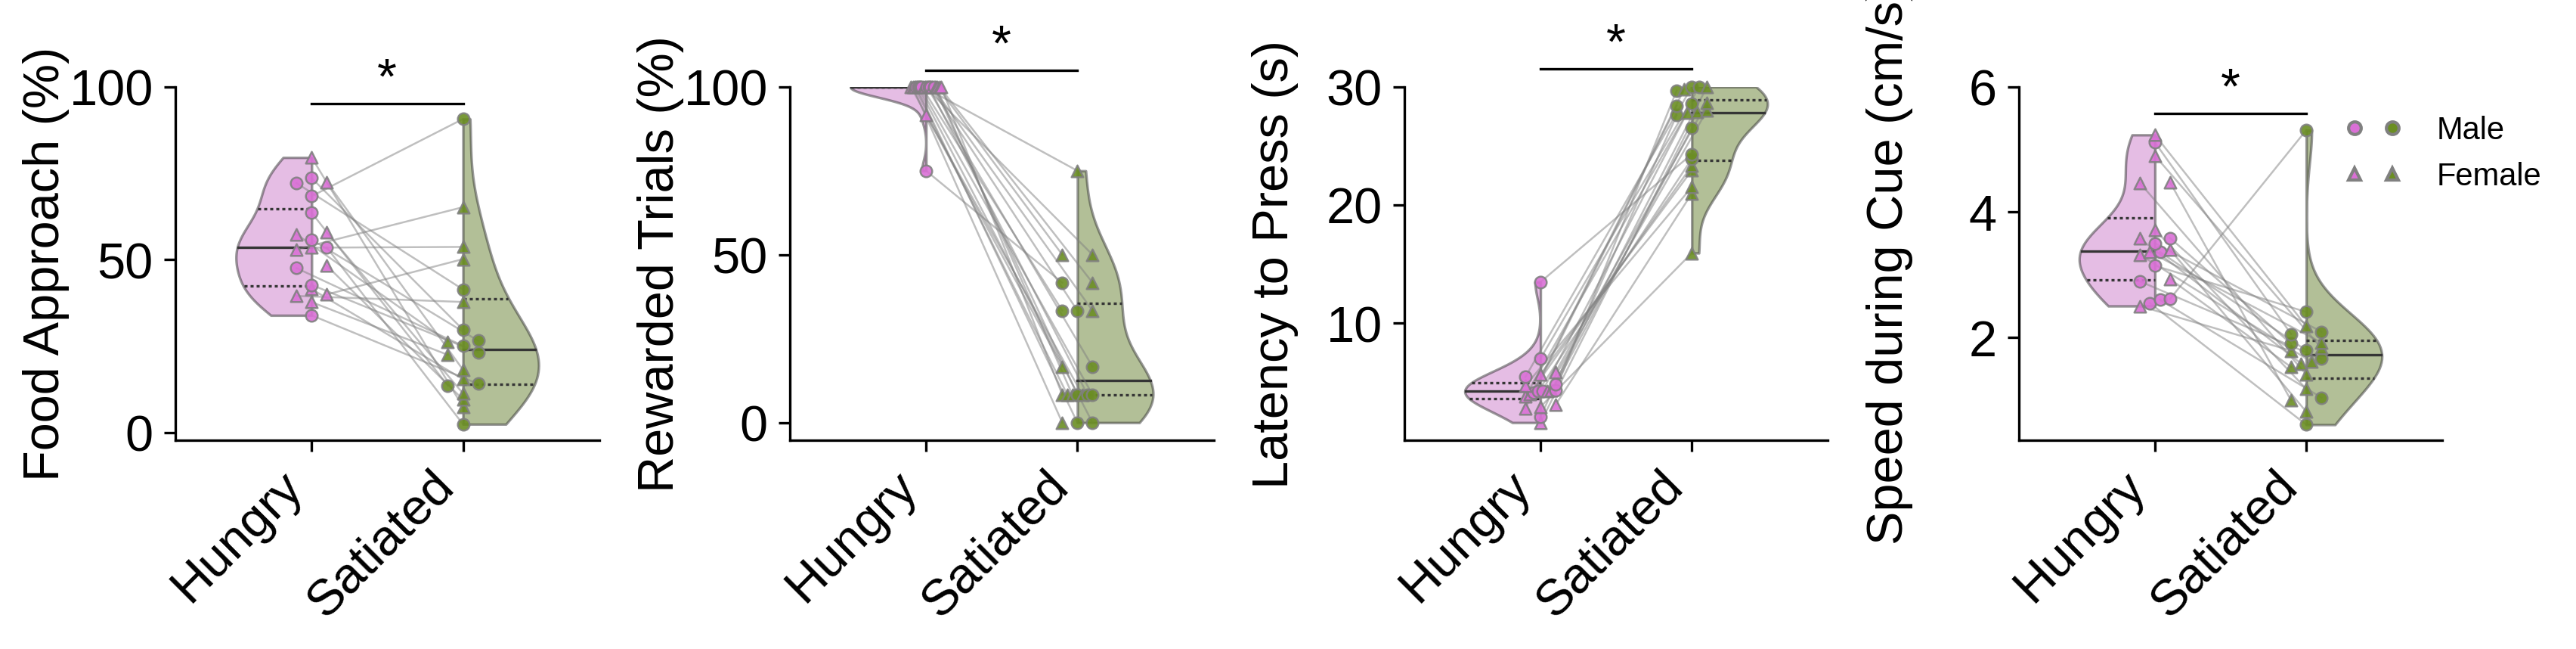

In [63]:
hungry_food_area = behavior_results_sex['hungry_food_area']
satiated_food_area = behavior_results_sex['satiated_food_area']

# hungry_freezing = behavior_results_sex['hungry_freezing']
# satiated_freezing = behavior_results_sex['satiated_freezing']

hungry_rewarded = behavior_results_sex['hungry_rewarded'].copy()
satiated_rewarded = behavior_results_sex['satiated_rewarded'].copy()
hungry_rewarded['Data'] = pd.DataFrame(behavior_results_sex['hungry_rewarded'].iloc[:,1:-1].mean(axis =1)*100)
satiated_rewarded['Data'] = pd.DataFrame(behavior_results_sex['satiated_rewarded'].iloc[:,1:-1].mean(axis =1)*100)

hungry_latency = behavior_results_sex['hungry_latency'].copy()
satiated_latency  = behavior_results_sex['satiated_latency'].copy()
hungry_latency['Data'] = pd.DataFrame(behavior_results_sex['hungry_latency'].iloc[:,1:-1].mean(axis =1))
satiated_latency['Data'] = pd.DataFrame(behavior_results_sex['satiated_latency'].iloc[:,1:-1].mean(axis =1))

hungry_speed = behavior_results_sex['hungry_speed_cue'].copy()
satiated_speed  = behavior_results_sex['satiated_speed_cue'].copy()
hungry_speed['Data'] = pd.DataFrame(behavior_results_sex['hungry_speed_cue'].iloc[:,1:-1].mean(axis =1))*100
satiated_speed['Data'] = pd.DataFrame(behavior_results_sex['satiated_speed_cue'].iloc[:,1:-1].mean(axis =1))*100

hungry_speed_1s = behavior_results_sex['hungry_speed_cue_1s'].copy()
satiated_speed_1s  = behavior_results_sex['satiated_speed_cue_1s'].copy()
hungry_speed_1s['Data'] = pd.DataFrame(behavior_results_sex['hungry_speed_cue_1s'].iloc[:,1:-1].mean(axis =1))*100
satiated_speed_1s['Data'] = pd.DataFrame(behavior_results_sex['satiated_speed_cue_1s'].iloc[:,1:-1].mean(axis =1))*100

title_splitviolin = None
figsize = (11.5, 3) 

y_label_food = 'Food Approach (%)'
y_label_speed = 'Speed during Cue (cm/s)'
y_label_speed_1s = 'Speed 1s Post-Cue (cm/s)'
y_label_rewarded = 'Rewarded Trials (%)'
y_label_latency = 'Latency to Press (s)'
ylim_food = (None, 100)
ylim_hidden = (None, 100)
ylim_speed = (None, 6)
ylim_rewarded = (None, 100)
ylim_latency = (None, 30)

fig, axs = plt.subplots(1, 4, figsize=figsize, dpi=300)

split_violin_with_dots_lines_sexmarkers(axs[0], hungry_food_area, satiated_food_area, 'Hungry', 'Satiated',title_splitviolin, y_label_food, ylim_food, label = False)
split_violin_with_dots_lines_sexmarkers(axs[1], hungry_rewarded, satiated_rewarded, 'Hungry', 'Satiated',title_splitviolin, y_label_rewarded, ylim_rewarded, label = False)
split_violin_with_dots_lines_sexmarkers(axs[2], hungry_latency, satiated_latency, 'Hungry', 'Satiated',title_splitviolin, y_label_latency, ylim_latency, label = False)
split_violin_with_dots_lines_sexmarkers(axs[3], hungry_speed, satiated_speed, 'Hungry', 'Satiated',title_splitviolin, y_label_speed, ylim_speed, label = True)
# split_violin_with_dots_lines_sexmarkers(axs[4], hungry_speed_1s, satiated_speed_1s, 'Hungry', 'Satiated',title_splitviolin, y_label_speed_1s, ylim_speed, label = False)

plt.tight_layout()
plt.show()

Normality test results for value1: Statistics = 0.9518702626228333, p-value = 0.3963746726512909
Normality test results for value2: Statistics = 0.8837166428565979, p-value = 0.02064925990998745
Wilcoxon signed-rank test results: Statistics = 16.0, p-value = 0.0003223419189453125


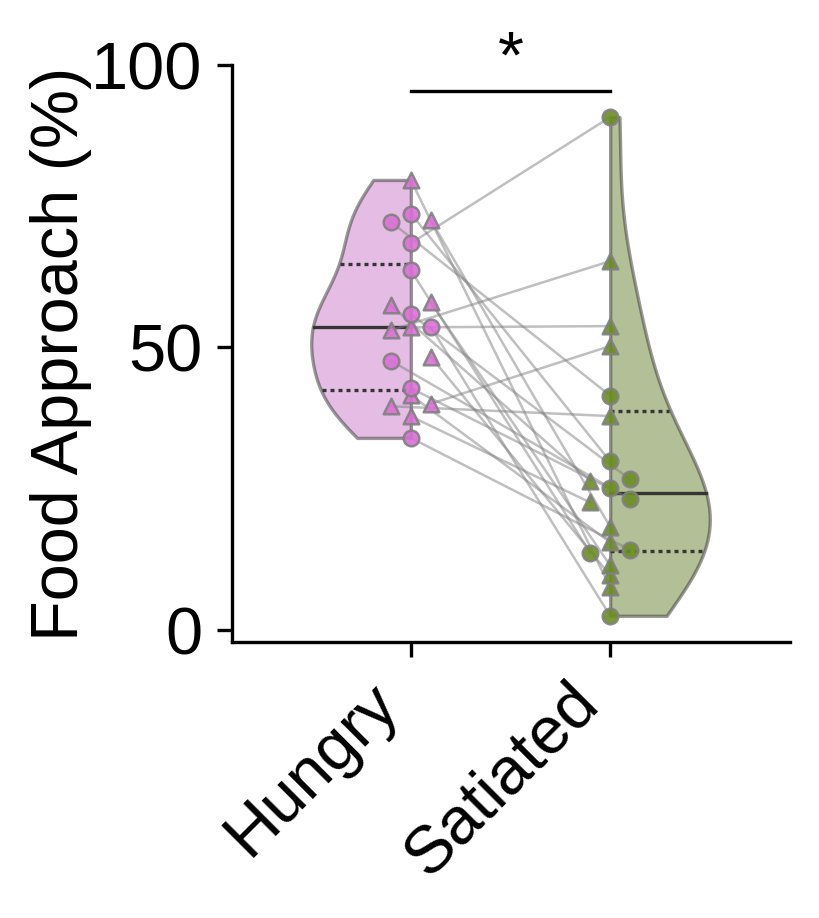

In [64]:
fig, axs = plt.subplots(figsize = (2.4,2.5), dpi=300)
split_violin_with_dots_lines_sexmarkers(axs, hungry_food_area, satiated_food_area, 'Hungry', 'Satiated',title_splitviolin, y_label_food, ylim_food, label = False)
# plt.figure(constrained_layout=True)

Normality test results for value1: Statistics = 0.3297882676124573, p-value = 1.2700994922454356e-08
Normality test results for value2: Statistics = 0.8669003248214722, p-value = 0.01036882121115923
Wilcoxon signed-rank test results: Statistics = 0.0, p-value = 1.9073486328125e-06


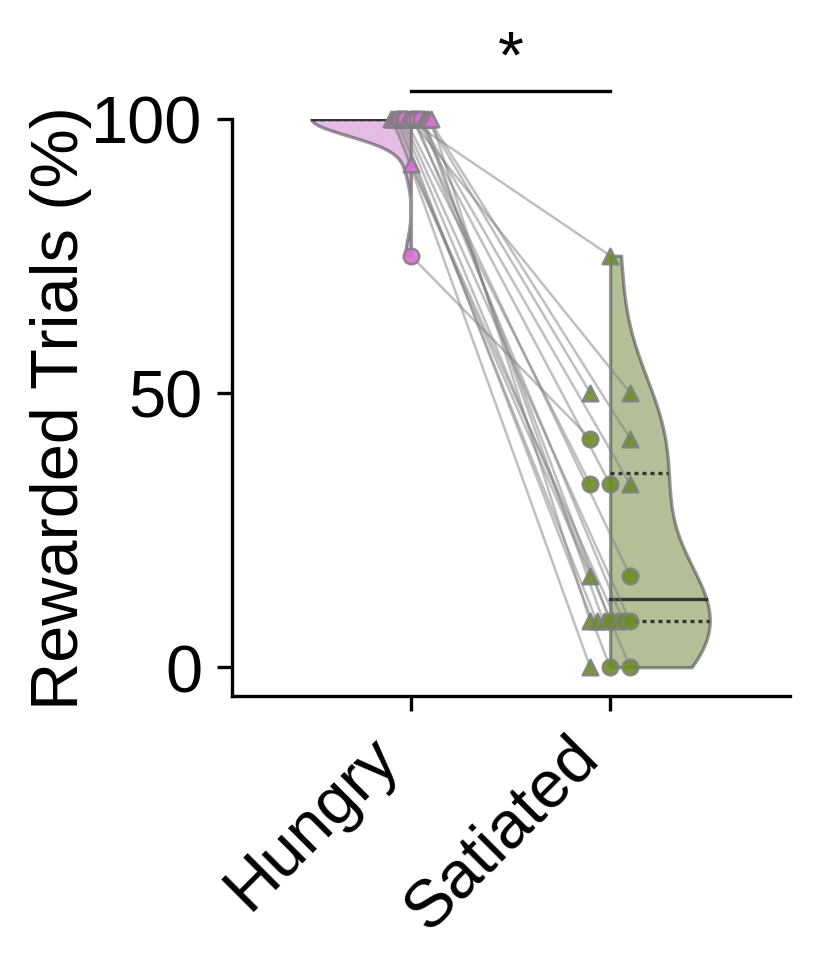

In [65]:
fig, axs = plt.subplots(figsize = (2.4,2.5), dpi=300)
split_violin_with_dots_lines_sexmarkers(axs, hungry_rewarded, satiated_rewarded, 'Hungry', 'Satiated',title_splitviolin, y_label_rewarded, ylim_rewarded, label = False)
# plt.figure(constrained_layout=True)

Normality test results for value1: Statistics = 0.7429776191711426, p-value = 0.00013687984028365463
Normality test results for value2: Statistics = 0.8601198196411133, p-value = 0.007913841865956783
Wilcoxon signed-rank test results: Statistics = 0.0, p-value = 1.9073486328125e-06


<Figure size 640x480 with 0 Axes>

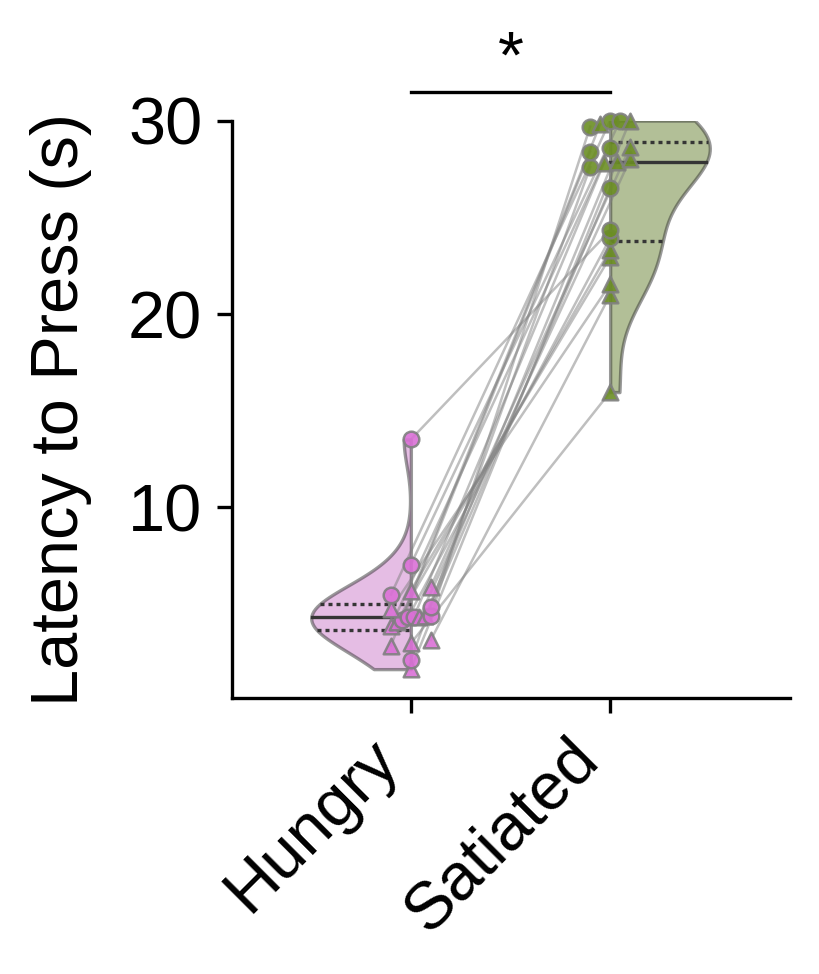

<Figure size 640x480 with 0 Axes>

In [66]:
fig, axs = plt.subplots(figsize = (2.4,2.5), dpi=300)
split_violin_with_dots_lines_sexmarkers(axs, hungry_latency, satiated_latency, 'Hungry', 'Satiated',title_splitviolin, y_label_latency, ylim_latency, label = False)
plt.figure(constrained_layout=True)

Normality test results for value1: Statistics = 0.9031149744987488, p-value = 0.04719184339046478
Normality test results for value2: Statistics = 0.7234636545181274, p-value = 7.641586853424087e-05
Wilcoxon signed-rank test results: Statistics = 15.0, p-value = 0.0002613067626953125


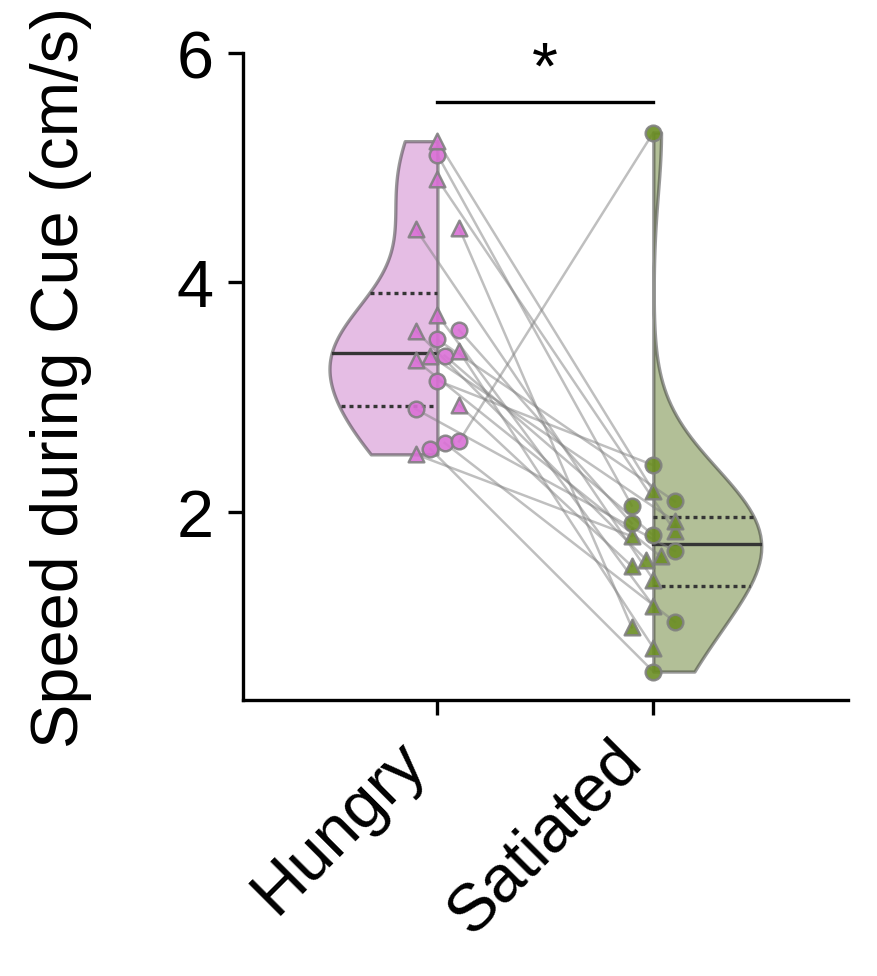

In [67]:
fig, axs = plt.subplots(figsize = (2.6,2.8), dpi=300)
split_violin_with_dots_lines_sexmarkers(axs, hungry_speed, satiated_speed, 'Hungry', 'Satiated',title_splitviolin, y_label_speed, ylim_speed, label = False)


In [68]:
def wilcoxon_sign_test(group_data, data1_name, data2_name,):
        safe_data = group_data[group_data['Condition'] == data1_name]['Data']
        threat_data = group_data[group_data['Condition'] == data2_name]['Data']

       
        stat, p_value = stats.wilcoxon(safe_data, threat_data)
        
        return stat, p_value
    
def paired_ttest(group_data, data1_name, data2_name,):
        safe_data = group_data[group_data['Condition'] == data1_name]['Data']
        threat_data = group_data[group_data['Condition'] == data2_name]['Data']
        
        # Data are normally distributed
        stat, p_value = stats.ttest_rel(safe_data, threat_data)
        
        return stat, p_value

def split_violin_with_dots_lines_sex(ax, data1, data2, data1_name, data2_name, title, y_label, ylim, label, point_size=14, line_width=0.6):
    # Combine data1 and data2 into a single DataFrame
    data1['Condition'] = data1_name
    data2['Condition'] = data2_name
    combined_data = pd.concat([data1, data2])

    # Encode categorical variables
    combined_data['Sex'] = pd.Categorical(combined_data['Sex'])
    combined_data['Condition'] = pd.Categorical(combined_data['Condition'])

    # Perform 2-way RM ANOVA using MixedLM
    model = MixedLM.from_formula("Data ~ Sex * Condition", combined_data, groups=combined_data["animal_id"], re_formula="~Condition")
    results = model.fit()
    print(results.summary())
    # Assuming 'results' is your MixedLM results object
    tables = results.summary().tables

    # The fixed effects are typically in the second table (index 1)
    fixed_effects_df = tables[1]

    # Access the p-value for the interaction term 'Sex[T.M]:Condition[T.Threat]'
    interaction_p_value = float(fixed_effects_df.iloc[3, 3])
    print("Interaction: p-value =", interaction_p_value)
    # Perform pairwise comparisons with normality check
    
    # Split the data by Sex
    male_data = combined_data[combined_data['Sex'] == 'M']
    female_data = combined_data[combined_data['Sex'] == 'F']
    
    # Normality test
    normality1 = stats.shapiro(male_data['Data'])
    normality2 = stats.shapiro(female_data['Data'])
    print(f"Normality test results for male: Statistics = {normality1[0]}, p-value = {normality1[1]}")
    print(f"Normality test results for female: Statistics = {normality2[0]}, p-value = {normality2[1]}")

    # Normality test
    safe_data = combined_data[combined_data['Condition'] == data1_name]['Data']
    threat_data = combined_data[combined_data['Condition'] == data2_name]['Data']
    diff = safe_data - threat_data
    normality = stats.shapiro(diff)
    print(f"Normality test results for {data1_name} - {data2_name}: Statistics = {normality[0]}, p-value = {normality[1]}")

               
    if (normality1[1] < 0.05) & (normality2[1] < 0.05) & (normality[1] < 0.05):
        male_stat, male_pvalue = wilcoxon_sign_test(male_data, data1_name, data2_name)
        female_stat, female_pvalue = wilcoxon_sign_test(female_data, data1_name, data2_name)
    else:
        male_stat, male_pvalue = paired_ttest(male_data, data1_name, data2_name)
        female_stat, female_pvalue = paired_ttest(female_data, data1_name, data2_name)

    # Combine p-values for Sidak correction
    p_values = [male_pvalue, female_pvalue]
    sidak_corrected = multipletests(p_values, method='sidak')

    # Print results
    print("Male comparison: Statistics =", male_stat, ", Sidak corrected p-values =", sidak_corrected[1][0])
    print("Female comparison: Statistics =", female_stat, ", Sidak corrected p-values =", sidak_corrected[1][1])
    
    # First, create a copy to manipulate for plotting
    plot_data = combined_data.copy()

    # Assign numeric x positions based on 'Sex' and 'Condition'
    plot_data.loc[(plot_data['Sex'] == 'M') & (plot_data['Condition'] ==  data1_name), 'PlotSex'] = 0
    plot_data.loc[(plot_data['Sex'] == 'M') & (plot_data['Condition'] == data2_name), 'PlotSex'] = 1
    plot_data.loc[(plot_data['Sex'] == 'F') & (plot_data['Condition'] == data1_name), 'PlotSex'] = 3  # Skip 2 for the gap
    plot_data.loc[(plot_data['Sex'] == 'F') & (plot_data['Condition'] == data2_name), 'PlotSex'] = 4
    
    # Now add the dummy category
    dummy_category = pd.DataFrame({'PlotSex': [2], 'Data': [None], 'Condition': [None], 'Sex': [None]})
    plot_data = pd.concat([plot_data, dummy_category], ignore_index=True)
    
    # Plot the violin plot with adjusted positions
    sns.violinplot(x = 'PlotSex', y='Data', hue='Condition', 
                   data=plot_data, 
                   fill=False, split=True, width=1, palette=['#2680ff', 'lightgray'],
                   linewidth=1, inner='quart', cut=0, ax=ax, dodge = 'auto')
    ax.legend().remove()
    plt.setp(ax.collections, alpha=0.6)
    
    # Manually set colors for each violin
    colors = sns.color_palette('Set2')
    for ind, violin in enumerate(ax.findobj(PolyCollection)):
        rgb = to_rgb(colors[ind // 2])
        if ind % 2 != 0:
            rgb = 0.6 + 0.4 * np.array(rgb)  # make whiter
        else:
            rgb = 0.8*np.array(rgb) # make darker
        violin.set_facecolor(rgb)

    #Adjust linestyle for mean
    for l in ax.lines[1::3]:
        l.set_linestyle('-')  
        
    # Adjust for offset and coordinates
    offset = 0.14
    x_coords_sex = {'M': 0, 'F': 3}

    # Store coordinates for connecting lines
    coords = {}
    
    # Generate base colors from seaborn palette
    base_colors = sns.color_palette('Set2')
    sex_condition_to_color = {
        ('M', data1_name): to_rgb(base_colors[0]),  # Male Safe
        ('M', data2_name): 0.6 + 0.4 * np.array(to_rgb(base_colors[0])),  # Male Threat (lighter version)
        ('F', data1_name): to_rgb(base_colors[1]),  # Female Safe
        ('F', data2_name): 0.6 + 0.4 * np.array(to_rgb(base_colors[1]))  # Female Threat (lighter version)
    }

    # Calculate the diameter in points
    diameter_points = 2 * sqrt(point_size / pi)
    actual_ylim = ax.get_ylim()
    
    # Convert diameter to inches
    diameter_inches = diameter_points / 72

    # Get the height of the axes in inches
    bbox = ax.get_window_extent().transformed(fig.dpi_scale_trans.inverted())
    axes_height_inches = bbox.height

    # Get the conversion factor from inches to data units
    y_range = ylim[1] - actual_ylim[0]
    conversion_factor = y_range / axes_height_inches

    # Convert diameter from points to data units
    diameter_data_units = diameter_inches * conversion_factor
    
    # Process each sex and condition combination
    for (sex, condition), group_data in combined_data.groupby(['Sex', 'Condition']):
        grouped_values = group_values_with_indices(group_data['Data'].values, diameter_data_units)
        scatter_color = sex_condition_to_color[(sex, condition)]

        for group, indices in grouped_values:
            x_coords = generate_symmetric_points(x_coords_sex[sex] + (0 if condition == data1_name else 1), offset, len(group))
            
            for i, idx in enumerate(indices):
                original_idx = group_data.iloc[idx].name  # Correct index from group_data
                x_coord = x_coords[i]
                y_value = group_data.loc[original_idx, 'Data']

                # Store the coordinates for lines
                coords[(original_idx, sex, condition)] = (x_coord, y_value)

                # Plot the individual scatter points
                color = '#2680ff' if condition == data1_name else '#ff310d'
                ax.scatter(x_coord, y_value, color=scatter_color, edgecolors='gray', alpha=1, clip_on=False, s=point_size, lw=line_width, zorder=3)

    # Draw connecting lines using stored coordinates
    for animal_id in combined_data['animal_id'].unique():
        animal_data = combined_data[combined_data['animal_id'] == animal_id]
        for sex in ['M', 'F']:
            safe_key = next((key for key in coords if key[0] in animal_data.index and key[1] == sex and key[2] == data1_name), None)
            threat_key = next((key for key in coords if key[0] in animal_data.index and key[1] == sex and key[2] == data2_name), None)
            if safe_key and threat_key:
                safe_coord = coords[safe_key]
                threat_coord = coords[threat_key]
                ax.plot([safe_coord[0], threat_coord[0]], [safe_coord[1], threat_coord[1]], 
                        color='gray', alpha=0.5, linewidth=line_width)
  
    x_coords_sex = {'M': [0, 1], 'F': [3, 4]}  # X positions for Safe and Threat for each sex
    y_max = min(combined_data['Data'].max()*1.05, ylim[1]*1.05)
    
    # Check for significance and annotate for Male and Female
    for sex, p_value in zip(['M', 'F'], sidak_corrected[1]):
        if p_value < 0.05:
            x_coords = x_coords_sex[sex]
            # Draw lines for significance
            ax.plot([x_coords[0], x_coords[0], x_coords[1], x_coords[1]], [y_max, y_max, y_max, y_max], lw=0.8, c='k', clip_on=False)
            # Add asterisk for significance
            ax.text((x_coords[0] + x_coords[1]) / 2, y_max, "*", ha='center', va='bottom', color='k', fontsize=16)

    
    # Creating scatter points for the legend
    sex_safe_color = {
        'M': to_rgb(base_colors[0]),  # Male Safe
        'F': to_rgb(base_colors[1])   # Female Safe
    }

    # Customize the plot
    # Create custom legend handles
    legend_handles = [
        mlines.Line2D([], [], color=sex_safe_color['M'], marker='o', linestyle='None', markersize=point_size, label='Male', mec = 'gray', markeredgewidth=line_width),
        mlines.Line2D([], [], color=sex_safe_color['F'], marker='o', linestyle='None', markersize=point_size, label='Female', mec = 'gray', markeredgewidth=line_width)
    ]
    
    # Add the custom legend to the plot
    if label:
        ax.legend(handles=legend_handles, loc='upper right', frameon=False, markerscale = 0.5, fontsize = 12, bbox_to_anchor=(1.3, 1))
    ax.set_xticks([0, 1, 3, 4])
    ax.set_xticklabels([data1_name, data2_name, data1_name, data2_name], fontsize=8, rotation=45, ha='right')
    ax.set_xlabel(None)
    ax.set_title(title, fontsize=6, pad = 25)
    ax.set_ylabel(y_label, fontsize=11)
    ax.set_ylim(*ylim)
    ax.tick_params(axis = 'x', labelsize=12)
    ax.tick_params(axis = 'y', labelsize=12)
    sns.despine() 
    ax.margins(x=0.1)
    


In [78]:
def wilcoxon_sign_test(group_data, data1_name, data2_name,):
        safe_data = group_data[group_data['Condition'] == data1_name]['Data']
        threat_data = group_data[group_data['Condition'] == data2_name]['Data']

       
        stat, p_value = stats.wilcoxon(safe_data, threat_data)
        
        return stat, p_value
    
def paired_ttest(group_data, data1_name, data2_name,):
        safe_data = group_data[group_data['Condition'] == data1_name]['Data']
        threat_data = group_data[group_data['Condition'] == data2_name]['Data']
        
        # Data are normally distributed
        stat, p_value = stats.ttest_rel(safe_data, threat_data)
        
        return stat, p_value

def split_violin_with_dots_lines_sex(ax, data1, data2, data1_name, data2_name, title, y_label, ylim, label, point_size=14, line_width=0.6):
    # Combine data1 and data2 into a single DataFrame
    data1['Condition'] = data1_name
    data2['Condition'] = data2_name
    combined_data = pd.concat([data1, data2])

    # Encode categorical variables
    combined_data['Sex'] = pd.Categorical(combined_data['Sex'])
    combined_data['Condition'] = pd.Categorical(combined_data['Condition'])

    # Perform 2-way RM ANOVA using MixedLM
    model = MixedLM.from_formula("Data ~ Sex * Condition", combined_data, groups=combined_data["animal_id"], re_formula="~Condition")
    results = model.fit()
    print(results.summary())
    # Assuming 'results' is your MixedLM results object
    tables = results.summary().tables
    interaction_term = results.model.exog_names[-1]

    # Construct the hypothesis
    hypothesis = f'{interaction_term} = 0'

    # Perform the F-test
    f_test_result = results.f_test(hypothesis)
    print(f'F-test result for {interaction_term}: {f_test_result}')

    # The fixed effects are typically in the second table (index 1)
    fixed_effects_df = tables[1]

    # Access the p-value for the interaction term 'Sex[T.M]:Condition[T.Threat]'
    interaction_p_value = float(fixed_effects_df.iloc[3, 3])
    print("Interaction: p-value =", interaction_p_value)
    # Perform pairwise comparisons with normality check
    
    # Split the data by Sex
    male_data = combined_data[combined_data['Sex'] == 'M']
    female_data = combined_data[combined_data['Sex'] == 'F']
    
    # Normality test
    normality1 = stats.shapiro(male_data['Data'])
    normality2 = stats.shapiro(female_data['Data'])
    print(f"Normality test results for male: Statistics = {normality1[0]}, p-value = {normality1[1]}")
    print(f"Normality test results for female: Statistics = {normality2[0]}, p-value = {normality2[1]}")

    # Normality test
    safe_data = combined_data[combined_data['Condition'] == data1_name]['Data']
    threat_data = combined_data[combined_data['Condition'] == data2_name]['Data']
    diff = safe_data - threat_data
    normality = stats.shapiro(diff)
    print(f"Normality test results for {data1_name} - {data2_name}: Statistics = {normality[0]}, p-value = {normality[1]}")

               
    if  (normality[1] < 0.05): #(normality1[1] < 0.05) & (normality2[1] < 0.05) &
        male_stat, male_pvalue = wilcoxon_sign_test(male_data, data1_name, data2_name)
        female_stat, female_pvalue = wilcoxon_sign_test(female_data, data1_name, data2_name)
    else:
        male_stat, male_pvalue = paired_ttest(male_data, data1_name, data2_name)
        female_stat, female_pvalue = paired_ttest(female_data, data1_name, data2_name)

    # Combine p-values for Sidak correction
    p_values = [male_pvalue, female_pvalue]
    sidak_corrected = multipletests(p_values, method='sidak')
   
    if  (normality[1] < 0.05): 
        # Print results
        print("Male comparison: W Statistics =", male_stat, ", Sidak corrected p-values =", sidak_corrected[1][0])
        print("Female comparison: W Statistics =", female_stat, ", Sidak corrected p-values =", sidak_corrected[1][1])
    else:
        print("Male comparison: T Statistics =", male_stat, ", Sidak corrected p-values =", sidak_corrected[1][0])
        print("Female comparison: T Statistics =", female_stat, ", Sidak corrected p-values =", sidak_corrected[1][1])

    # First, create a copy to manipulate for plotting
    plot_data = combined_data.copy()

    # Assign numeric x positions based on 'Sex' and 'Condition'
    plot_data.loc[(plot_data['Sex'] == 'M') & (plot_data['Condition'] ==  data1_name), 'PlotSex'] = 0
    plot_data.loc[(plot_data['Sex'] == 'M') & (plot_data['Condition'] == data2_name), 'PlotSex'] = 1
    plot_data.loc[(plot_data['Sex'] == 'F') & (plot_data['Condition'] == data1_name), 'PlotSex'] = 3  # Skip 2 for the gap
    plot_data.loc[(plot_data['Sex'] == 'F') & (plot_data['Condition'] == data2_name), 'PlotSex'] = 4
    
    # Now add the dummy category
    dummy_category = pd.DataFrame({'PlotSex': [2], 'Data': [None], 'Condition': [None], 'Sex': [None]})
    plot_data = pd.concat([plot_data, dummy_category], ignore_index=True)
    
    # Plot the violin plot with adjusted positions
    sns.violinplot(x = 'PlotSex', y='Data', hue='Condition', 
                   data=plot_data, 
                   fill=False, split=True, width=1, palette=['#2680ff', 'lightgray'],
                   linewidth=1, inner='quart', cut=0, ax=ax, dodge = 'auto')
    ax.legend().remove()
    plt.setp(ax.collections, alpha=0.6)
    
    # Manually set colors for each violin
    colors = sns.color_palette('Set2')
    for ind, violin in enumerate(ax.findobj(PolyCollection)):
        rgb = to_rgb(colors[ind // 2])
        if ind % 2 != 0:
            rgb = 0.6 + 0.4 * np.array(rgb)  # make whiter
        else:
            rgb = 0.8*np.array(rgb) # make darker
        violin.set_facecolor(rgb)

    #Adjust linestyle for mean
    for l in ax.lines[1::3]:
        l.set_linestyle('-')  
        
    # Adjust for offset and coordinates
    offset = 0.14
    x_coords_sex = {'M': 0, 'F': 3}

    # Store coordinates for connecting lines
    coords = {}
    
    # Generate base colors from seaborn palette
    base_colors = sns.color_palette('Set2')
    sex_condition_to_color = {
        ('M', data1_name): to_rgb(base_colors[0]),  # Male Safe
        ('M', data2_name): 0.6 + 0.4 * np.array(to_rgb(base_colors[0])),  # Male Threat (lighter version)
        ('F', data1_name): to_rgb(base_colors[1]),  # Female Safe
        ('F', data2_name): 0.6 + 0.4 * np.array(to_rgb(base_colors[1]))  # Female Threat (lighter version)
    }

    # Calculate the diameter in points
    diameter_points = 2 * sqrt(point_size / pi)
    actual_ylim = ax.get_ylim()
    
    # Convert diameter to inches
    diameter_inches = diameter_points / 72

    # Get the height of the axes in inches
    bbox = ax.get_window_extent().transformed(fig.dpi_scale_trans.inverted())
    axes_height_inches = bbox.height

    # Get the conversion factor from inches to data units
    y_range = ylim[1] - actual_ylim[0]
    conversion_factor = y_range / axes_height_inches

    # Convert diameter from points to data units
    diameter_data_units = diameter_inches * conversion_factor
    
    # Process each sex and condition combination
    for (sex, condition), group_data in combined_data.groupby(['Sex', 'Condition']):
        grouped_values = group_values_with_indices(group_data['Data'].values, diameter_data_units)
        scatter_color = sex_condition_to_color[(sex, condition)]

        for group, indices in grouped_values:
            x_coords = generate_symmetric_points(x_coords_sex[sex] + (0 if condition == data1_name else 1), offset, len(group))
            
            for i, idx in enumerate(indices):
                original_idx = group_data.iloc[idx].name  # Correct index from group_data
                x_coord = x_coords[i]
                y_value = group_data.loc[original_idx, 'Data']

                # Store the coordinates for lines
                coords[(original_idx, sex, condition)] = (x_coord, y_value)

                # Plot the individual scatter points
                color = '#2680ff' if condition == data1_name else '#ff310d'
                ax.scatter(x_coord, y_value, color=scatter_color, edgecolors='gray', alpha=1, clip_on=False, s=point_size, lw=line_width, zorder=3)

    # Draw connecting lines using stored coordinates
    for animal_id in combined_data['animal_id'].unique():
        animal_data = combined_data[combined_data['animal_id'] == animal_id]
        for sex in ['M', 'F']:
            safe_key = next((key for key in coords if key[0] in animal_data.index and key[1] == sex and key[2] == data1_name), None)
            threat_key = next((key for key in coords if key[0] in animal_data.index and key[1] == sex and key[2] == data2_name), None)
            if safe_key and threat_key:
                safe_coord = coords[safe_key]
                threat_coord = coords[threat_key]
                ax.plot([safe_coord[0], threat_coord[0]], [safe_coord[1], threat_coord[1]], 
                        color='gray', alpha=0.5, linewidth=line_width)
  
    x_coords_sex = {'M': [0, 1], 'F': [3, 4]}  # X positions for Safe and Threat for each sex
    y_max = min(combined_data['Data'].max()*1.05, ylim[1]*1.05)
    
    # Check for significance and annotate for Male and Female
    for sex, p_value in zip(['M', 'F'], sidak_corrected[1]):
        if p_value < 0.05:
            x_coords = x_coords_sex[sex]
            # Draw lines for significance
            ax.plot([x_coords[0], x_coords[0], x_coords[1], x_coords[1]], [y_max, y_max, y_max, y_max], lw=0.8, c='k', clip_on=False)
            # Add asterisk for significance
            ax.text((x_coords[0] + x_coords[1]) / 2, y_max, "*", ha='center', va='bottom', color='k', fontsize=16)

    
    # Creating scatter points for the legend
    sex_safe_color = {
        'M': to_rgb(base_colors[0]),  # Male Safe
        'F': to_rgb(base_colors[1])   # Female Safe
    }

    # Customize the plot
    # Create custom legend handles
    legend_handles = [
        mlines.Line2D([], [], color=sex_safe_color['M'], marker='o', linestyle='None', markersize=point_size, label='Male', mec = 'gray', markeredgewidth=line_width),
        mlines.Line2D([], [], color=sex_safe_color['F'], marker='o', linestyle='None', markersize=point_size, label='Female', mec = 'gray', markeredgewidth=line_width)
    ]
    
    # Add the custom legend to the plot
    if label:
        ax.legend(handles=legend_handles, loc='upper right', frameon=False, markerscale = 0.5, fontsize = 12, bbox_to_anchor=(1.45, 1))
    ax.set_xticks([0, 1, 3, 4])
    ax.set_xticklabels([data1_name, data2_name, data1_name, data2_name], fontsize=8, rotation=45, ha='right')
    ax.set_xlabel(None)
    ax.set_title(title, fontsize=6, pad = 25)
    ax.set_ylabel(y_label, fontsize=11)
    ax.set_ylim(*ylim)
    ax.tick_params(axis = 'x', labelsize=12)
    ax.tick_params(axis = 'y', labelsize=12)
    sns.despine() 
    ax.margins(x=0.1)

In [103]:
def wilcoxon_sign_test(group_data, data1_name, data2_name,):
        safe_data = group_data[group_data['Condition'] == data1_name]['Data']
        threat_data = group_data[group_data['Condition'] == data2_name]['Data']

       
        stat, p_value = stats.wilcoxon(safe_data, threat_data)
        
        return stat, p_value
    
def paired_ttest(group_data, data1_name, data2_name,):
        safe_data = group_data[group_data['Condition'] == data1_name]['Data']
        threat_data = group_data[group_data['Condition'] == data2_name]['Data']
        
        # Data are normally distributed
        stat, p_value = stats.ttest_rel(safe_data, threat_data)
        
        return stat, p_value

def perform_pairwise_comparisons_and_correct(df, alpha=0.05):
    p_values = []
    comparisons = []

    # Calculate SD for each group
    group_sds = df.groupby(['Sex', 'Condition'])['Data'].std()
    group_sizes = df.groupby(['Sex', 'Condition'])['Data'].count()
    
    # Calculate pooled variance
    pooled_variance = sum((sizes - 1) * sds**2 for sizes, sds in zip(group_sizes, group_sds)) / (sum(group_sizes) - len(group_sizes))
    
    stages = df['Sex'].unique()
    treatments = df['Condition'].unique()
    
    for stage in stages:
        stage_data = df[df['Sex'] == stage]
        treatment_combinations = list(combinations(treatments, 2))
        
        for treatment1, treatment2 in treatment_combinations:
            data1 = stage_data[stage_data['Condition'] == treatment1]['Data']
            data2 = stage_data[stage_data['Condition'] == treatment2]['Data']
            
            n1, n2 = len(data1), len(data2)
            
            # Calculate SE for this comparison using pooled variance
            se = np.sqrt(pooled_variance * (1/n1 + 1/n2))
            
            # Compute mean difference
            mean_diff = np.mean(data1) - np.mean(data2)
            
            # Compute the t-statistic using the calculated SE
            t_stat = mean_diff / se
            
            # Degrees of freedom, approximated for pooled samples
            df_degrees = sum(group_sizes) - len(group_sizes)
            
            # Calculate p-value using the t-distribution
            p_value = 2 * (1 - t.cdf(np.abs(t_stat), df_degrees))
            p_values.append(p_value)
            comparisons.append(f"{stage}: {treatment1} vs. {treatment2}")
    
    # Apply Bonferroni correction for multiple comparisons
    _, corrected_p_values, _, _ = multipletests(p_values, alpha=alpha, method='sidak')
    
    # Combine comparisons and their corrected p-values
    comparison_results = list(zip(comparisons, corrected_p_values))
    
    return comparison_results

def split_violin_with_dots_lines_sex(ax, data1, data2, data1_name, data2_name, title, y_label, ylim, label, point_size=14, line_width=0.6):
    # Combine data1 and data2 into a single DataFrame
    data1['Condition'] = data1_name
    data2['Condition'] = data2_name
    combined_data = pd.concat([data1, data2])
    sexes = combined_data['Sex'].unique()
    conditions = combined_data['Condition'].unique()

    # Encode categorical variables
    combined_data['Sex'] = pd.Categorical(combined_data['Sex'])
    combined_data['Condition'] = pd.Categorical(combined_data['Condition'])

    # Perform 2-way RM ANOVA using MixedLM
    model = MixedLM.from_formula("Data ~ Sex * Condition", combined_data, groups=combined_data["animal_id"], re_formula="~Condition")
    results = model.fit()
    print(results.summary())
    # Assuming 'results' is your MixedLM results object
    tables = results.summary().tables
    interaction_term = results.model.exog_names[-1]

    # Construct the hypothesis
    hypothesis = f'{interaction_term} = 0'

    # Perform the F-test
    f_test_result = results.f_test(hypothesis)
    print(f'F-test result for {interaction_term}: {f_test_result}')

    # The fixed effects are typically in the second table (index 1)
    fixed_effects_df = tables[1]
    
    results = perform_pairwise_comparisons_and_correct(combined_data)
    for result in results:
        print(result)

    # Access the p-value for the interaction term 'Sex[T.M]:Condition[T.Threat]'
    interaction_p_value = float(fixed_effects_df.iloc[3, 3])
    print("Interaction: p-value =", interaction_p_value)
    # Perform pairwise comparisons with normality check
    
#     # Split the data by Sex
#     male_data = combined_data[combined_data['Sex'] == 'M']
#     female_data = combined_data[combined_data['Sex'] == 'F']
    
#     # Normality test
#     normality1 = stats.shapiro(male_data['Data'])
#     normality2 = stats.shapiro(female_data['Data'])
#     print(f"Normality test results for male: Statistics = {normality1[0]}, p-value = {normality1[1]}")
#     print(f"Normality test results for female: Statistics = {normality2[0]}, p-value = {normality2[1]}")

#     # Normality test
#     safe_data = combined_data[combined_data['Condition'] == data1_name]['Data']
#     threat_data = combined_data[combined_data['Condition'] == data2_name]['Data']
#     diff = safe_data - threat_data
#     normality = stats.shapiro(diff)
#     print(f"Normality test results for {data1_name} - {data2_name}: Statistics = {normality[0]}, p-value = {normality[1]}")

               
#     if  (normality[1] < 0.05): #(normality1[1] < 0.05) & (normality2[1] < 0.05) &
#         male_stat, male_pvalue = wilcoxon_sign_test(male_data, data1_name, data2_name)
#         female_stat, female_pvalue = wilcoxon_sign_test(female_data, data1_name, data2_name)
#     else:
#         male_stat, male_pvalue = paired_ttest(male_data, data1_name, data2_name)
#         female_stat, female_pvalue = paired_ttest(female_data, data1_name, data2_name)

#     # Combine p-values for Sidak correction
#     p_values = [male_pvalue, female_pvalue]
#     sidak_corrected = multipletests(p_values, method='sidak')
   
#     if  (normality[1] < 0.05): 
#         # Print results
#         print("Male comparison: W Statistics =", male_stat, ", Sidak corrected p-values =", sidak_corrected[1][0])
#         print("Female comparison: W Statistics =", female_stat, ", Sidak corrected p-values =", sidak_corrected[1][1])
#     else:
#         print("Male comparison: T Statistics =", male_stat, ", Sidak corrected p-values =", sidak_corrected[1][0])
#         print("Female comparison: T Statistics =", female_stat, ", Sidak corrected p-values =", sidak_corrected[1][1])

    # First, create a copy to manipulate for plotting
    plot_data = combined_data.copy()

    # Assign numeric x positions based on 'Sex' and 'Condition'
    plot_data.loc[(plot_data['Sex'] == 'M') & (plot_data['Condition'] ==  data1_name), 'PlotSex'] = 0
    plot_data.loc[(plot_data['Sex'] == 'M') & (plot_data['Condition'] == data2_name), 'PlotSex'] = 1
    plot_data.loc[(plot_data['Sex'] == 'F') & (plot_data['Condition'] == data1_name), 'PlotSex'] = 3  # Skip 2 for the gap
    plot_data.loc[(plot_data['Sex'] == 'F') & (plot_data['Condition'] == data2_name), 'PlotSex'] = 4
    
    # Now add the dummy category
    dummy_category = pd.DataFrame({'PlotSex': [2], 'Data': [None], 'Condition': [None], 'Sex': [None]})
    plot_data = pd.concat([plot_data, dummy_category], ignore_index=True)
    
    # Plot the violin plot with adjusted positions
    sns.violinplot(x = 'PlotSex', y='Data', hue='Condition', 
                   data=plot_data, 
                   fill=False, split=True, width=1, palette=['#2680ff', 'lightgray'],
                   linewidth=1, inner='quart', cut=0, ax=ax, dodge = 'auto')
    ax.legend().remove()
    plt.setp(ax.collections, alpha=0.6)
    
    # Manually set colors for each violin
    colors = sns.color_palette('Set2')
    for ind, violin in enumerate(ax.findobj(PolyCollection)):
        rgb = to_rgb(colors[ind // 2])
        if ind % 2 != 0:
            rgb = 0.6 + 0.4 * np.array(rgb)  # make whiter
        else:
            rgb = 0.8*np.array(rgb) # make darker
        violin.set_facecolor(rgb)

    #Adjust linestyle for mean
    for l in ax.lines[1::3]:
        l.set_linestyle('-')  
        
    # Adjust for offset and coordinates
    offset = 0.14
    x_coords_sex = {'M': 0, 'F': 3}

    # Store coordinates for connecting lines
    coords = {}
    
    # Generate base colors from seaborn palette
    base_colors = sns.color_palette('Set2')
    sex_condition_to_color = {
        ('M', data1_name): to_rgb(base_colors[0]),  # Male Safe
        ('M', data2_name): 0.6 + 0.4 * np.array(to_rgb(base_colors[0])),  # Male Threat (lighter version)
        ('F', data1_name): to_rgb(base_colors[1]),  # Female Safe
        ('F', data2_name): 0.6 + 0.4 * np.array(to_rgb(base_colors[1]))  # Female Threat (lighter version)
    }

    # Calculate the diameter in points
    diameter_points = 2 * sqrt(point_size / pi)
    actual_ylim = ax.get_ylim()
    
    # Convert diameter to inches
    diameter_inches = diameter_points / 72

    # Get the height of the axes in inches
    bbox = ax.get_window_extent().transformed(fig.dpi_scale_trans.inverted())
    axes_height_inches = bbox.height

    # Get the conversion factor from inches to data units
    y_range = ylim[1] - actual_ylim[0]
    conversion_factor = y_range / axes_height_inches

    # Convert diameter from points to data units
    diameter_data_units = diameter_inches * conversion_factor
    
    # Process each sex and condition combination
    for (sex, condition), group_data in combined_data.groupby(['Sex', 'Condition']):
        grouped_values = group_values_with_indices(group_data['Data'].values, diameter_data_units)
        scatter_color = sex_condition_to_color[(sex, condition)]

        for group, indices in grouped_values:
            x_coords = generate_symmetric_points(x_coords_sex[sex] + (0 if condition == data1_name else 1), offset, len(group))
            
            for i, idx in enumerate(indices):
                original_idx = group_data.iloc[idx].name  # Correct index from group_data
                x_coord = x_coords[i]
                y_value = group_data.loc[original_idx, 'Data']

                # Store the coordinates for lines
                coords[(original_idx, sex, condition)] = (x_coord, y_value)

                # Plot the individual scatter points
                color = '#2680ff' if condition == data1_name else '#ff310d'
                ax.scatter(x_coord, y_value, color=scatter_color, edgecolors='gray', alpha=1, clip_on=False, s=point_size, lw=line_width, zorder=3)

    # Draw connecting lines using stored coordinates
    for animal_id in combined_data['animal_id'].unique():
        animal_data = combined_data[combined_data['animal_id'] == animal_id]
        for sex in ['M', 'F']:
            safe_key = next((key for key in coords if key[0] in animal_data.index and key[1] == sex and key[2] == data1_name), None)
            threat_key = next((key for key in coords if key[0] in animal_data.index and key[1] == sex and key[2] == data2_name), None)
            if safe_key and threat_key:
                safe_coord = coords[safe_key]
                threat_coord = coords[threat_key]
                ax.plot([safe_coord[0], threat_coord[0]], [safe_coord[1], threat_coord[1]], 
                        color='gray', alpha=0.5, linewidth=line_width)
  
    x_coords_sex = {'M': [0, 1], 'F': [3, 4]}  # X positions for Safe and Threat for each sex
    y_max = min(combined_data['Data'].max()*1.05, ylim[1]*1.05)
    
#     # Check for significance and annotate for Male and Female
#     for sex, p_value in zip(['M', 'F'], sidak_corrected[1]):
#         if p_value < 0.05:
#             x_coords = x_coords_sex[sex]
#             # Draw lines for significance
#             ax.plot([x_coords[0], x_coords[0], x_coords[1], x_coords[1]], [y_max, y_max, y_max, y_max], lw=0.8, c='k', clip_on=False)
#             # Add asterisk for significance
#             ax.text((x_coords[0] + x_coords[1]) / 2, y_max, "*", ha='center', va='bottom', color='k', fontsize=16)

    # Check for significance and annotate for data1 and data2
    for sex, p_value in zip(sexes, results):
        
        if p_value[1] < 0.05:
            y_max = min(combined_data[combined_data['Sex'] == sex]['Data'].max()*1.05, ylim[1]*1.05)
            x_coords = x_coords_sex[sex]
            # Draw lines for significance
            ax.plot([x_coords[0], x_coords[0], x_coords[1], x_coords[1]], [y_max, y_max, y_max, y_max], lw=0.8, c='k', clip_on=False)
            # Add asterisk for significance
            ax.text((x_coords[0] + x_coords[1]) / 2, y_max, "*", ha='center', va='bottom', color='k', fontsize=16)

    
    # Creating scatter points for the legend
    sex_safe_color = {
        'M': to_rgb(base_colors[0]),  # Male Safe
        'F': to_rgb(base_colors[1])   # Female Safe
    }

    # Customize the plot
    # Create custom legend handles
    legend_handles = [
        mlines.Line2D([], [], color=sex_safe_color['M'], marker='o', linestyle='None', markersize=point_size, label='Male', mec = 'gray', markeredgewidth=line_width),
        mlines.Line2D([], [], color=sex_safe_color['F'], marker='o', linestyle='None', markersize=point_size, label='Female', mec = 'gray', markeredgewidth=line_width)
    ]
    
    # Add the custom legend to the plot
    if label:
        ax.legend(handles=legend_handles, loc='upper right', frameon=False, markerscale = 0.5, fontsize = 12, bbox_to_anchor=(1.5, 1))
    ax.set_xticks([0, 1, 3, 4])
    ax.set_xticklabels([data1_name, data2_name, data1_name, data2_name], fontsize=8, rotation=45, ha='right')
    ax.set_xlabel(None)
    ax.set_title(title, fontsize=6, pad = 25)
    ax.set_ylabel(y_label, fontsize=11)
    ax.set_ylim(*ylim)
    ax.tick_params(axis = 'x', labelsize=12)
    ax.tick_params(axis = 'y', labelsize=12)
    sns.despine() 
    ax.margins(x=0.1)

                    Mixed Linear Model Regression Results
Model:                     MixedLM        Dependent Variable:        Data     
No. Observations:          40             Method:                    REML     
No. Groups:                20             Scale:                     161.7954 
Min. group size:           2              Log-Likelihood:            -158.7905
Max. group size:           2              Converged:                 Yes      
Mean group size:           2.0                                                
------------------------------------------------------------------------------
                                   Coef.  Std.Err.   z    P>|z|  [0.025 0.975]
------------------------------------------------------------------------------
Intercept                          52.817    4.133 12.780 0.000  44.717 60.918
Sex[T.M]                            4.012    6.161  0.651 0.515  -8.063 16.087
Condition[T.Satiated]             -23.907    7.659 -3.121 0.002 -38.917 -

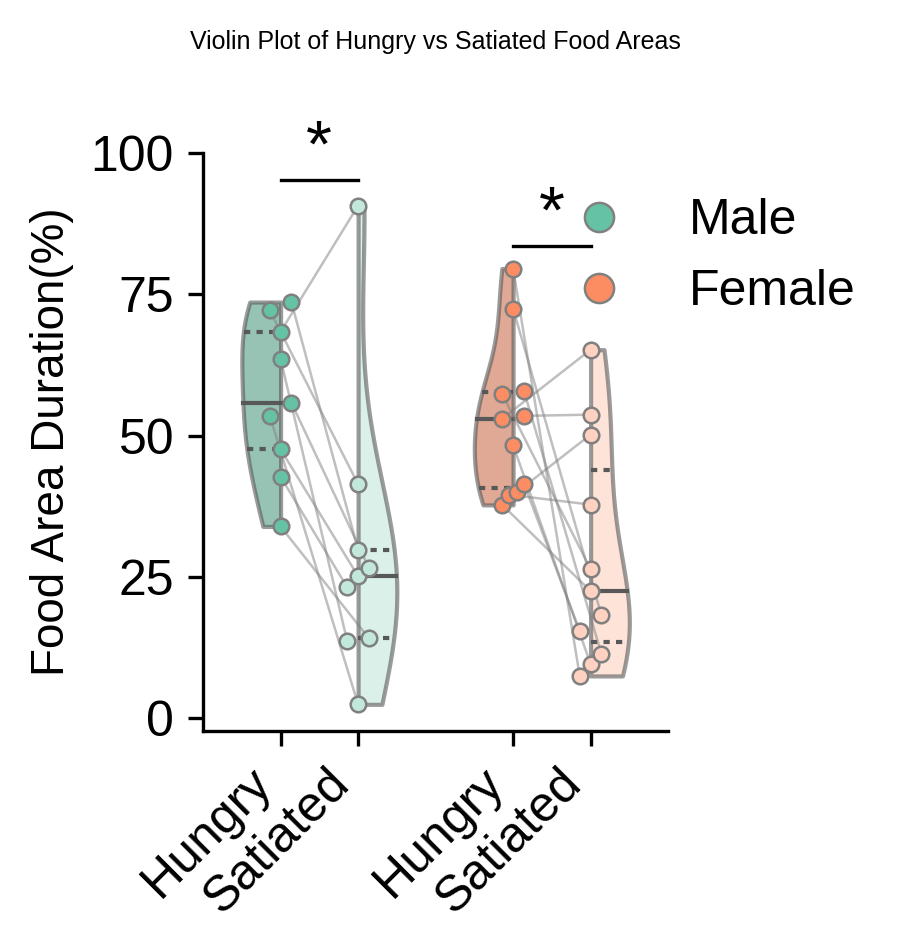

In [104]:
hungry_food_area = behavior_results_sex['hungry_food_area']
satiated_food_area = behavior_results_sex['satiated_food_area']

title = 'Violin Plot of Hungry vs Satiated Food Areas'
y_label = 'Food Area Duration(%)'
ylim = (None, 100)
figsize = (2, 2.5)

fig, ax = plt.subplots(figsize=figsize, dpi=300)

split_violin_with_dots_lines_sex(ax, hungry_food_area, satiated_food_area, 'Hungry', 'Satiated', title, y_label, ylim, label = True)

                    Mixed Linear Model Regression Results
Model:                     MixedLM        Dependent Variable:        Data     
No. Observations:          40             Method:                    REML     
No. Groups:                20             Scale:                     161.7954 
Min. group size:           2              Log-Likelihood:            -158.7905
Max. group size:           2              Converged:                 Yes      
Mean group size:           2.0                                                
------------------------------------------------------------------------------
                                   Coef.  Std.Err.   z    P>|z|  [0.025 0.975]
------------------------------------------------------------------------------
Intercept                          52.817    4.133 12.780 0.000  44.717 60.918
Sex[T.M]                            4.012    6.161  0.651 0.515  -8.063 16.087
Condition[T.Satiated]             -23.907    7.659 -3.121 0.002 -38.917 -

/work/09117/xz6783/ls6/Anaconda/envs/sklearn/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/work/09117/xz6783/ls6/Anaconda/envs/sklearn/lib/python3.11/site-packages/statsmodels/regression/mixed_linear_model.py:2201: ConvergenceWarning: Retrying MixedLM optimization with lbfgs
  warnings.warn(


                     Mixed Linear Model Regression Results
Model:                     MixedLM         Dependent Variable:         Data     
No. Observations:          40              Method:                     REML     
No. Groups:                20              Scale:                      36.1248  
Min. group size:           2               Log-Likelihood:             -142.1902
Max. group size:           2               Converged:                  Yes      
Mean group size:           2.0                                                  
--------------------------------------------------------------------------------
                                   Coef.  Std.Err.    z    P>|z|  [0.025  0.975]
--------------------------------------------------------------------------------
Intercept                          99.242    1.836  54.061 0.000  95.644 102.840
Sex[T.M]                           -2.020    2.737  -0.738 0.460  -7.384   3.343
Condition[T.Satiated]             -71.970    6.329

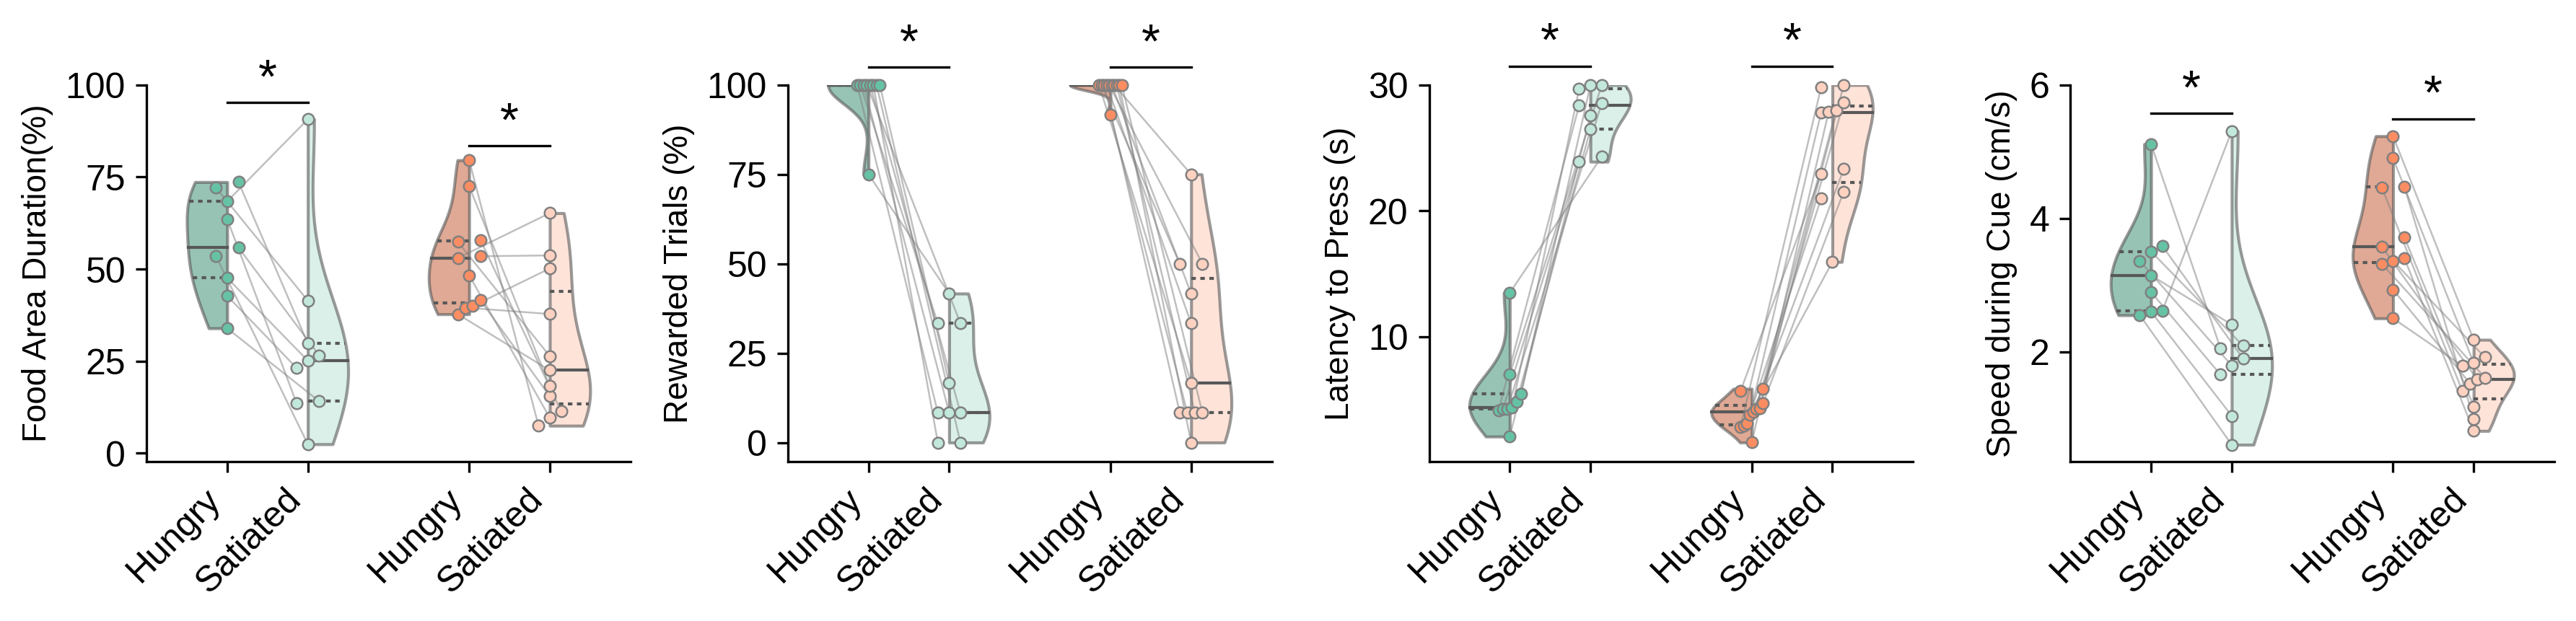

In [105]:
hungry_food_area = behavior_results_sex['hungry_food_area']
satiated_food_area = behavior_results_sex['satiated_food_area']

hungry_freezing = behavior_results_sex['hungry_freezing']
satiated_freezing = behavior_results_sex['satiated_freezing']

hungry_rewarded = behavior_results_sex['hungry_rewarded'].copy()
satiated_rewarded = behavior_results_sex['satiated_rewarded'].copy()
hungry_rewarded['Data'] = pd.DataFrame(behavior_results_sex['hungry_rewarded'].iloc[:,1:-1].mean(axis =1)*100)
satiated_rewarded['Data'] = pd.DataFrame(behavior_results_sex['satiated_rewarded'].iloc[:,1:-1].mean(axis =1)*100)

hungry_latency = behavior_results_sex['hungry_latency'].copy()
satiated_latency  = behavior_results_sex['satiated_latency'].copy()
hungry_latency['Data'] = pd.DataFrame(behavior_results_sex['hungry_latency'].iloc[:,1:-1].mean(axis =1))
satiated_latency['Data'] = pd.DataFrame(behavior_results_sex['satiated_latency'].iloc[:,1:-1].mean(axis =1))
title_splitviolin = None
figsize = (12, 3)

hungry_speed = behavior_results_sex['hungry_speed_cue'].copy()
satiated_speed  = behavior_results_sex['satiated_speed_cue'].copy()
hungry_speed['Data'] = pd.DataFrame(behavior_results_sex['hungry_speed_cue'].iloc[:,1:-1].mean(axis =1))*100
satiated_speed['Data'] = pd.DataFrame(behavior_results_sex['satiated_speed_cue'].iloc[:,1:-1].mean(axis =1))*100


y_label_food = 'Food Area Duration(%)'
y_label_speed = 'Speed during Cue (cm/s)'
y_label_speed_1s = 'Speed 1s Post-Cue (m/s)'
y_label_rewarded = 'Rewarded Trials (%)'
y_label_latency = 'Latency to Press (s)'
ylim_food = (None, 100)
ylim_hidden = (None, 100)
ylim_speed = (None, 6)
ylim_rewarded = (None, 100)
ylim_latency = (None, 30)

fig, axs = plt.subplots(1, 4, figsize=figsize, dpi=300)

split_violin_with_dots_lines_sex(axs[0], hungry_food_area, satiated_food_area, 'Hungry', 'Satiated',title_splitviolin, y_label_food, ylim_food, label = False)
split_violin_with_dots_lines_sex(axs[1], hungry_rewarded, satiated_rewarded, 'Hungry', 'Satiated',title_splitviolin, y_label_rewarded, ylim_rewarded, label = False)
split_violin_with_dots_lines_sex(axs[2], hungry_latency, satiated_latency, 'Hungry', 'Satiated',title_splitviolin, y_label_latency, ylim_latency, label = False)
split_violin_with_dots_lines_sex(axs[3], hungry_speed, satiated_speed, 'Hungry', 'Satiated',title_splitviolin, y_label_speed, ylim_speed, label = False)

plt.tight_layout()
plt.show()

In [86]:
def sex_test(group_data):
    male_data = group_data[group_data['Sex'] == 'M']['Data']
    female_data = group_data[group_data['Sex'] == 'F']['Data']

    # Check for normality in both groups
    normality_male = stats.shapiro(male_data).pvalue
    normality_female = stats.shapiro(female_data).pvalue

    # Check if both groups are normally distributed
    if normality_male > 0.05 and normality_female > 0.05:
        # Data are normally distributed, check for equal variance
        equal_var = stats.bartlett(male_data, female_data).pvalue > 0.05

        if equal_var:
            # Use Student's t-test if variances are equal
            stat, p_value = stats.ttest_ind(male_data, female_data)
        else:
            # Use Welch's t-test if variances are not equal
            stat, p_value = stats.ttest_ind(male_data, female_data, equal_var=False)
    else:
        # Data are not normally distributed, use a non-parametric test
        stat, p_value = stats.mannwhitneyu(male_data, female_data)

    return stat, p_value


    
def split_violin_with_dots_lines_condition(ax, data1, data2, data1_name, data2_name, title, y_label, ylim, label, point_size=14, line_width=0.6):
    # Combine data1 and data2 into a single DataFrame
    data1['Condition'] = data1_name
    data2['Condition'] = data2_name
    combined_data = pd.concat([data1, data2])

    # Encode categorical variables
    combined_data['Sex'] = pd.Categorical(combined_data['Sex'])
    combined_data['Condition'] = pd.Categorical(combined_data['Condition'])

    # Perform 2-way RM ANOVA using MixedLM
    model = MixedLM.from_formula("Data ~ Sex * Condition", combined_data, groups=combined_data["animal_id"], re_formula="~Condition")
    results = model.fit()
    print(results.summary())
    # Assuming 'results' is your MixedLM results object
    tables = results.summary().tables

    # The fixed effects are typically in the second table (index 1)
    fixed_effects_df = tables[1]

    # Access the p-value for the interaction term 'Sex[T.M]:Condition[T.Threat]'
    interaction_p_value = float(fixed_effects_df.iloc[3, 3])
    print("Interaction: p-value =", interaction_p_value)
    # Perform pairwise comparisons with normality check
    

    # Normality test
    normality1 = stats.shapiro(data1['Data'])
    normality2 = stats.shapiro(data1['Data'])
    print(f"Normality test results for {data1_name}: Statistics = {normality1[0]}, p-value = {normality1[1]}")
    print(f"Normality test results for {data1_name}: Statistics = {normality2[0]}, p-value = {normality2[1]}")


    data1_stat, data1_pvalue = sex_test(data1)
    data2_stat, data2_pvalue = sex_test(data2)

    # Combine p-values for Sidak correction
    p_values = [data1_pvalue, data2_pvalue]
    sidak_corrected = multipletests(p_values, method='sidak')

    # Print results
    print("Male comparison: Statistics =", data1_stat, ", Sidak corrected p-values =", sidak_corrected[1][0])
    print("Female comparison: Statistics =", data2_stat, ", Sidak corrected p-values =", sidak_corrected[1][1])
    
    # First, create a copy to manipulate for plotting
    plot_data = combined_data.copy()

    # Assign numeric x positions based on 'Sex' and 'Condition'
    plot_data.loc[(plot_data['Sex'] == 'M') & (plot_data['Condition'] == data1_name), 'PlotSex'] = 0
    plot_data.loc[(plot_data['Sex'] == 'F') & (plot_data['Condition'] == data1_name), 'PlotSex'] = 1  
    # Skip 2 for the gap
    plot_data.loc[(plot_data['Sex'] == 'M') & (plot_data['Condition'] == data2_name), 'PlotSex'] = 3
    plot_data.loc[(plot_data['Sex'] == 'F') & (plot_data['Condition'] == data2_name), 'PlotSex'] = 4
    
    # Now add the dummy category
    dummy_category = pd.DataFrame({'PlotSex': [2], 'Data': [None], 'Condition': [None], 'Sex': [None]})
    plot_data = pd.concat([plot_data, dummy_category], ignore_index=True)
    
    # Plot the violin plot with adjusted positions
    sns.violinplot(x = 'PlotSex', y='Data', hue='Condition', 
                   data=plot_data, 
                   fill=False, split=True, width=1, palette=['#2680ff', 'lightgray'],
                   linewidth=1, inner='quart', cut=0, ax=ax, dodge = 'auto')
    ax.legend().remove()
    plt.setp(ax.collections, alpha=0.6)
    
    # Manually set colors for each violin
    colors = sns.color_palette('Set2')
    for ind, violin in enumerate(ax.findobj(PolyCollection)):
        rgb = to_rgb(colors[ind % 2])
        if ind >= 2:
            rgb = 0.6 + 0.4 * np.array(rgb)  # make whiter
        else:
            rgb = 0.8 * np.array(rgb)
        violin.set_facecolor(rgb)

    #Adjust linestyle for mean
    for l in ax.lines[1::3]:
        l.set_linestyle('-')  
        
    # Adjust for offset and coordinates
    offset = 0.14
    x_coords_cond = {data1_name: 0, data2_name: 3}

    # Store coordinates for connecting lines
    coords = {}
    
    # Generate base colors from seaborn palette
    base_colors = sns.color_palette('Set2')
    sex_condition_to_color = {
        ('M', data1_name): to_rgb(base_colors[0]),  # Male Safe
        ('M', data2_name): 0.6 + 0.4 * np.array(to_rgb(base_colors[0])),  # Male Threat (lighter version)
        ('F', data1_name): to_rgb(base_colors[1]),  # Female Safe
        ('F', data2_name): 0.6 + 0.4 * np.array(to_rgb(base_colors[1]))  # Female Threat (lighter version)
    }

    # Calculate the diameter in points
    diameter_points = 2 * sqrt(point_size / pi)
    actual_ylim = ax.get_ylim()
    
    # Convert diameter to inches
    diameter_inches = diameter_points / 72

    # Get the height of the axes in inches
    bbox = ax.get_window_extent().transformed(fig.dpi_scale_trans.inverted())
    axes_height_inches = bbox.height

    # Get the conversion factor from inches to data units
    y_range = ylim[1] - actual_ylim[0]
    conversion_factor = y_range / axes_height_inches

    # Convert diameter from points to data units
    diameter_data_units = diameter_inches * conversion_factor
    
    # Process each sex and condition combination
    for (sex, condition), group_data in combined_data.groupby(['Sex', 'Condition']):
        grouped_values = group_values_with_indices(group_data['Data'].values, diameter_data_units)
        scatter_color = sex_condition_to_color[(sex, condition)]

        for group, indices in grouped_values:
            x_coords = generate_symmetric_points(x_coords_cond[condition] + (0 if sex == 'M' else 1), offset, len(group))
            
            for i, idx in enumerate(indices):
                original_idx = group_data.iloc[idx].name  # Correct index from group_data
                x_coord = x_coords[i]
                y_value = group_data.loc[original_idx, 'Data']

                # Store the coordinates for lines
                coords[(original_idx, sex, condition)] = (x_coord, y_value)

                # Plot the individual scatter points
                color = '#2680ff' if condition == data1_name else '#ff310d'
                ax.scatter(x_coord, y_value, color=scatter_color, edgecolors='gray', alpha=1, clip_on=False, s=point_size, lw=line_width, zorder=3)

#     # Draw connecting lines using stored coordinates
#     for animal_id in combined_data['animal_id'].unique():
#         animal_data = combined_data[combined_data['animal_id'] == animal_id]
#         for sex in ['M', 'F']:
#             safe_key = next((key for key in coords if key[0] in animal_data.index and key[1] == sex and key[2] == 'Safe'), None)
#             threat_key = next((key for key in coords if key[0] in animal_data.index and key[1] == sex and key[2] == 'Threat'), None)
#             if safe_key and threat_key:
#                 safe_coord = coords[safe_key]
#                 threat_coord = coords[threat_key]
#                 ax.plot([safe_coord[0], threat_coord[0]], [safe_coord[1], threat_coord[1]], 
#                         color='gray', alpha=0.5, linewidth=line_width)
  
    x_coords_cond = {data1_name: [0, 1], data2_name: [3, 4]}  # X positions for Safe and Threat for each sex
    y_max = min(combined_data['Data'].max()*1.05, ylim[1]*1.05)
    
    # Check for significance and annotate for data1 and data2
    for condition, p_value in zip([data1_name, data2_name], sidak_corrected[1]):
        if p_value < 0.05:
            x_coords = x_coords_cond[condition]
            # Draw lines for significance
            ax.plot([x_coords[0], x_coords[0], x_coords[1], x_coords[1]], [y_max, y_max, y_max, y_max], lw=0.8, c='k', clip_on=False)
            # Add asterisk for significance
            ax.text((x_coords[0] + x_coords[1]) / 2, y_max, "*", ha='center', va='bottom', color='k', fontsize=16)

    
    # Creating scatter points for the legend
    sex_safe_color = {
        'M': to_rgb(base_colors[0]),  # Male Safe
        'F': to_rgb(base_colors[1])   # Female Safe
    }

    # Customize the plot
    # Create custom legend handles
    legend_handles = [
        mlines.Line2D([], [], color=sex_safe_color['M'], marker='o', linestyle='None', markersize=point_size, label='Male', mec = 'gray', markeredgewidth=line_width),
        mlines.Line2D([], [], color=sex_safe_color['F'], marker='o', linestyle='None', markersize=point_size, label='Female', mec = 'gray', markeredgewidth=line_width)
    ]
    
    # Add the custom legend to the plot
    if label:
        ax.legend(handles=legend_handles, loc='upper right', frameon=False, markerscale = 0.5, fontsize = 8, bbox_to_anchor=(1.3, 1))
    ax.set_xticks([0.5, 3.5])
    ax.set_xticklabels([data1_name, data2_name], fontsize=8, rotation=45, ha='right')
    ax.set_xlabel(None)
    ax.set_title(title, fontsize=6, pad = 25)
    ax.set_ylabel(y_label, fontsize=11)
    ax.set_ylim(*ylim)
    ax.tick_params(axis = 'x', labelsize=12)
    ax.tick_params(axis = 'y', labelsize=12)
    sns.despine() 
    ax.margins(x=0.1)



                    Mixed Linear Model Regression Results
Model:                     MixedLM        Dependent Variable:        Data     
No. Observations:          40             Method:                    REML     
No. Groups:                20             Scale:                     161.7954 
Min. group size:           2              Log-Likelihood:            -158.7905
Max. group size:           2              Converged:                 Yes      
Mean group size:           2.0                                                
------------------------------------------------------------------------------
                                   Coef.  Std.Err.   z    P>|z|  [0.025 0.975]
------------------------------------------------------------------------------
Intercept                          52.817    4.133 12.780 0.000  44.717 60.918
Sex[T.M]                            4.012    6.161  0.651 0.515  -8.063 16.087
Condition[T.Satiated]             -23.907    7.659 -3.121 0.002 -38.917 -

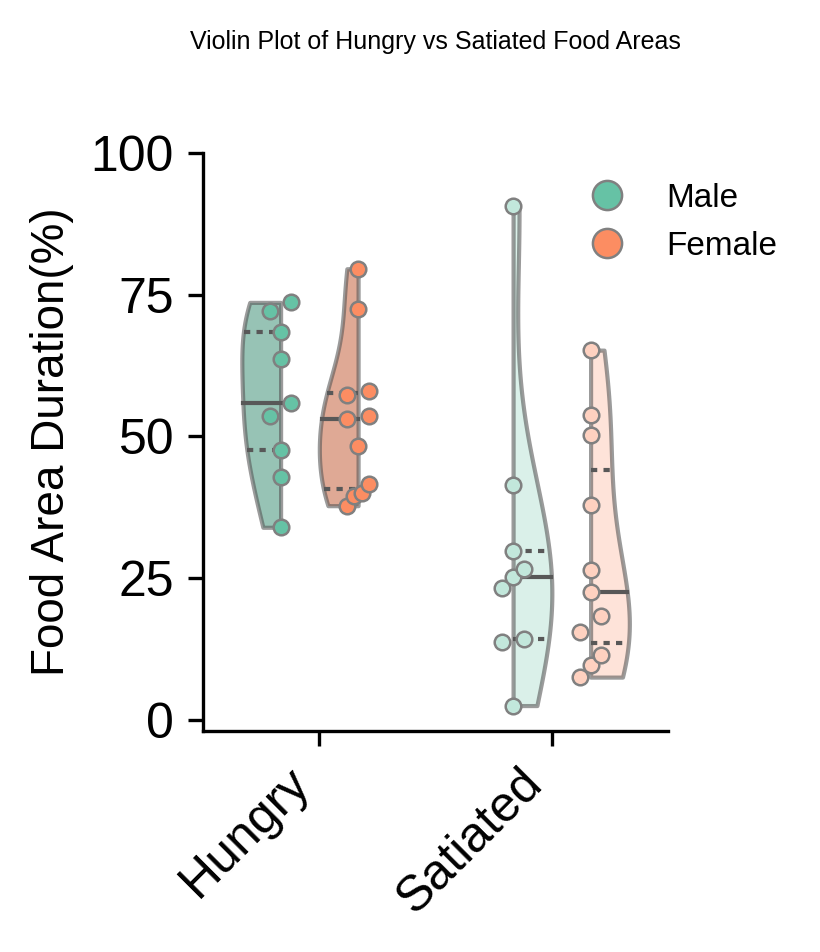

In [87]:

hungry_food_area = behavior_results_sex['hungry_food_area']
satiated_food_area = behavior_results_sex['satiated_food_area']

title = 'Violin Plot of Hungry vs Satiated Food Areas'
y_label = 'Food Area Duration(%)'
ylim = (None, 100)
figsize = (2, 2.5)

fig, ax = plt.subplots(figsize=figsize, dpi=300)

split_violin_with_dots_lines_condition(ax, hungry_food_area, satiated_food_area, 'Hungry', 'Satiated', title, y_label, ylim, label = True)

                    Mixed Linear Model Regression Results
Model:                     MixedLM        Dependent Variable:        Data     
No. Observations:          40             Method:                    REML     
No. Groups:                20             Scale:                     161.7954 
Min. group size:           2              Log-Likelihood:            -158.7905
Max. group size:           2              Converged:                 Yes      
Mean group size:           2.0                                                
------------------------------------------------------------------------------
                                   Coef.  Std.Err.   z    P>|z|  [0.025 0.975]
------------------------------------------------------------------------------
Intercept                          52.817    4.133 12.780 0.000  44.717 60.918
Sex[T.M]                            4.012    6.161  0.651 0.515  -8.063 16.087
Condition[T.Satiated]             -23.907    7.659 -3.121 0.002 -38.917 -

/work/09117/xz6783/ls6/Anaconda/envs/sklearn/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/work/09117/xz6783/ls6/Anaconda/envs/sklearn/lib/python3.11/site-packages/statsmodels/regression/mixed_linear_model.py:2201: ConvergenceWarning: Retrying MixedLM optimization with lbfgs
  warnings.warn(
/work/09117/xz6783/ls6/Anaconda/envs/sklearn/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/work/09117/xz6783/ls6/Anaconda/envs/sklearn/lib/python3.11/site-packages/statsmodels/regression/mixed_linear_model.py:2201: ConvergenceWarning: Retrying MixedLM optimization with cg
  warnings.warn(
/work/09117/xz6783/ls6/Anaconda/envs/sklearn/lib/python3.11/site-packages/statsmodels

                   Mixed Linear Model Regression Results
Model:                   MixedLM        Dependent Variable:        Data     
No. Observations:        40             Method:                    REML     
No. Groups:              20             Scale:                     4.2100   
Min. group size:         2              Log-Likelihood:            -101.0354
Max. group size:         2              Converged:                 No       
Mean group size:         2.0                                                
----------------------------------------------------------------------------
                                  Coef.  Std.Err.   z    P>|z| [0.025 0.975]
----------------------------------------------------------------------------
Intercept                          0.948    0.624  1.520 0.129 -0.275  2.171
Sex[T.M]                          -0.085    0.930 -0.091 0.927 -1.908  1.738
Condition[T.Satiated]              7.279    1.941  3.750 0.000  3.474 11.084
Sex[T.M]:Condition[

/work/09117/xz6783/ls6/Anaconda/envs/sklearn/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/work/09117/xz6783/ls6/Anaconda/envs/sklearn/lib/python3.11/site-packages/statsmodels/regression/mixed_linear_model.py:2201: ConvergenceWarning: Retrying MixedLM optimization with lbfgs
  warnings.warn(


                     Mixed Linear Model Regression Results
Model:                     MixedLM         Dependent Variable:         Data     
No. Observations:          40              Method:                     REML     
No. Groups:                20              Scale:                      36.1248  
Min. group size:           2               Log-Likelihood:             -142.1902
Max. group size:           2               Converged:                  Yes      
Mean group size:           2.0                                                  
--------------------------------------------------------------------------------
                                   Coef.  Std.Err.    z    P>|z|  [0.025  0.975]
--------------------------------------------------------------------------------
Intercept                          99.242    1.836  54.061 0.000  95.644 102.840
Sex[T.M]                           -2.020    2.737  -0.738 0.460  -7.384   3.343
Condition[T.Satiated]             -71.970    6.329

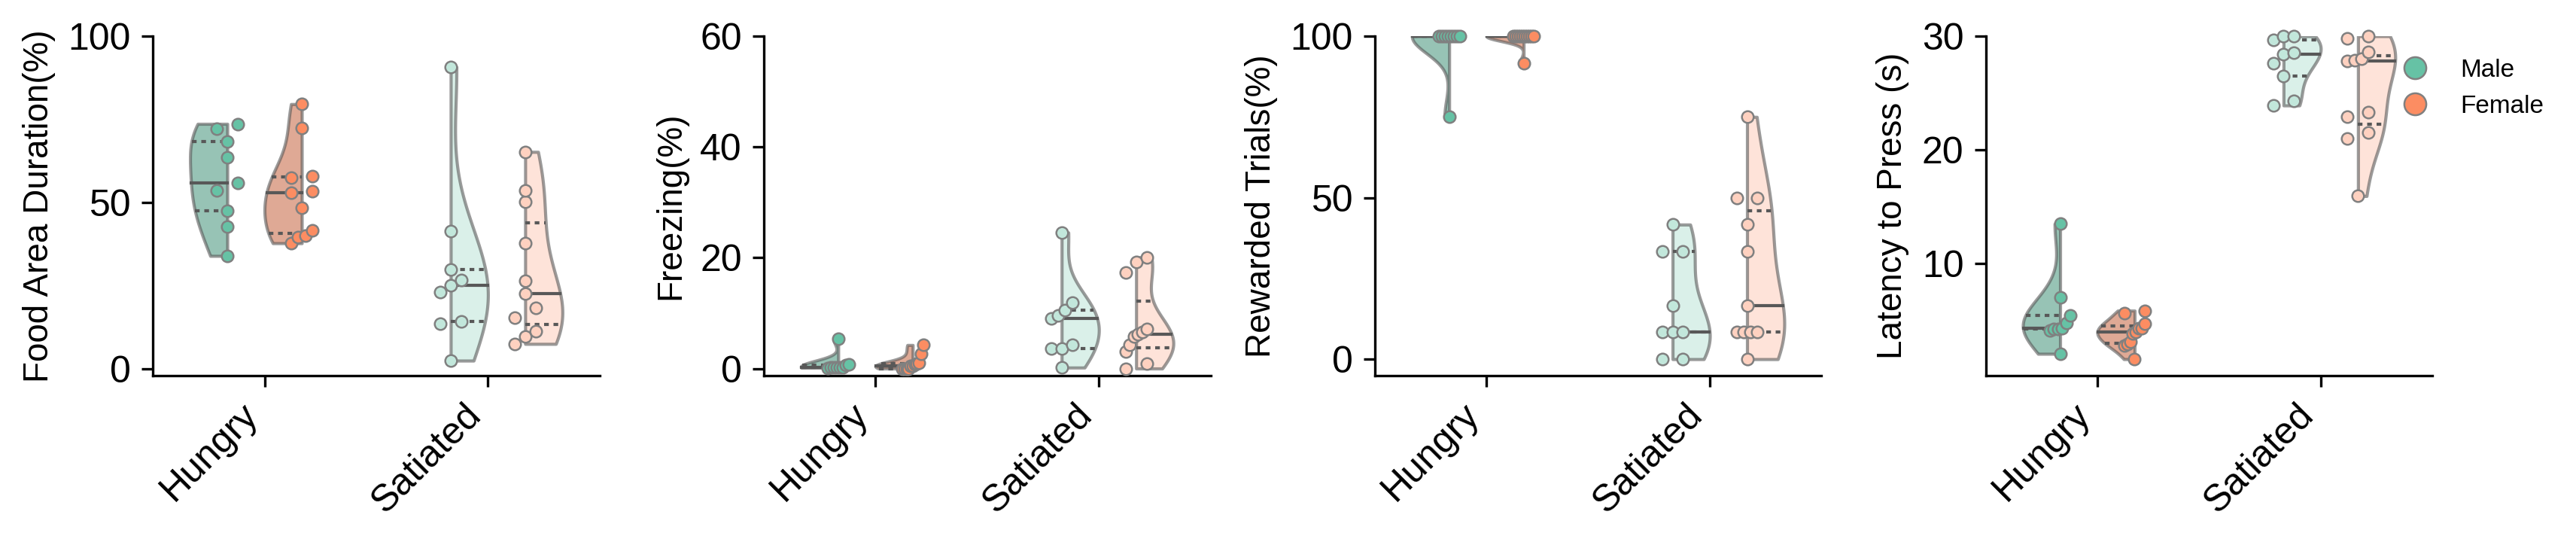

In [31]:
hungry_food_area = behavior_results_sex['hungry_food_area']
satiated_food_area = behavior_results_sex['satiated_food_area']

hungry_freezing = behavior_results_sex['hungry_freezing']
satiated_freezing = behavior_results_sex['satiated_freezing']

hungry_rewarded = behavior_results_sex['hungry_rewarded'].copy()
satiated_rewarded = behavior_results_sex['satiated_rewarded'].copy()
hungry_rewarded['Data'] = pd.DataFrame(behavior_results_sex['hungry_rewarded'].iloc[:,1:-1].mean(axis =1)*100)
satiated_rewarded['Data'] = pd.DataFrame(behavior_results_sex['satiated_rewarded'].iloc[:,1:-1].mean(axis =1)*100)

hungry_latency = behavior_results_sex['hungry_latency'].copy()
satiated_latency  = behavior_results_sex['satiated_latency'].copy()
hungry_latency['Data'] = pd.DataFrame(behavior_results_sex['hungry_latency'].iloc[:,1:-1].mean(axis =1))
satiated_latency['Data'] = pd.DataFrame(behavior_results_sex['satiated_latency'].iloc[:,1:-1].mean(axis =1))
title_splitviolin = None
figsize = (11.5, 2.5) 

y_label_food = 'Food Area Duration(%)'
y_label_freezing = 'Freezing(%)'
y_label_rewarded = 'Rewarded Trials(%)'
y_label_latency = 'Latency to Press (s)'
ylim_food = (None, 100)
ylim_hidden = (None, 100)
ylim_freezing = (None, 60)
ylim_rewarded = (None, 100)
ylim_latency = (None, 30)

fig, axs = plt.subplots(1, 4, figsize=figsize, dpi=300)

split_violin_with_dots_lines_condition(axs[0], hungry_food_area, satiated_food_area, 'Hungry', 'Satiated',title_splitviolin, y_label_food, ylim_food, label = False)
split_violin_with_dots_lines_condition(axs[1], hungry_freezing, satiated_freezing, 'Hungry', 'Satiated',title_splitviolin, y_label_freezing, ylim_freezing, label = False)
split_violin_with_dots_lines_condition(axs[2], hungry_rewarded, satiated_rewarded, 'Hungry', 'Satiated',title_splitviolin, y_label_rewarded, ylim_rewarded, label = False)
split_violin_with_dots_lines_condition(axs[3], hungry_latency, satiated_latency, 'Hungry', 'Satiated',title_splitviolin, y_label_latency, ylim_latency, label = True)

plt.tight_layout()
plt.show()

In [32]:
satiated_rewarded

animal_id  Cue 1  Cue 2  Cue 3  Cue 4  Cue 5  Cue 6  Cue 7  Cue 8  Cue 9  \
0        9M6   True  False  False  False   True  False  False  False  False   
1        7H6   True  False   True  False   True  False   True   True  False   
2        2N6  False   True  False  False   True  False   True   True  False   
3        6H6  False  False  False  False  False  False   True  False  False   
4        2I5  False  False  False  False  False  False   True  False  False   
5        8H6  False  False  False  False  False  False  False  False   True   
6        1H6  False  False  False  False  False  False   True  False  False   
7        6S5   True   True   True  False  False  False  False  False   True   
8        8S5  False  False  False  False  False   True  False  False  False   
9        7M6  False   True  False  False  False   True  False   True  False   
10       6M6  False  False  False  False   True   True  False  False  False   
11       5B6   True   True  False   True  False  False   True   True   True   
12       1S5  False  False  False  False  False  False   True  False  False   
13       2S5  False  False   True  False  False  False  False  False  False   
14       2Z4  False  False  False  False  False  False  False  False  False   
15       4N6  False  False  False  False  False  False  False  False  False   
16       7B6  False  False  False  False  False  False  False  False  False   
17       4B6  False  False  False  False  False  False  False  False  False   
18       1I5  False  False   True   True  False  False  False  False  False   
19       1B6   True  False  False  False  False  False  False  False  False   

    Cue 10  Cue 11  Cue 12 Sex       Data Condition  
0    False   False   False   F  16.666667  Satiated  
1     True   False   False   F  50.000000  Satiated  
2    False    True   False   M  41.666667  Satiated  
3    False   False   False   F   8.333333  Satiated  
4    False   False   False   M   8.333333  Satiated  
5     True    True    True   F  33.333333  Satiated  
6    False   False   False   F   8.333333  Satiated  
7    False   False   False   M  33.333333  Satiated  
8    False   False   False   M   8.333333  Satiated  
9     True    True    True   F  50.000000  Satiated  
10    True    True    True   F  41.666667  Satiated  
11    True    True    True   F  75.000000  Satiated  
12    True    True    True   M  33.333333  Satiated  
13   False   False   False   M   8.333333  Satiated  
14   False   False   False   M   0.000000  Satiated  
15   False   False   False   M   0.000000  Satiated  
16   False   False    True   F   8.333333  Satiated  
17   False   False   False   F   0.000000  Satiated  
18   False   False   False   M  16.666667  Satiated  
19   False   False   False   F   8.333333  Satiated

In [33]:
# Check if each combination of 'animal_id', 'Condition', and 'Sex' has the same number of observations
balance_check = combined_data.groupby(['animal_id', 'Condition', 'Sex']).size()
print(balance_check)

# Check if all groups have the same size
if balance_check.nunique() == 1:
    print("Data is balanced.")
else:
    print("Data is unbalanced.")


NameError: name 'combined_data' is not defined

In [ ]:
# Preparing the data: we need to encode the categorical variables
combined_data['Sex'] = pd.Categorical(combined_data['Sex'])
combined_data['Condition'] = pd.Categorical(combined_data['Condition'])

# Setting up the MixedLM model
model = mixedlm("Data ~ Sex * Condition", combined_data, groups=combined_data["animal_id"], re_formula="~Condition")

# Fitting the model
results = model.fit()
print(results.summary())


In [ ]:
# Assuming 'results' is your MixedLM results object
tables = results.summary().tables

# The fixed effects are typically in the second table (index 1)
fixed_effects_df = tables[1]

# Access the p-value for the interaction term 'Sex[T.M]:Condition[T.Threat]'
interaction_p_value = float(fixed_effects_df.loc['Sex[T.M]:Condition[T.Threat]', 'P>|z|'])

print("P-value for the interaction term (Sex * Condition):", interaction_p_value)

In [ ]:
float(fixed_effects_df.loc['Sex[T.M]:Condition[T.Threat]', 'P>|z|'])

In [ ]:
fixed_effects_df

In [ ]:
# Split the data by Sex
male_data = combined_data[combined_data['Sex'] == 'M']
female_data = combined_data[combined_data['Sex'] == 'F']

# Perform pairwise comparisons for each sex with normality check
def perform_test(group_data):
    safe_data = group_data[group_data['Condition'] == 'Safe']['Data']
    threat_data = group_data[group_data['Condition'] == 'Threat']['Data']

    # Check for normality
    normality_safe = stats.shapiro(safe_data)
    normality_threat = stats.shapiro(threat_data)

    # Decide between paired t-test and Wilcoxon test
    if normality_safe[1] > 0.05 and normality_threat[1] > 0.05:
        # Data are normally distributed, perform paired t-test
        stat, p_value = stats.ttest_rel(safe_data, threat_data)
    else:
        # Data are not normally distributed, perform Wilcoxon signed-rank test
        stat, p_value = stats.wilcoxon(safe_data, threat_data)
    
    return stat, p_value

male_stat, male_pvalue = perform_test(male_data)
female_stat, female_pvalue = perform_test(female_data)

# Combine p-values for Sidak correction
p_values = [male_pvalue, female_pvalue]
sidak_corrected = multipletests(p_values, method='sidak')

# Print results
print("Male comparison: Statistics =", male_stat, ", p-value =", male_pvalue)
print("Female comparison: Statistics =", female_stat, ", p-value =", female_pvalue)
print("Sidak corrected p-values:", sidak_corrected[1])


In [ ]:
safe_food_area = behavior_results['safe_food_area']['Data']
threat_food_area = behavior_results['threat_food_area']['Data']
title = 'Box Plot of Safe vs Threat Food Areas'
y_label = 'Food Area Duration(%)'
ylim = (None, 100)
figsize = (2, 2.5)

fig, ax = plt.subplots(figsize=figsize, dpi=300)

boxplot_with_lines(ax, safe_food_area, threat_food_area, 'Safe', 'Threat',title, y_label, ylim)

In [ ]:
safe_food_area = behavior_results['safe_food_area']['Data']
threat_food_area = behavior_results['threat_food_area']['Data']
title = 'Scatter Plot of Safe vs Threat Food Areas'
y_label = 'Food Area Duration(%)'
ylim = (None, 100)
scatterplot_with_lines(safe_food_area, threat_food_area, 'Safe', 'Threat',title, y_label, ylim)

In [ ]:
safe_food_area = behavior_results['safe_food_area']['Data']
threat_food_area = behavior_results['threat_food_area']['Data']
title = 'Violin Plot of Safe vs Threat Food Areas'
y_label = 'Food Area Duration(%)'
ylim = (None, 100)
violinplot_with_dots_lines(safe_food_area, threat_food_area, 'Safe', 'Threat',title, y_label, ylim)

In [ ]:
safe_food_area = behavior_results['safe_food_area']['Data']
threat_food_area = behavior_results['threat_food_area']['Data']
title = 'Violin Plot of Safe vs Threat Food Areas'
y_label = 'Food Area Duration(%)'
ylim = (None, 100)
split_violin_with_dots_lines(safe_food_area, threat_food_area, 'Safe', 'Threat',title, y_label, ylim)

## Clustering

In [106]:
hungry_food_area = behavior_results_sex['hungry_food_area'].Data
satiated_food_area = behavior_results_sex['satiated_food_area'].Data

hungry_freezing = behavior_results_sex['hungry_freezing'].Data
satiated_freezing = behavior_results_sex['satiated_freezing'].Data

hungry_rewarded = behavior_results_sex['hungry_rewarded'].iloc[:,1:-1].mean(axis =1)*100
satiated_rewarded = behavior_results_sex['satiated_rewarded'].iloc[:,1:-1].mean(axis =1)*100


hungry_latency = behavior_results_sex['hungry_latency'].iloc[:,1:-1].mean(axis =1)
satiated_latency = behavior_results_sex['satiated_latency'].iloc[:,1:-1].mean(axis =1)

hungry_speed = behavior_results_sex['hungry_speed_cue'].iloc[:,1:-1].mean(axis =1)
satiated_speed  = behavior_results_sex['satiated_speed_cue'].iloc[:,1:-1].mean(axis =1)



In [107]:
cluster_data = pd.concat([hungry_food_area, satiated_food_area, hungry_rewarded,satiated_rewarded,hungry_latency,satiated_latency, hungry_speed, satiated_speed, hungry_freezing, satiated_freezing], axis =1)
cluster_data.columns = ['hungry_food_area','satiated_food_area','hungry_rewarded','satiated_rewarded','hungry_latency','satiated_latency', 'hungry_speed','satiated_speed', 'hungry_freezing', 'satiated_freezing']
# cluster_data = pd.concat([hungry_food_area, satiated_food_area, hungry_rewarded,satiated_rewarded,hungry_latency,satiated_latency, hungry_speed, satiated_speed, hungry], axis =1)
# cluster_data.columns = ['hungry_food_area','satiated_food_area','hungry_rewarded','satiated_rewarded','hungry_latency','satiated_latency', 'hungry_speed','satiated_speed', 'hungry_freezing', 'satiated_freezing']

In [108]:
cluster_data

hungry_food_area  satiated_food_area  hungry_rewarded  satiated_rewarded  \
0          41.518805           15.471462       100.000000          16.666667   
1          53.503023           53.721896       100.000000          50.000000   
2          47.596740           25.134012        75.000000          41.666667   
3          48.313549            9.625053       100.000000           8.333333   
4          53.570192            2.472685       100.000000           8.333333   
5          57.380288           26.369736       100.000000          33.333333   
6          37.755046           22.520833        91.666667           8.333333   
7          73.639557           29.792574       100.000000          33.333333   
8          55.831376           26.598494       100.000000           8.333333   
9          39.985104           50.193153       100.000000          50.000000   
10         39.546341           37.809007       100.000000          41.666667   
11         53.000692           65.210683       100.000000          75.000000   
12         68.389727           90.696211       100.000000          33.333333   
13         72.162251           41.428794       100.000000           8.333333   
14         42.746227           23.174042       100.000000           0.000000   
15         63.585689           13.638904       100.000000           0.000000   
16         72.486439           18.215726       100.000000           8.333333   
17         57.927111           11.387919       100.000000           0.000000   
18         33.941760           14.138866       100.000000          16.666667   
19         79.575693            7.494686       100.000000           8.333333   

    hungry_latency  satiated_latency  hungry_speed  satiated_speed  \
0         2.824917         29.805667      0.037186        0.011785   
1         4.711000         21.522750      0.029317        0.015261   
2        13.490500         24.307917      0.035027        0.020905   
3         1.602833         27.861417      0.044772        0.009924   
4         4.285667         28.564083      0.025482        0.006062   
5         4.023667         23.316833      0.033206        0.016110   
6         5.869167         28.627250      0.034021        0.008131   
7         4.276000         23.907417      0.033628        0.017934   
8         4.131250         28.389500      0.051138        0.020538   
9         5.669583         22.938583      0.033623        0.019163   
10        3.107000         20.975417      0.049013        0.018308   
11        2.936917         15.942500      0.052328        0.021797   
12        4.812667         26.499500      0.026133        0.053081   
13        4.355083         29.686333      0.026003        0.010395   
14        5.455667         30.000000      0.031441        0.024061   
15        7.016583         30.000000      0.028956        0.016571   
16        4.290417         27.990833      0.035776        0.015815   
17        4.336250         30.000000      0.044664        0.014084   
18        2.072167         27.586833      0.035861        0.018988   
19        3.829250         27.806833      0.025009        0.017869   

    hungry_freezing  satiated_freezing  
0          0.859478          20.075338  
1          0.713835           4.300952  
2          0.170256           9.594337  
3          2.681116          17.376971  
4          0.564180          24.551372  
5          0.420504           3.048821  
6          4.237782          19.194430  
7          0.137429           3.640556  
8          0.188704           0.166431  
9          0.000000           0.872621  
10         0.000000           7.072777  
11         0.994846           0.000000  
12         0.147676           3.669461  
13         5.384858          10.515191  
14         0.683076           4.341525  
15         0.252428           9.004408  
16         0.000000           5.750215  
17         0.520889           6.571046  
18         0.239986          11.849237  
19         0.000000           6.

In [109]:
# Check for missing values in the relevant columns
missing_values = cluster_data.isnull().sum()

# Standardizing the data (if there are no missing values)
if missing_values.sum() == 0:
    scaler = StandardScaler()
    data_scaled = scaler.fit_transform(cluster_data)
else:
    data_scaled = None

In [110]:
data_scaled.shape

(20, 10)

Number of PCs = 10
Number of PCs to keep = 3


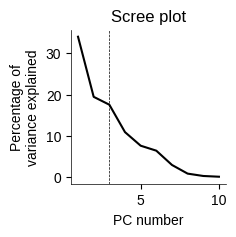

In [111]:
pca = PCA(n_components=data_scaled.shape[1])
df_pca = pca.fit_transform(data_scaled)
pca_vectors = pca.components_
print ('Number of PCs = %d'%(pca_vectors.shape[0]))

x = 100*pca.explained_variance_ratio_
xprime = x - (x[0] + (x[-1]-x[0])/(x.size-1)*np.arange(x.size))
num_retained_pcs = np.argmin(xprime)
numcols = 3.0

print ('Number of PCs to keep = %d'%(num_retained_pcs))


fig, ax = plt.subplots(figsize=(2,2))
ax.plot(np.arange(pca.explained_variance_ratio_.shape[0]).astype(int)+1, x, 'k')
ax.set_ylabel('Percentage of\nvariance explained')
ax.set_xlabel('PC number')
ax.axvline(num_retained_pcs, linestyle='--', color='k', linewidth=0.5)
ax.set_title('Scree plot')
#ax.set_xlim([0,5])
[i.set_linewidth(0.5) for i in ax.spines.values()]
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)


In [112]:
# PCA for dimensionality reduction
pca = PCA(n_components=3)
df_pca = pca.fit_transform(data_scaled)

# Various clustering algorithms
algorithms = {
    'KMeans': KMeans(n_clusters=2),
    'AgglomerativeClustering': AgglomerativeClustering(n_clusters=2),
    'DBSCAN': DBSCAN(eps=0.5, min_samples=5),
    'MeanShift': MeanShift(),
    'GaussianMixture': GaussianMixture(n_components=2),
    'SpectralClustering': SpectralClustering(n_clusters=2, affinity='nearest_neighbors'),
    'AffinityPropagation': AffinityPropagation()
}

# Dictionary to store the silhouette scores for each algorithm
silhouette_scores = {}

# Apply each clustering algorithm and calculate silhouette scores
for name, algorithm in algorithms.items():
    # Special case for GaussianMixture, which uses 'predict' instead of 'fit_predict'
    if name == 'GaussianMixture':
        algorithm.fit(df_pca)
        labels = algorithm.predict(df_pca)
    elif name == 'SpectralClustering':
        # Spectral Clustering may require the affinity matrix to be precomputed
        try:
            labels = algorithm.fit_predict(df_pca)
        except:
            algorithm = SpectralClustering(n_clusters=2, affinity='rbf')
            labels = algorithm.fit_predict(df_pca)
    else:
        labels = algorithm.fit_predict(df_pca)

    # Calculate the silhouette score and store it
    score = silhouette_score(df_pca, labels) if len(set(labels)) > 1 else float('-inf')  # avoid error if only one cluster is found
    silhouette_scores[name] = score

# Return the silhouette scores for comparison
silhouette_scores


/work/09117/xz6783/ls6/Anaconda/envs/sklearn/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


{'KMeans': 0.3404363527904354,
 'AgglomerativeClustering': 0.33390048096071484,
 'DBSCAN': -inf,
 'MeanShift': 0.34048156287454123,
 'GaussianMixture': 0.22420484509892824,
 'SpectralClustering': 0.33390048096071484,
 'AffinityPropagation': 0.3169953286937809}

In [113]:
# PCA for dimensionality reduction
pca = PCA(n_components=3)
df_pca = pca.fit_transform(data_scaled)

# Various clustering algorithms
algorithms = {
    'KMeans': KMeans(n_clusters=2),
    'AgglomerativeClustering': AgglomerativeClustering(n_clusters=2),
    'DBSCAN': DBSCAN(eps=0.5, min_samples=5),
    'MeanShift': MeanShift(),
    'GaussianMixture': GaussianMixture(n_components=2),
    'SpectralClustering': SpectralClustering(n_clusters=2, affinity='nearest_neighbors'),
    'AffinityPropagation': AffinityPropagation()
}

# Dictionary to store the silhouette scores for each algorithm
silhouette_scores = {}

# Apply each clustering algorithm and calculate silhouette scores
for name, algorithm in algorithms.items():
    # Special case for GaussianMixture, which uses 'predict' instead of 'fit_predict'
    if name == 'GaussianMixture':
        algorithm.fit(data_scaled)
        labels = algorithm.predict(data_scaled)
    elif name == 'SpectralClustering':
        # Spectral Clustering may require the affinity matrix to be precomputed
        try:
            labels = algorithm.fit_predict(data_scaled)
        except:
            algorithm = SpectralClustering(n_clusters=2, affinity='rbf')
            labels = algorithm.fit_predict(data_scaled)
    else:
        labels = algorithm.fit_predict(data_scaled)

    # Calculate the silhouette score and store it
    score = silhouette_score(data_scaled, labels) if len(set(labels)) > 1 else float('-inf')  # avoid error if only one cluster is found
    silhouette_scores[name] = score

# Return the silhouette scores for comparison
silhouette_scores


/work/09117/xz6783/ls6/Anaconda/envs/sklearn/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


{'KMeans': 0.2305557763154714,
 'AgglomerativeClustering': 0.2305557763154714,
 'DBSCAN': -inf,
 'MeanShift': 0.19964695795655515,
 'GaussianMixture': 0.21067940568358207,
 'SpectralClustering': 0.21067940568358207,
 'AffinityPropagation': 0.21309080713938489}

/work/09117/xz6783/ls6/Anaconda/envs/sklearn/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/work/09117/xz6783/ls6/Anaconda/envs/sklearn/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/work/09117/xz6783/ls6/Anaconda/envs/sklearn/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/work/09117/xz6783/ls6/Anaconda/envs/sklearn/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the va

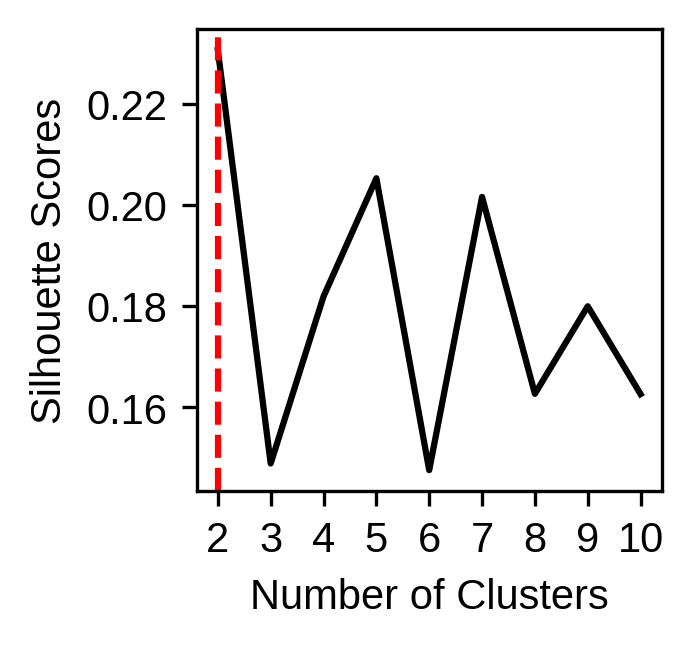

In [114]:
# Assuming 'data_scaled_combined' is your scaled dataset
silhouette_list = []
range_of_clusters = range(2, 11)  

for num_clusters in range_of_clusters:
    kmeans = KMeans(n_clusters=num_clusters, random_state=10)
    kmeans.fit(data_scaled)
    silhouette_list.append(silhouette_score(data_scaled, kmeans.labels_))
    
max_point = np.argmax(silhouette_list)+2
# Now let's plot the elbow plot with the elbow point marked
plt.figure(figsize=(2, 2), dpi = 300)
plt.plot(range_of_clusters, silhouette_list, c = 'black')
# plt.title('Silhouette Scores for K-means Clustering')
plt.xlabel('Number of Clusters')
plt.ylabel('Silhouette Scores')
plt.xticks(range_of_clusters)
plt.axvline(x=max_point, color='red', linestyle='--')
plt.show()

/work/09117/xz6783/ls6/Anaconda/envs/sklearn/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/work/09117/xz6783/ls6/Anaconda/envs/sklearn/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/work/09117/xz6783/ls6/Anaconda/envs/sklearn/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/work/09117/xz6783/ls6/Anaconda/envs/sklearn/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the va

For n_clusters = 2, the average silhouette_score is : 0.2305557763154714
For n_clusters = 3, the average silhouette_score is : 0.1488990321977658
For n_clusters = 4, the average silhouette_score is : 0.18189775246227058
For n_clusters = 5, the average silhouette_score is : 0.2052548790163395
For n_clusters = 6, the average silhouette_score is : 0.14758418401622425


/work/09117/xz6783/ls6/Anaconda/envs/sklearn/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/work/09117/xz6783/ls6/Anaconda/envs/sklearn/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/work/09117/xz6783/ls6/Anaconda/envs/sklearn/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/work/09117/xz6783/ls6/Anaconda/envs/sklearn/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the va

For n_clusters = 7, the average silhouette_score is : 0.201568859844682
For n_clusters = 8, the average silhouette_score is : 0.16266923403515599
For n_clusters = 9, the average silhouette_score is : 0.17996652222275017
For n_clusters = 10, the average silhouette_score is : 0.1626057756151536


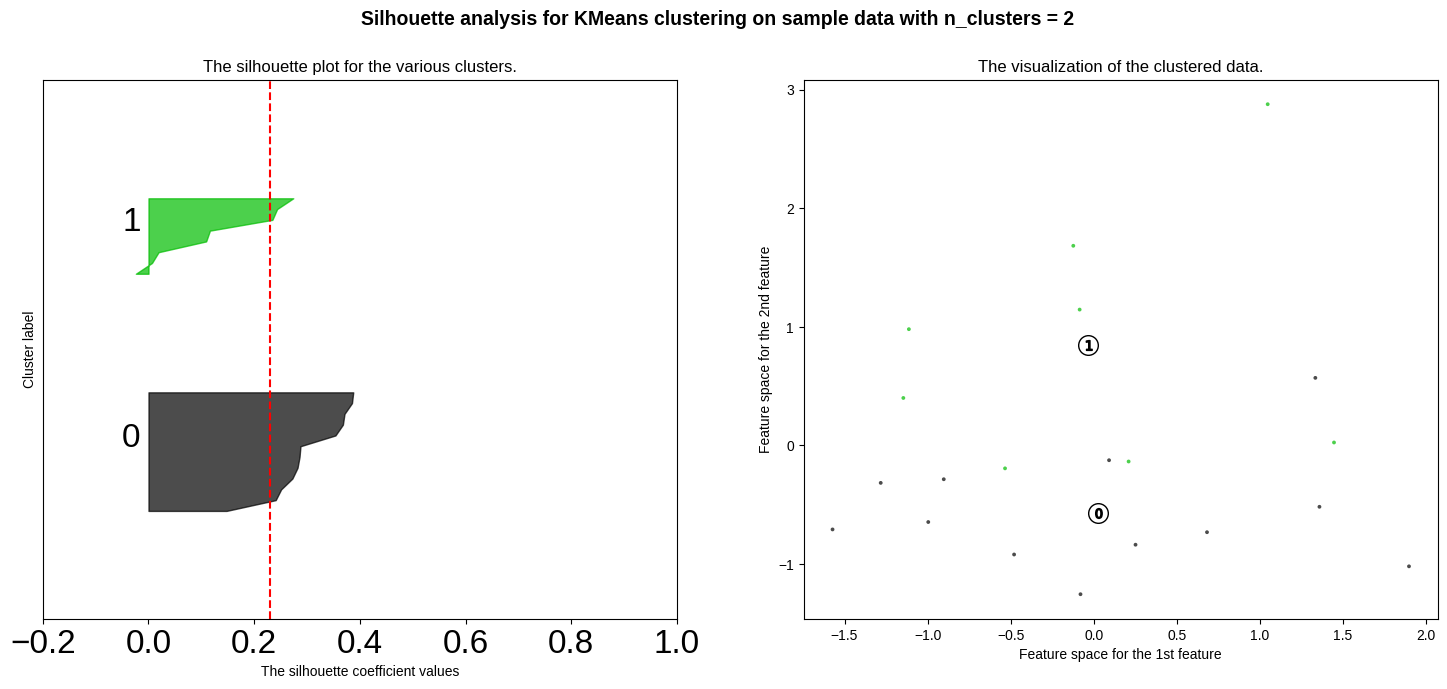

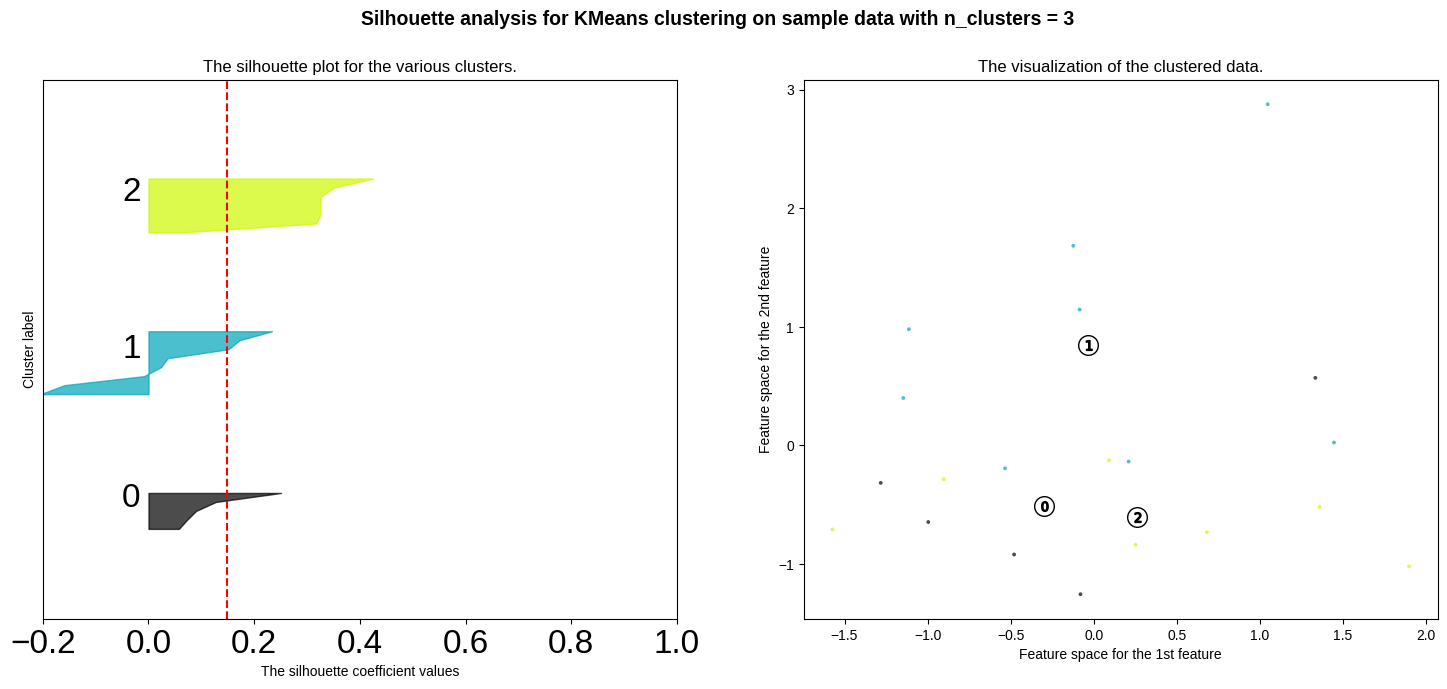

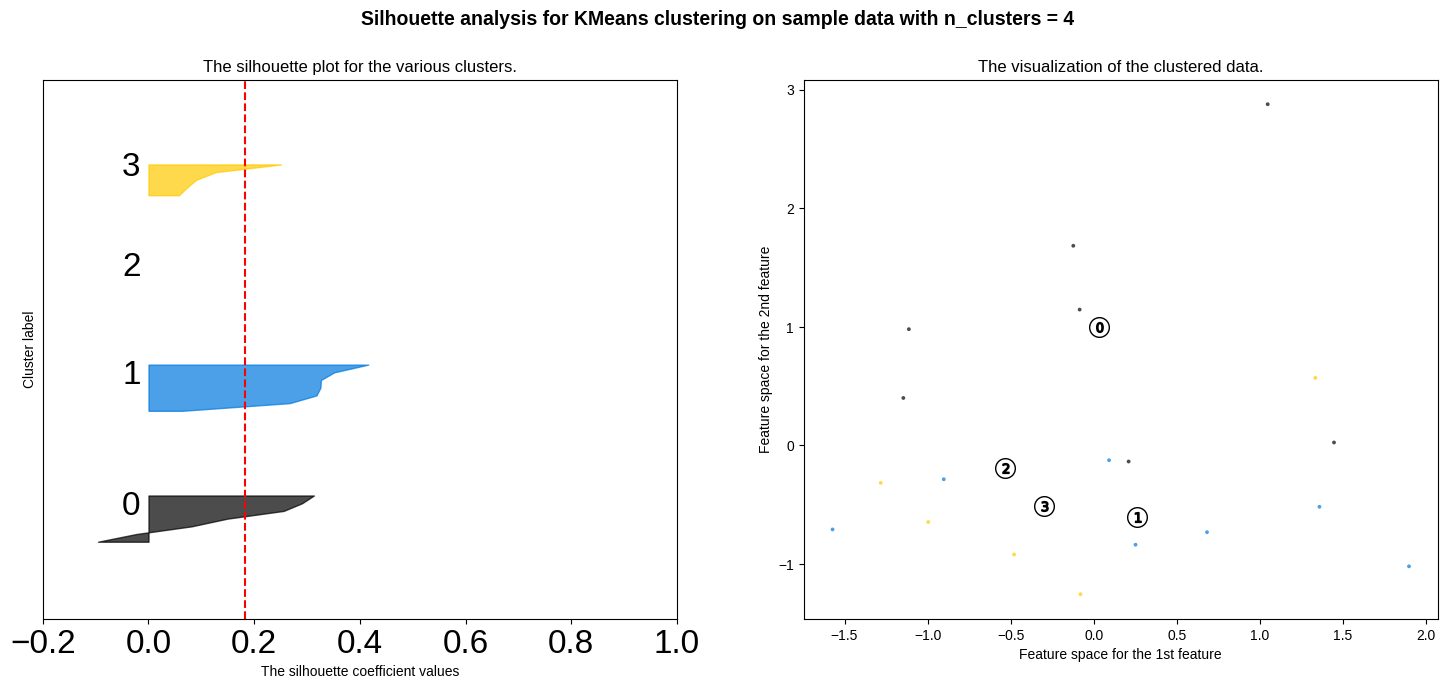

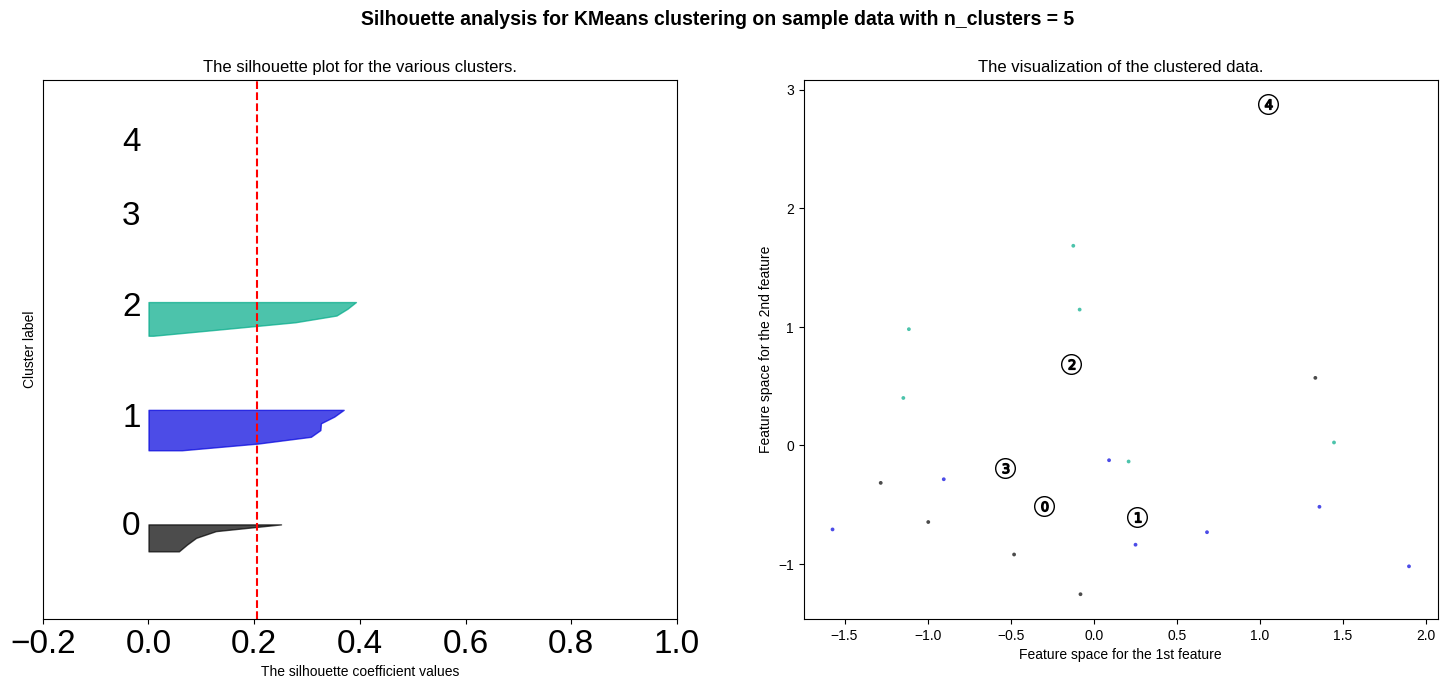

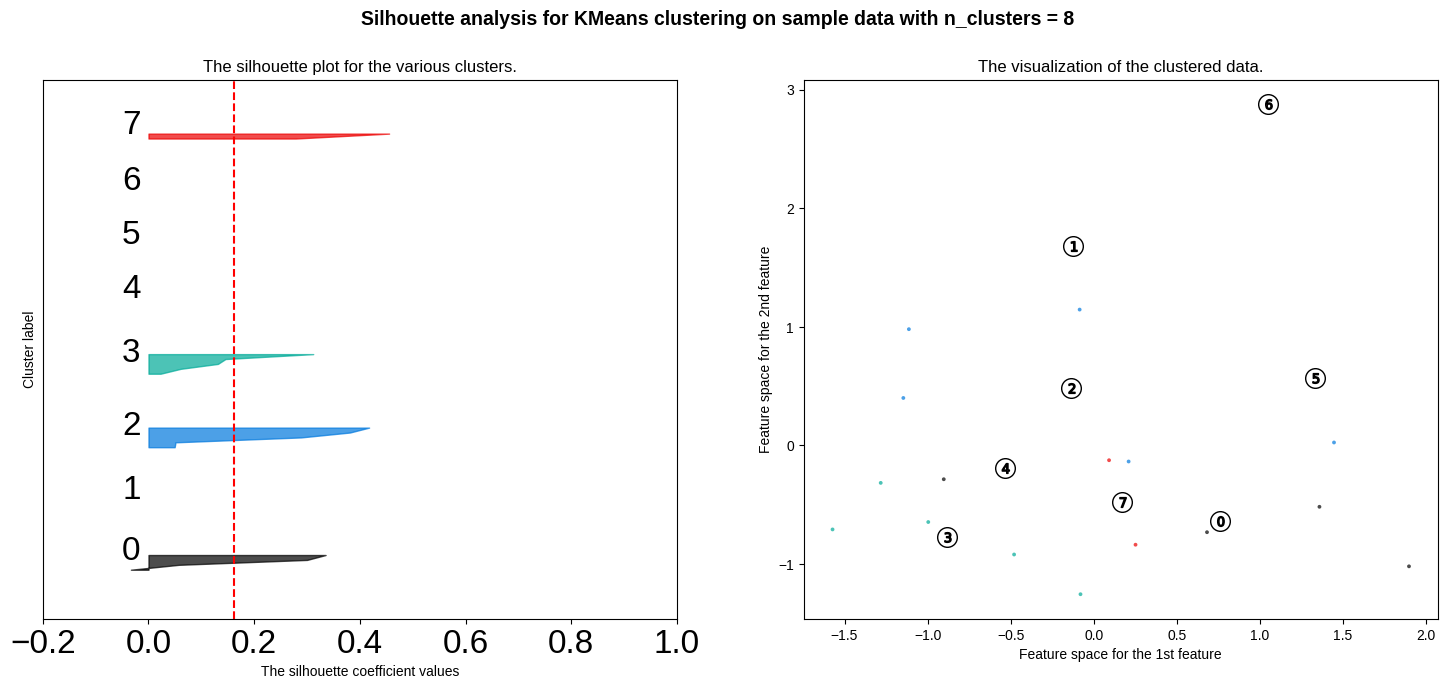

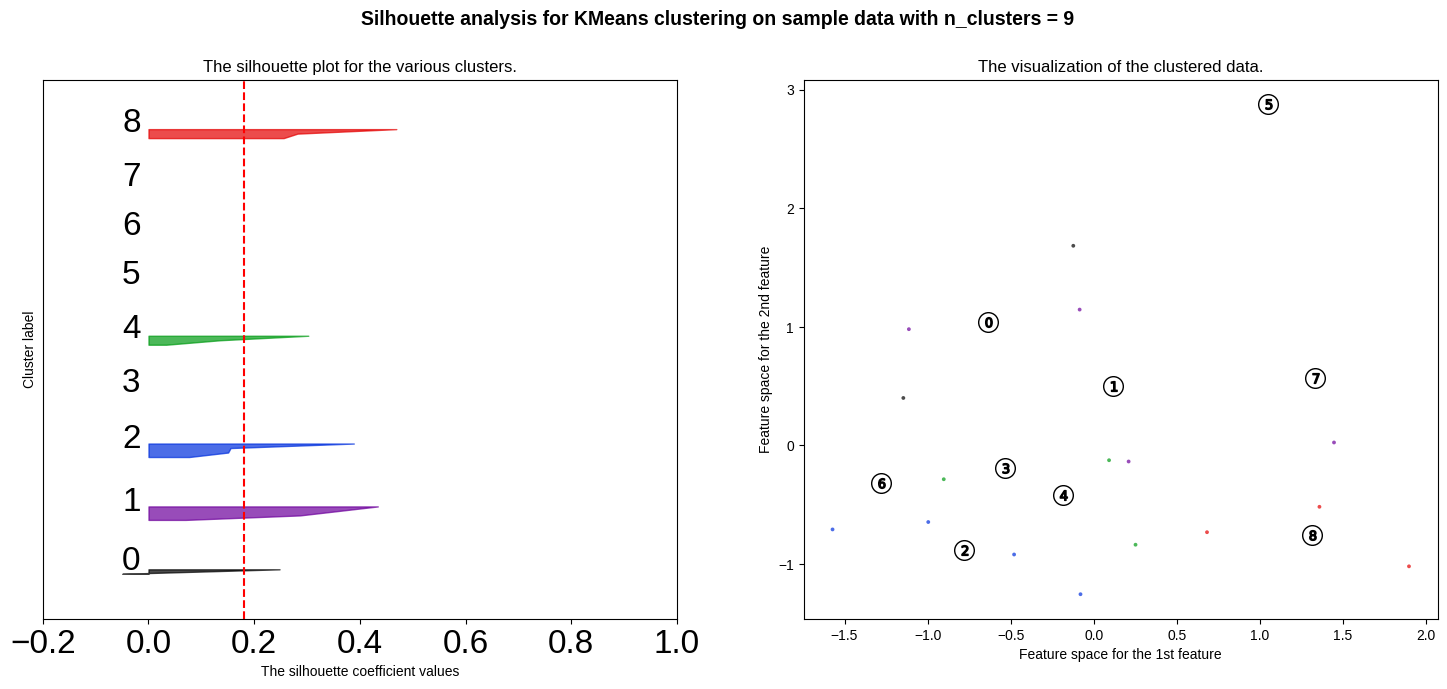

In [122]:
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_samples, silhouette_score
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import numpy as np

# Assuming 'data_scaled' is your scaled dataset
range_of_clusters = range(2, 11)

for num_clusters in range_of_clusters:
    # Create a subplot with 1 row and 2 columns
    fig, (ax1, ax2) = plt.subplots(1, 2)
    fig.set_size_inches(18, 7)

    # The 1st subplot is the silhouette plot
    # The silhouette coefficient can range from -1 to 1
    ax1.set_xlim([-0.1, 1])
    # The (num_clusters+1)*10 is for inserting blank space between silhouette
    # plots of individual clusters, to demarcate them clearly.
    ax1.set_ylim([0, len(data_scaled) + (num_clusters + 1) * 10])

    # Initialize the clusterer with num_clusters value and a random generator
    # seed of 10 for reproducibility.
    clusterer = KMeans(n_clusters=num_clusters, random_state=10)
    cluster_labels = clusterer.fit_predict(data_scaled)

    # The silhouette_score gives the average value for all the samples.
    silhouette_avg = silhouette_score(data_scaled, cluster_labels)
    print(f"For n_clusters = {num_clusters}, the average silhouette_score is : {silhouette_avg}")

    # Compute the silhouette scores for each sample
    sample_silhouette_values = silhouette_samples(data_scaled, cluster_labels)

    y_lower = 10
    for i in range(num_clusters):
        # Aggregate the silhouette scores for samples belonging to cluster i, and sort them
        ith_cluster_silhouette_values = sample_silhouette_values[cluster_labels == i]
        ith_cluster_silhouette_values.sort()

        size_cluster_i = ith_cluster_silhouette_values.shape[0]
        y_upper = y_lower + size_cluster_i

        color = cm.nipy_spectral(float(i) / num_clusters)
        ax1.fill_betweenx(np.arange(y_lower, y_upper), 0, ith_cluster_silhouette_values,
                          facecolor=color, edgecolor=color, alpha=0.7)

        # Label the silhouette plots with their cluster numbers at the middle
        ax1.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i), fontsize = 24)

        # Compute the new y_lower for next plot
        y_lower = y_upper + 10  # 10 for the 0 samples

    ax1.set_title("The silhouette plot for the various clusters.")
    ax1.set_xlabel("The silhouette coefficient values")
    ax1.set_ylabel("Cluster label")

    # The vertical line for average silhouette score of all the values
    ax1.axvline(x=silhouette_avg, color="red", linestyle="--")

    ax1.set_yticks([])  # Clear the yaxis labels / ticks
    ax1.set_xticks([-0.2, 0, 0.2, 0.4, 0.6, 0.8, 1])
    ax1.tick_params(labelsize=24)

    # 2nd Plot showing the actual clusters formed
    # This assumes data_scaled is a 2D array for visualization purposes
    if data_scaled.shape[1] >= 2:
        colors = cm.nipy_spectral(cluster_labels.astype(float) / num_clusters)
        ax2.scatter(data_scaled[:, 0], data_scaled[:, 1], marker=".", s=30, lw=0, alpha=0.7,
                    c=colors, edgecolor="k")

        # Labeling the clusters
        centers = clusterer.cluster_centers_
        # Draw white circles at cluster centers
        ax2.scatter(centers[:, 0], centers[:, 1], marker="o", c="white", alpha=1,
                    s=200, edgecolor="k")

        for i, c in enumerate(centers):
            ax2.scatter(c[0], c[1], marker=f"${i}$", alpha=1, s=50, edgecolor="k")

        ax2.set_title("The visualization of the clustered data.")
        ax2.set_xlabel("Feature space for the 1st feature")
        ax2.set_ylabel("Feature space for the 2nd feature")

    plt.suptitle(f"Silhouette analysis for KMeans clustering on sample data with n_clusters = {num_clusters}",
                 fontsize=14, fontweight="bold")



In [123]:
# Perform K-means clustering
kmeans = KMeans(n_clusters=2, random_state=10)
clusters = kmeans.fit_predict(data_scaled)
inertia = kmeans.inertia_
silhouette = silhouette_score(data_scaled, kmeans.labels_)

# Add the cluster labels to the original data
cluster_data_kmeans = cluster_data.copy()
cluster_data_kmeans['Cluster'] = clusters.astype('str')

/work/09117/xz6783/ls6/Anaconda/envs/sklearn/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


In [124]:
cluster_data_kmeans

hungry_food_area  satiated_food_area  hungry_rewarded  satiated_rewarded  \
0          41.518805           15.471462       100.000000          16.666667   
1          53.503023           53.721896       100.000000          50.000000   
2          47.596740           25.134012        75.000000          41.666667   
3          48.313549            9.625053       100.000000           8.333333   
4          53.570192            2.472685       100.000000           8.333333   
5          57.380288           26.369736       100.000000          33.333333   
6          37.755046           22.520833        91.666667           8.333333   
7          73.639557           29.792574       100.000000          33.333333   
8          55.831376           26.598494       100.000000           8.333333   
9          39.985104           50.193153       100.000000          50.000000   
10         39.546341           37.809007       100.000000          41.666667   
11         53.000692           65.210683       100.000000          75.000000   
12         68.389727           90.696211       100.000000          33.333333   
13         72.162251           41.428794       100.000000           8.333333   
14         42.746227           23.174042       100.000000           0.000000   
15         63.585689           13.638904       100.000000           0.000000   
16         72.486439           18.215726       100.000000           8.333333   
17         57.927111           11.387919       100.000000           0.000000   
18         33.941760           14.138866       100.000000          16.666667   
19         79.575693            7.494686       100.000000           8.333333   

    hungry_latency  satiated_latency  hungry_speed  satiated_speed  \
0         2.824917         29.805667      0.037186        0.011785   
1         4.711000         21.522750      0.029317        0.015261   
2        13.490500         24.307917      0.035027        0.020905   
3         1.602833         27.861417      0.044772        0.009924   
4         4.285667         28.564083      0.025482        0.006062   
5         4.023667         23.316833      0.033206        0.016110   
6         5.869167         28.627250      0.034021        0.008131   
7         4.276000         23.907417      0.033628        0.017934   
8         4.131250         28.389500      0.051138        0.020538   
9         5.669583         22.938583      0.033623        0.019163   
10        3.107000         20.975417      0.049013        0.018308   
11        2.936917         15.942500      0.052328        0.021797   
12        4.812667         26.499500      0.026133        0.053081   
13        4.355083         29.686333      0.026003        0.010395   
14        5.455667         30.000000      0.031441        0.024061   
15        7.016583         30.000000      0.028956        0.016571   
16        4.290417         27.990833      0.035776        0.015815   
17        4.336250         30.000000      0.044664        0.014084   
18        2.072167         27.586833      0.035861        0.018988   
19        3.829250         27.806833      0.025009        0.017869   

    hungry_freezing  satiated_freezing Cluster  
0          0.859478          20.075338       0  
1          0.713835           4.300952       1  
2          0.170256           9.594337       1  
3          2.681116          17.376971       0  
4          0.564180          24.551372       0  
5          0.420504           3.048821       1  
6          4.237782          19.194430       0  
7          0.137429           3.640556       1  
8          0.188704           0.166431       0  
9          0.000000           0.872621       1  
10         0.000000           7.072777       1  
11         0.994846           0.000000       1  
12         0.147676           3.669461       1  
13         5.384858          10.515191       0  
14         0.683076           4.341525       0  
15         0.252428           9.004408       0  
16         0.000000

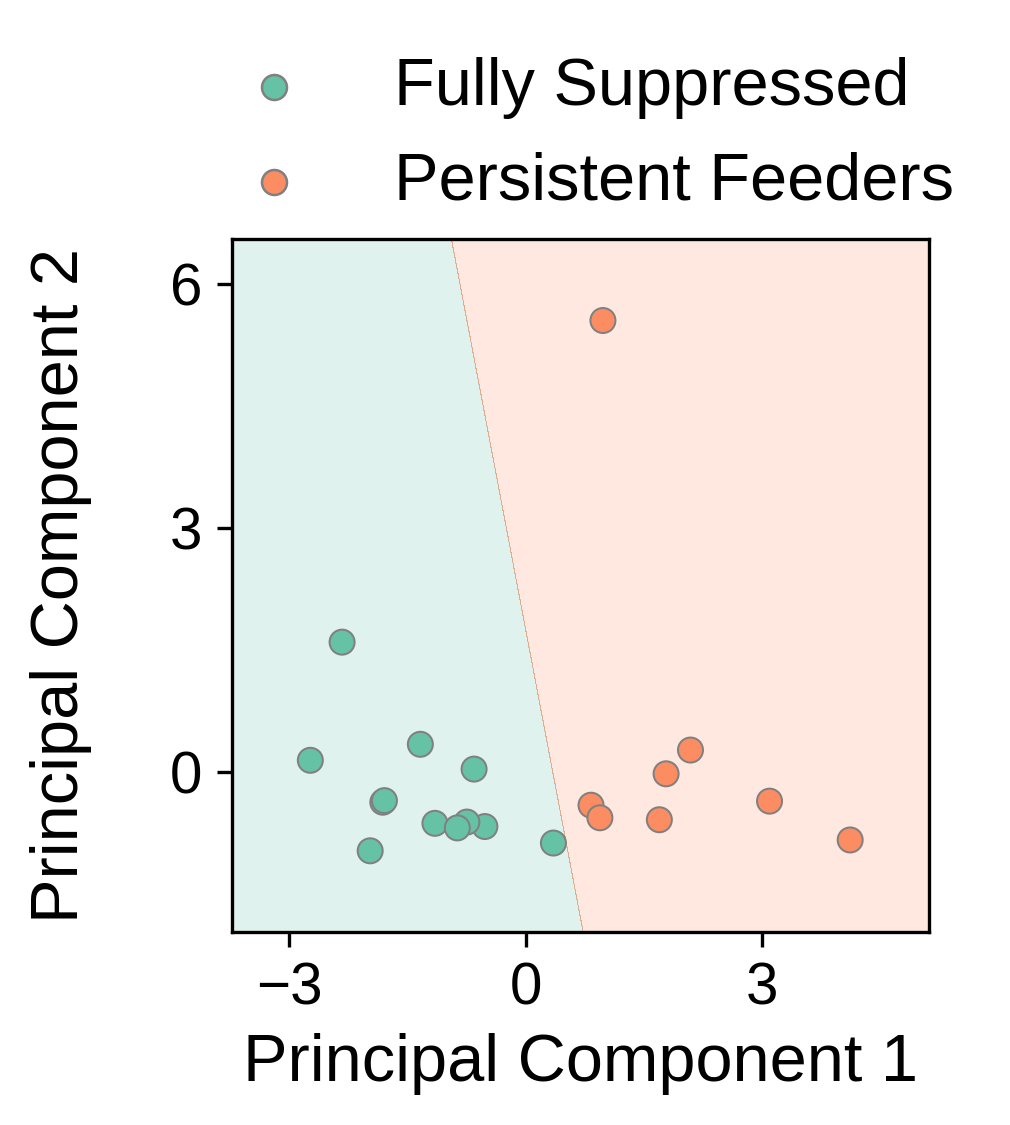

In [129]:
labels = kmeans.labels_
labels = ['Fully Suppressed' if i == 0 else 'Persistent Feeders' for i in kmeans.labels_]

# PCA to reduce to 2 dimensions for visualization
pca = PCA(n_components=2)
principal_components = pca.fit_transform(data_scaled)

# Get unique clusters for color palette
unique_clusters = np.unique(labels)

# Set color palette for scatter plot
scatter_palette = sns.color_palette('Set2', len(unique_clusters))
# Create a color map that maps each label to a color in the scatter_palette
label_color_map = {
    'Fully Suppressed': scatter_palette[0],
    'Persistent Feeders': scatter_palette[1]
}

# Plot
fig, ax = plt.subplots(figsize=(3, 3), dpi=300)
centroids_pca = pca.transform(kmeans.cluster_centers_)

# Create a meshgrid for the Voronoi diagram
x_min, x_max = principal_components[:, 0].min() - 1, principal_components[:, 0].max() + 1
y_min, y_max = principal_components[:, 1].min() - 1, principal_components[:, 1].max() + 1
xx, yy = np.meshgrid(np.linspace(x_min, x_max, 6000), np.linspace(y_min, y_max, 6000))
Z = kmeans.predict(pca.inverse_transform(np.c_[xx.ravel(), yy.ravel()]))
Z = Z.reshape(xx.shape)
# Set color palette for contour
contour_palette = sns.color_palette('Set2', len(np.unique(Z)))
contour_color_map = ListedColormap([label_color_map[label] for label in np.unique(labels)])


# Plot
ax.contourf(xx, yy, Z, alpha=0.2, cmap=contour_color_map)
sns.scatterplot(ax = ax, x=principal_components[:, 0], y=principal_components[:, 1], hue=labels, palette=label_color_map, edgecolor = 'grey', lw = 0.6)
ax.set_xlabel('Principal Component 1', fontsize = 16)
ax.set_ylabel('Principal Component 2', fontsize = 16)
ax.tick_params(axis = 'x', labelsize=14)
ax.tick_params(axis = 'y', labelsize=14)
# legend = plt.legend(loc='upper center', bbox_to_anchor=(0.5, 1.15), fontsize=6, frameon=False)
# legend.get_frame().set_facecolor('none')

# Get the legend handles
handles, labels = ax.get_legend_handles_labels()

# Iterate through the handles and call `set_edgecolor` on each
for ha in handles:
    ha.set_edgecolor("grey")
    ha.set_linewidth(0.6)

ordered_labels = ['Fully Suppressed', 'Persistent Feeders']
ordered_handles = [handles[labels.index(l)] for l in ordered_labels]

# # Use `ax.legend` to set the modified handles and labels
lgd = ax.legend(
    ordered_handles,
    ordered_labels,
    loc="upper center", 
    bbox_to_anchor=(0.5, 1.35),
    ncol=1,
    fontsize=16, 
    frameon=False
)
lgd.get_frame().set_facecolor('none')

ax.xaxis.set_major_locator(matplotlib.ticker.MaxNLocator(3))
ax.yaxis.set_major_locator(matplotlib.ticker.MaxNLocator(3))
ax.yaxis.set_label_coords(-0.2, 0.5)  # Adjust label position

plt.show()

In [136]:
def generate_symmetric_points(center, spread, n_points):
    if n_points == 1:
        return np.array([center])
    else:
        offsets = np.linspace(-spread, spread, n_points)
        return center + offsets

def group_values_with_indices(values, threshold):
    sorted_indices = np.argsort(values)
    sorted_values = values[sorted_indices]
    groups = [([sorted_values[0]], [sorted_indices[0]])]
    for i in range(1, len(values)):
        if abs(sorted_values[i] - groups[-1][0][-1]) <= threshold:
            groups[-1][0].append(sorted_values[i])
            groups[-1][1].append(sorted_indices[i])
        else:
            groups.append(([sorted_values[i]], [sorted_indices[i]]))
    return groups

def wilcoxon_sign_test(group_data, data1_name, data2_name,):
        safe_data = group_data[group_data['Condition'] == data1_name]['Data']
        threat_data = group_data[group_data['Condition'] == data2_name]['Data']

       
        stat, p_value = stats.wilcoxon(safe_data, threat_data)
        
        return stat, p_value
    
def paired_ttest(group_data, data1_name, data2_name,):
        safe_data = group_data[group_data['Condition'] == data1_name]['Data']
        threat_data = group_data[group_data['Condition'] == data2_name]['Data']
        
        # Data are normally distributed
        stat, p_value = stats.ttest_rel(safe_data, threat_data)
        
        return stat, p_value
    
def split_violin_with_dots_lines_multicluster(ax, data1, data2, data1_name, data2_name, title, y_label, ylim, label, point_size=8, line_width=0.6):
    # Combine data1 and data2 into a single DataFrame
    data1['Condition'] = data1_name
    data2['Condition'] = data2_name
    combined_data = pd.concat([data1[['animal_id','Data', 'Condition','Cluster']], data2[['animal_id','Data', 'Condition','Cluster']]])

    # Encode categorical variables
    combined_data['Cluster'] = pd.Categorical(combined_data['Cluster'])
    combined_data['Condition'] = pd.Categorical(combined_data['Condition'])

    # Perform 2-way RM ANOVA using MixedLM
    model = MixedLM.from_formula("Data ~ Cluster * Condition", combined_data, groups=combined_data["animal_id"], re_formula="~Condition")
    results = model.fit()
    print(results.summary())

    # The fixed effects are typically in the second table (index 1)
    fixed_effects_df = results.summary().tables[1]
    
    interaction_term = results.model.exog_names[-1]

    # Construct the hypothesis
    hypothesis = f'{interaction_term} = 0'

    # Perform the F-test
    f_test_result = results.f_test(hypothesis)
    print(f'F-test result for {interaction_term}: {f_test_result}')
    
    # Assuming the interaction term is in the third row (index 2) and the p-value is in the fourth column (index 3)
    interaction_p_value = float(fixed_effects_df.iloc[2, 3])
    print("Interaction: p-value =", interaction_p_value)

    # Number of clusters
    unique_clusters = combined_data['Cluster'].unique()
    
    # Normality test
    safe_data = combined_data[combined_data['Condition'] == data1_name]['Data']
    threat_data = combined_data[combined_data['Condition'] == data2_name]['Data']
    diff = safe_data - threat_data
    normality = stats.shapiro(diff)
    print(f"Normality test results: Statistics = {normality[0]}, p-value = {normality[1]}")

    p_values =[]
    statistics = []
    for i, cluster in enumerate(unique_clusters):
        cluster_dt = combined_data[combined_data['Cluster'] == cluster]
               
        if normality[1] < 0.05:
            stat, pvalue = wilcoxon_sign_test(cluster_dt, data1_name, data2_name)
            statistics.append(stat)
            p_values.append(pvalue)
        elif normality[1] >= 0.05:
            stat, pvalue = paired_ttest(cluster_dt, data1_name, data2_name)
            statistics.append(stat)
            p_values.append(pvalue)
    
    sidak_corrected = multipletests(p_values, method='sidak')

    # Print results
    for i, cluster in enumerate(unique_clusters):
        print(f"Cluster {i} comparison: Statistics = {statistics[i]}, original p-values = {p_values[i]},  Sidak corrected p-values = {sidak_corrected[1][i]}")
    
    # Prepare plot_data with positions for the violin plot
    plot_data = combined_data.copy()
    num_conditions = 2  # Number of conditions
    plot_positions = {}
    gap_index = 0  # To create a gap between clusters
    for i, cluster in enumerate(sorted(unique_clusters)):
        plot_positions[cluster] = [gap_index * num_conditions+gap_index, gap_index * num_conditions + 1+gap_index]
        gap_index += 1  # Increase index for the next cluster

        # Add dummy category for the gap
        for gap in range(gap_index - 1):
            dummy_data = pd.DataFrame({'PlotPos': [gap * (num_conditions+1)+2], 'Data': [None], 'Condition': [None], 'Cluster': [None]})
            plot_data = pd.concat([plot_data, dummy_data], ignore_index=True)

    plot_data['PlotPos'] = plot_data.apply(lambda row: plot_positions[row['Cluster']][0 if row['Condition'] == data1_name else 1] if pd.notna(row['Cluster']) else row['PlotPos'], axis=1)


    # Prepare colors for each cluster and condition
    base_colors = sns.color_palette('Set2', len(unique_clusters))
    condition_colors = {cluster: {data1_name: to_rgb(base_colors[i]), data2_name: 0.7 + 0.3 * np.array(to_rgb(base_colors[i]))} for i, cluster in enumerate(sorted(unique_clusters))}

    for cluster in sorted(unique_clusters):
        cls_data = plot_data[plot_data.Cluster == cluster]

        for i in set(plot_data.PlotPos) - set(cls_data.PlotPos):
            dummy_data = pd.DataFrame({'PlotPos': [i], 'Data': [None], 'Condition': [None], 'Cluster': [None]})
            cls_data = pd.concat([cls_data, dummy_data], ignore_index=True)
        sns.violinplot(x = 'PlotPos', y='Data', hue='Condition', 
               data=cls_data, 
               fill=False, split=True, width=1, palette=condition_colors[cluster], scale_hue=False,
               linewidth=1, inner='quart', cut=0, ax=ax, dodge = 'auto')


    ax.legend().remove()
    plt.setp(ax.collections, alpha=0.7)

    # Initialize a dictionary to store coordinates for connecting lines
    point_coords = {}
    
    # Calculate the diameter in points
    diameter_points = 2 * sqrt(point_size / pi)
    actual_ylim = ax.get_ylim()
    
    # Convert diameter to inches
    diameter_inches = diameter_points / 72

    # Get the height of the axes in inches
    bbox = ax.get_window_extent().transformed(fig.dpi_scale_trans.inverted())
    axes_height_inches = bbox.height

    # Get the conversion factor from inches to data units
    y_range = ylim[1] - actual_ylim[0]
    conversion_factor = y_range / axes_height_inches

    # Convert diameter from points to data units
    diameter_data_units = diameter_inches * conversion_factor
    
    # Spread scatter points for each cluster and store their coordinates
    offset = 0.1  # Adjust this value to change the spread of points
    for cluster in unique_clusters:
        for condition in [data1_name, data2_name]:
            condition_data = plot_data[(plot_data['Cluster'] == cluster) & (plot_data['Condition'] == condition)]
            grouped_values = group_values_with_indices(condition_data['Data'].values, diameter_data_units)
            condition_color = condition_colors[cluster][condition]

            for group, indices in grouped_values:
                x_positions = generate_symmetric_points(plot_positions[cluster][0 if condition == data1_name else 1], offset, len(condition_data))

                for i, idx in enumerate(indices):
                    animal_id = condition_data.iloc[idx].animal_id  # Correct index from group_data
                    x_coord = x_positions[i]+0.1
                    y_value = condition_data[condition_data.animal_id == animal_id].Data.values
                    if animal_id not in point_coords:
                        point_coords[animal_id] = {}
                        
                    # Store the coordinates for lines
                    point_coords[animal_id][condition] = (x_coord, y_value)

                    ax.scatter(x_coord, y_value, color=condition_color, edgecolors='gray', alpha=1, clip_on=False, s=point_size, lw=line_width, zorder=3)

 
    # Draw connecting lines based on stored coordinates
    for animal_id, coords in point_coords.items():
        if data1_name in coords and data2_name in coords:
            x_coords = [coords[data1_name][0], coords[data2_name][0]]
            y_coords = [coords[data1_name][1], coords[data2_name][1]]
            ax.plot(x_coords, y_coords, color='gray', alpha=0.5, linewidth=line_width)

    y_max = min(combined_data['Data'].max()*1.05, ylim[1]*1.05)
    for i, (cluster, p_value) in enumerate(zip(unique_clusters, sidak_corrected[1])):
        if p_value < 0.05:
            x_coords = plot_positions[cluster]
            ax.plot([x_coords[0], x_coords[0], x_coords[1], x_coords[1]], [y_max, y_max, y_max, y_max], lw=0.8, c='k', clip_on=False)
            # Add asterisk for significance
            ax.text((x_coords[0] + x_coords[1]) / 2, y_max, "*", ha='center', va='bottom', color='k', fontsize=16)

    if label:
        custom_legend = [mlines.Line2D([], [], color=condition_colors[cluster][data1_name], marker='o', linestyle='None', markersize=point_size, label='Cluster 0', mec = 'gray', markeredgewidth=line_width) for i, cluster in enumerate(sorted(unique_clusters))]
        ax.legend(custom_legend, ['Fully Supressed' if cluster == '0' else 'Persistent Feeder' for cluster in sorted(unique_clusters)], loc='upper right', frameon=False, markerscale = 1, fontsize = 12, bbox_to_anchor=(1.45, 1.3))

    # Customization and Annotations
    ax.set_xticks([pos for cluster in plot_positions for pos in plot_positions[cluster]])
    ax.set_xticklabels([f'{condition}' for cluster in combined_data['Cluster'].unique() for condition in [data1_name, data2_name]], rotation=45, ha='right')
    ax.set_title(title)
    ax.set_xlabel(None)
    ax.set_title(title, fontsize=6, pad = 25)
    ax.set_ylabel(y_label, fontsize=11)
    ax.yaxis.set_label_coords(-0.25, 0.5)  # Adjust label position

    ax.set_ylim(*ylim)
    ax.tick_params(axis = 'x', labelsize=12)
    ax.tick_params(axis = 'y', labelsize=12)
    sns.despine() 
    ax.margins(x=0.1)
    
    return ax

In [228]:
def perform_pairwise_comparisons_and_correct(df, alpha=0.05):
    p_values = []
    comparisons = []

    # Calculate SD for each group
    group_sds = df.groupby(['Cluster', 'Condition'])['Data'].std()
    group_sizes = df.groupby(['Cluster', 'Condition'])['Data'].count()
    
    # Calculate pooled variance
    pooled_variance = sum((sizes - 1) * sds**2 for sizes, sds in zip(group_sizes, group_sds)) / (sum(group_sizes) - len(group_sizes))
    
    stages = df['Cluster'].unique()
    treatments = df['Condition'].unique()
    
    for stage in sorted(stages):
        stage_data = df[df['Cluster'] == stage]
        treatment_combinations = list(combinations(treatments, 2))
        
        for treatment1, treatment2 in treatment_combinations:
            data1 = stage_data[stage_data['Condition'] == treatment1]['Data']
            data2 = stage_data[stage_data['Condition'] == treatment2]['Data']
            
            n1, n2 = len(data1), len(data2)
            
            # Calculate SE for this comparison using pooled variance
            se = np.sqrt(pooled_variance * (1/n1 + 1/n2))
            
            # Compute mean difference
            mean_diff = np.mean(data1) - np.mean(data2)
            
            # Compute the t-statistic using the calculated SE
            t_stat = mean_diff / se
            
            # Degrees of freedom, approximated for pooled samples
            df_degrees = sum(group_sizes) - len(group_sizes)
            
            # Calculate p-value using the t-distribution
            p_value = 2 * (1 - t.cdf(np.abs(t_stat), df_degrees))
            p_values.append(p_value)
            comparisons.append(f"{stage}: {treatment1} vs. {treatment2}")
    
    # Apply Bonferroni correction for multiple comparisons
    _, corrected_p_values, _, _ = multipletests(p_values, alpha=alpha, method='sidak')
    
    # Combine comparisons and their corrected p-values
    comparison_results = list(zip(comparisons, corrected_p_values))
    
    return comparison_results

def perform_pairwise_comparisons_by_treatment(df, mse, alpha=0.05):
    p_values = []
    comparisons = []

    # Calculate SD for each group
    group_sds = df.groupby(['Condition', 'Cluster'])['Data'].std()
    group_sizes = df.groupby(['Condition', 'Cluster'])['Data'].count()

    # Calculate pooled variance
    pooled_variance = mse

    treatments = df['Condition'].unique()
    stages = df['Cluster'].unique()

    for treatment in treatments:
        treatment_data = df[df['Condition'] == treatment]
        stage_combinations = list(combinations(stages, 2))

        for stage1, stage2 in stage_combinations:
            data1 = treatment_data[treatment_data['Cluster'] == stage1]['Data']
            data2 = treatment_data[treatment_data['Cluster'] == stage2]['Data']

            n1, n2 = len(data1), len(data2)

            # Calculate SE for this comparison using pooled variance
            se = np.sqrt(pooled_variance * (1/n1 + 1/n2))

            # Compute mean difference
            mean_diff = np.mean(data1) - np.mean(data2)

            # Compute the t-statistic using the calculated SE
            t_stat = mean_diff / se

            # Degrees of freedom, approximated for pooled samples
            df_degrees = (sum(group_sizes) - len(group_sizes))/2

            # Calculate p-value using the t-distribution
            p_value = 2 * (1 - t.cdf(np.abs(t_stat), df_degrees))
            p_values.append(p_value)
            comparisons.append(f"{treatment}: {stage1} vs. {stage2}")

    # Apply Bonferroni correction for multiple comparisons
    _, corrected_p_values, _, _ = multipletests(p_values, alpha=alpha, method='sidak')

    # Combine comparisons and their corrected p-values
    comparison_results = list(zip(comparisons, corrected_p_values))

    return comparison_results

def split_violin_with_dots_lines_multicluster(ax, data1, data2, data1_name, data2_name, title, y_label, ylim, label, point_size=8, line_width=0.6):
    # Combine data1 and data2 into a single DataFrame
    data1['Condition'] = data1_name
    data2['Condition'] = data2_name
    combined_data = pd.concat([data1[['animal_id','Data', 'Condition','Cluster']], data2[['animal_id','Data', 'Condition','Cluster']]])
    conditions = combined_data['Condition'].unique()
    
    # Encode categorical variables
    combined_data['Cluster'] = pd.Categorical(combined_data['Cluster'])
    combined_data['Condition'] = pd.Categorical(combined_data['Condition'])

    # Perform 2-way RM ANOVA using MixedLM
    model = MixedLM.from_formula("Data ~ Cluster * Condition", combined_data, groups=combined_data["animal_id"], re_formula="~Condition")
    results = model.fit()
    mse = results.scale
    print(results.summary())

    # The fixed effects are typically in the second table (index 1)
    fixed_effects_df = results.summary().tables[1]
    
    interaction_term = results.model.exog_names[-1]

    # Construct the hypothesis
    hypothesis = f'{interaction_term} = 0'

    # Perform the F-test
    f_test_result = results.f_test(hypothesis)
    print(f'F-test result for {interaction_term}: {f_test_result}')
    
    # Assuming the interaction term is in the third row (index 2) and the p-value is in the fourth column (index 3)
    interaction_p_value = float(fixed_effects_df.iloc[2, 3])
    print("Interaction: p-value =", interaction_p_value)

    # Number of clusters
    unique_clusters = sorted(combined_data['Cluster'].unique())
    
    results = perform_pairwise_comparisons_and_correct(combined_data)
    for result in results:
        print(result)
        
    # Perform pairwise comparisons
    results_by_treatment = perform_pairwise_comparisons_by_treatment(combined_data, mse)
    for result in results_by_treatment:
        print(result)
#     # Normality test
#     safe_data = combined_data[combined_data['Condition'] == data1_name]['Data']
#     threat_data = combined_data[combined_data['Condition'] == data2_name]['Data']
#     diff = safe_data - threat_data
#     normality = stats.shapiro(diff)
#     print(f"Normality test results: Statistics = {normality[0]}, p-value = {normality[1]}")

#     p_values =[]
#     statistics = []
#     for i, cluster in enumerate(unique_clusters):
#         cluster_dt = combined_data[combined_data['Cluster'] == cluster]
               
#         if normality[1] < 0.05:
#             stat, pvalue = wilcoxon_sign_test(cluster_dt, data1_name, data2_name)
#             statistics.append(stat)
#             p_values.append(pvalue)
#         elif normality[1] >= 0.05:
#             stat, pvalue = paired_ttest(cluster_dt, data1_name, data2_name)
#             statistics.append(stat)
#             p_values.append(pvalue)
    
#     sidak_corrected = multipletests(p_values, method='sidak')

#     # Print results
#     for i, cluster in enumerate(unique_clusters):
#         print(f"Cluster {i} comparison: Statistics = {statistics[i]}, original p-values = {p_values[i]},  Sidak corrected p-values = {sidak_corrected[1][i]}")
    
    # Prepare plot_data with positions for the violin plot
    plot_data = combined_data.copy()
    num_conditions = 2  # Number of conditions
    plot_positions = {}
    gap_index = 0  # To create a gap between clusters
    for i, cluster in enumerate(sorted(unique_clusters)):
        plot_positions[cluster] = [gap_index * num_conditions+gap_index, gap_index * num_conditions + 1+gap_index]
        gap_index += 1  # Increase index for the next cluster

        # Add dummy category for the gap
        for gap in range(gap_index - 1):
            dummy_data = pd.DataFrame({'PlotPos': [gap * (num_conditions+1)+2], 'Data': [None], 'Condition': [None], 'Cluster': [None]})
            plot_data = pd.concat([plot_data, dummy_data], ignore_index=True)

    plot_data['PlotPos'] = plot_data.apply(lambda row: plot_positions[row['Cluster']][0 if row['Condition'] == data1_name else 1] if pd.notna(row['Cluster']) else row['PlotPos'], axis=1)


    # Prepare colors for each cluster and condition
    base_colors = sns.color_palette('Set2', len(unique_clusters))
    condition_colors = {cluster: {data1_name: to_rgb(base_colors[i]), data2_name: 0.7 + 0.3 * np.array(to_rgb(base_colors[i]))} for i, cluster in enumerate(sorted(unique_clusters))}

    for cluster in sorted(unique_clusters):
        cls_data = plot_data[plot_data.Cluster == cluster]

        for i in set(plot_data.PlotPos) - set(cls_data.PlotPos):
            dummy_data = pd.DataFrame({'PlotPos': [i], 'Data': [None], 'Condition': [None], 'Cluster': [None]})
            cls_data = pd.concat([cls_data, dummy_data], ignore_index=True)
        sns.violinplot(x = 'PlotPos', y='Data', hue='Condition', 
               data=cls_data, 
               fill=False, split=True, width=1, palette=condition_colors[cluster], scale_hue=False,
               linewidth=1, inner='quart', cut=0, ax=ax, dodge = 'auto')


    ax.legend().remove()
    plt.setp(ax.collections, alpha=0.7)

    # Initialize a dictionary to store coordinates for connecting lines
    point_coords = {}
    
    # Calculate the diameter in points
    diameter_points = 2 * sqrt(point_size / pi)
    actual_ylim = ax.get_ylim()
    
    # Convert diameter to inches
    diameter_inches = diameter_points / 72

    # Get the height of the axes in inches
    bbox = ax.get_window_extent().transformed(fig.dpi_scale_trans.inverted())
    axes_height_inches = bbox.height

    # Get the conversion factor from inches to data units
    y_range = ylim[1] - actual_ylim[0]
    conversion_factor = y_range / axes_height_inches

    # Convert diameter from points to data units
    diameter_data_units = diameter_inches * conversion_factor
    
    # Spread scatter points for each cluster and store their coordinates
    offset = 0.1  # Adjust this value to change the spread of points
    for cluster in unique_clusters:
        for condition in [data1_name, data2_name]:
            condition_data = plot_data[(plot_data['Cluster'] == cluster) & (plot_data['Condition'] == condition)]
            grouped_values = group_values_with_indices(condition_data['Data'].values, diameter_data_units)
            condition_color = condition_colors[cluster][condition]

            for group, indices in grouped_values:
                x_positions = generate_symmetric_points(plot_positions[cluster][0 if condition == data1_name else 1], offset, len(condition_data))

                for i, idx in enumerate(indices):
                    animal_id = condition_data.iloc[idx].animal_id  # Correct index from group_data
                    x_coord = x_positions[i]+0.1
                    y_value = condition_data[condition_data.animal_id == animal_id].Data.values
                    if animal_id not in point_coords:
                        point_coords[animal_id] = {}
                        
                    # Store the coordinates for lines
                    point_coords[animal_id][condition] = (x_coord, y_value)

                    ax.scatter(x_coord, y_value, color=condition_color, edgecolors='gray', alpha=1, clip_on=False, s=point_size, lw=line_width, zorder=3)

 
    # Draw connecting lines based on stored coordinates
    for animal_id, coords in point_coords.items():
        if data1_name in coords and data2_name in coords:
            x_coords = [coords[data1_name][0], coords[data2_name][0]]
            y_coords = [coords[data1_name][1], coords[data2_name][1]]
            ax.plot(x_coords, y_coords, color='gray', alpha=0.5, linewidth=line_width)

#     y_max = min(combined_data['Data'].max()*1.05, ylim[1]*1.05)
#     for i, (cluster, p_value) in enumerate(zip(unique_clusters, sidak_corrected[1])):
#         if p_value < 0.05:
#             x_coords = plot_positions[cluster]
#             ax.plot([x_coords[0], x_coords[0], x_coords[1], x_coords[1]], [y_max, y_max, y_max, y_max], lw=0.8, c='k', clip_on=False)
#             # Add asterisk for significance
#             ax.text((x_coords[0] + x_coords[1]) / 2, y_max, "*", ha='center', va='bottom', color='k', fontsize=16)

    # Check for significance and annotate for data1 and data2
    for cluster, p_value in zip(unique_clusters, results):
        
        if p_value[1] < 0.05:
            y_max = min(combined_data[combined_data['Cluster'] == cluster]['Data'].max()*1.05, ylim[1]*1.05)
            x_coords = plot_positions[cluster]
            # Draw lines for significance
            ax.plot([x_coords[0], x_coords[0], x_coords[1], x_coords[1]], [y_max, y_max, y_max, y_max], lw=0.8, c='k', clip_on=False)
            # Add asterisk for significance
            ax.text((x_coords[0] + x_coords[1]) / 2, y_max, "*", ha='center', va='bottom', color='k', fontsize=16)

    # Ensure conditions is a list
    conditions = list(combined_data['Condition'].unique())

    # Define an offset for the y-coordinate of the horizontal line
    y_offset = 15 # Adjust the offset value as needed

    # Iterate over results_by_treatment for significance annotations
    for result in results_by_treatment:
        comparison, p_value = result
        treatment, cluster_comparison = comparison.split(":")
        cluster1, cluster2 = cluster_comparison.strip().split(" vs. ")

        if p_value < 0.05:
            # Calculate the global maximum y-value for adjusting the horizontal line
            global_max_y = combined_data['Data'].max() * 1.2
            # Set the baseline y-coordinate for the horizontal line
            y_baseline = min(ylim[1] * 1.2, global_max_y)

            # Adjust the y-coordinate for the horizontal line based on the condition
            if treatment == conditions[0]:  # Assuming conditions[0] is the first condition
                y_horizontal_line = y_baseline - y_offset  # Lower the line for the first condition
            else:
                y_horizontal_line = y_baseline   # Raise the line for the second condition

            # Determine the maximum y-values for vertical lines
            max_y_cluster1 = combined_data[(combined_data['Cluster'] == cluster1) & (combined_data['Condition'] == treatment)]['Data'].max() * 1.05
            max_y_cluster2 = combined_data[(combined_data['Cluster'] == cluster2) & (combined_data['Condition'] == treatment)]['Data'].max() * 1.05

            treatment_index = conditions.index(treatment)
            x_coords_cluster1 = plot_positions[cluster1][treatment_index]
            x_coords_cluster2 = plot_positions[cluster2][treatment_index]

            # Draw horizontal line
            ax.plot([x_coords_cluster1, x_coords_cluster2], [y_horizontal_line, y_horizontal_line], 'k-', lw=0.8, clip_on=False)

            # Add asterisk for significance
            x_midpoint = (x_coords_cluster1 + x_coords_cluster2) / 2
            ax.text(x_midpoint, y_horizontal_line, "*", ha='center', va='bottom', color='k', fontsize=16)
    



    if label:
        custom_legend = [mlines.Line2D([], [], color=condition_colors[cluster][data1_name], marker='o', linestyle='None', markersize=point_size, label='Cluster 0', mec = 'gray', markeredgewidth=line_width) for i, cluster in enumerate(sorted(unique_clusters))]
        ax.legend(custom_legend, ['Fully Supressed' if cluster == '0' else 'Persistent Feeder' for cluster in sorted(unique_clusters)], loc='upper right', frameon=False, markerscale = 1, fontsize = 12, bbox_to_anchor=(1.45, 1.3))

    # Customization and Annotations
    ax.set_xticks([pos for cluster in plot_positions for pos in plot_positions[cluster]])
    ax.set_xticklabels([f'{condition}' for cluster in combined_data['Cluster'].unique() for condition in [data1_name, data2_name]], rotation=45, ha='right', fontsize = 16)
    ax.set_title(title)
    ax.set_xlabel(None)
    ax.set_title(title, fontsize=6, pad = 25)
    ax.set_ylabel(y_label, fontsize=16)
    ax.yaxis.set_label_coords(-0.25, 0.5)  # Adjust label position

    ax.set_ylim(*ylim)
    ax.tick_params(axis = 'x', labelsize=12)
    ax.tick_params(axis = 'y', labelsize=12)
    sns.despine() 
    ax.margins(x=0.1)
    
    return ax

In [229]:
cluster_data_kmeans

hungry_food_area  satiated_food_area  hungry_rewarded  satiated_rewarded  \
0          41.518805           15.471462       100.000000          16.666667   
1          53.503023           53.721896       100.000000          50.000000   
2          47.596740           25.134012        75.000000          41.666667   
3          48.313549            9.625053       100.000000           8.333333   
4          53.570192            2.472685       100.000000           8.333333   
5          57.380288           26.369736       100.000000          33.333333   
6          37.755046           22.520833        91.666667           8.333333   
7          73.639557           29.792574       100.000000          33.333333   
8          55.831376           26.598494       100.000000           8.333333   
9          39.985104           50.193153       100.000000          50.000000   
10         39.546341           37.809007       100.000000          41.666667   
11         53.000692           65.210683       100.000000          75.000000   
12         68.389727           90.696211       100.000000          33.333333   
13         72.162251           41.428794       100.000000           8.333333   
14         42.746227           23.174042       100.000000           0.000000   
15         63.585689           13.638904       100.000000           0.000000   
16         72.486439           18.215726       100.000000           8.333333   
17         57.927111           11.387919       100.000000           0.000000   
18         33.941760           14.138866       100.000000          16.666667   
19         79.575693            7.494686       100.000000           8.333333   

    hungry_latency  satiated_latency  hungry_speed  satiated_speed  \
0         2.824917         29.805667      0.037186        0.011785   
1         4.711000         21.522750      0.029317        0.015261   
2        13.490500         24.307917      0.035027        0.020905   
3         1.602833         27.861417      0.044772        0.009924   
4         4.285667         28.564083      0.025482        0.006062   
5         4.023667         23.316833      0.033206        0.016110   
6         5.869167         28.627250      0.034021        0.008131   
7         4.276000         23.907417      0.033628        0.017934   
8         4.131250         28.389500      0.051138        0.020538   
9         5.669583         22.938583      0.033623        0.019163   
10        3.107000         20.975417      0.049013        0.018308   
11        2.936917         15.942500      0.052328        0.021797   
12        4.812667         26.499500      0.026133        0.053081   
13        4.355083         29.686333      0.026003        0.010395   
14        5.455667         30.000000      0.031441        0.024061   
15        7.016583         30.000000      0.028956        0.016571   
16        4.290417         27.990833      0.035776        0.015815   
17        4.336250         30.000000      0.044664        0.014084   
18        2.072167         27.586833      0.035861        0.018988   
19        3.829250         27.806833      0.025009        0.017869   

    hungry_freezing  satiated_freezing Cluster  
0          0.859478          20.075338       0  
1          0.713835           4.300952       1  
2          0.170256           9.594337       1  
3          2.681116          17.376971       0  
4          0.564180          24.551372       0  
5          0.420504           3.048821       1  
6          4.237782          19.194430       0  
7          0.137429           3.640556       1  
8          0.188704           0.166431       0  
9          0.000000           0.872621       1  
10         0.000000           7.072777       1  
11         0.994846           0.000000       1  
12         0.147676           3.669461       1  
13         5.384858          10.515191       0  
14         0.683076           4.341525       0  
15         0.252428           9.004408       0  
16         0.000000

                     Mixed Linear Model Regression Results
Model:                     MixedLM         Dependent Variable:         Data     
No. Observations:          40              Method:                     REML     
No. Groups:                20              Scale:                      130.6818 
Min. group size:           2               Log-Likelihood:             -152.9599
Max. group size:           2               Converged:                  Yes      
Mean group size:           2.0                                                  
--------------------------------------------------------------------------------
                                    Coef.  Std.Err.   z    P>|z|  [0.025  0.975]
--------------------------------------------------------------------------------
Intercept                           54.951    4.001 13.733 0.000  47.109  62.794
Cluster[T.1]                        -0.821    6.327 -0.130 0.897 -13.221  11.579
Condition[T.Satiated]              -37.771    5.71

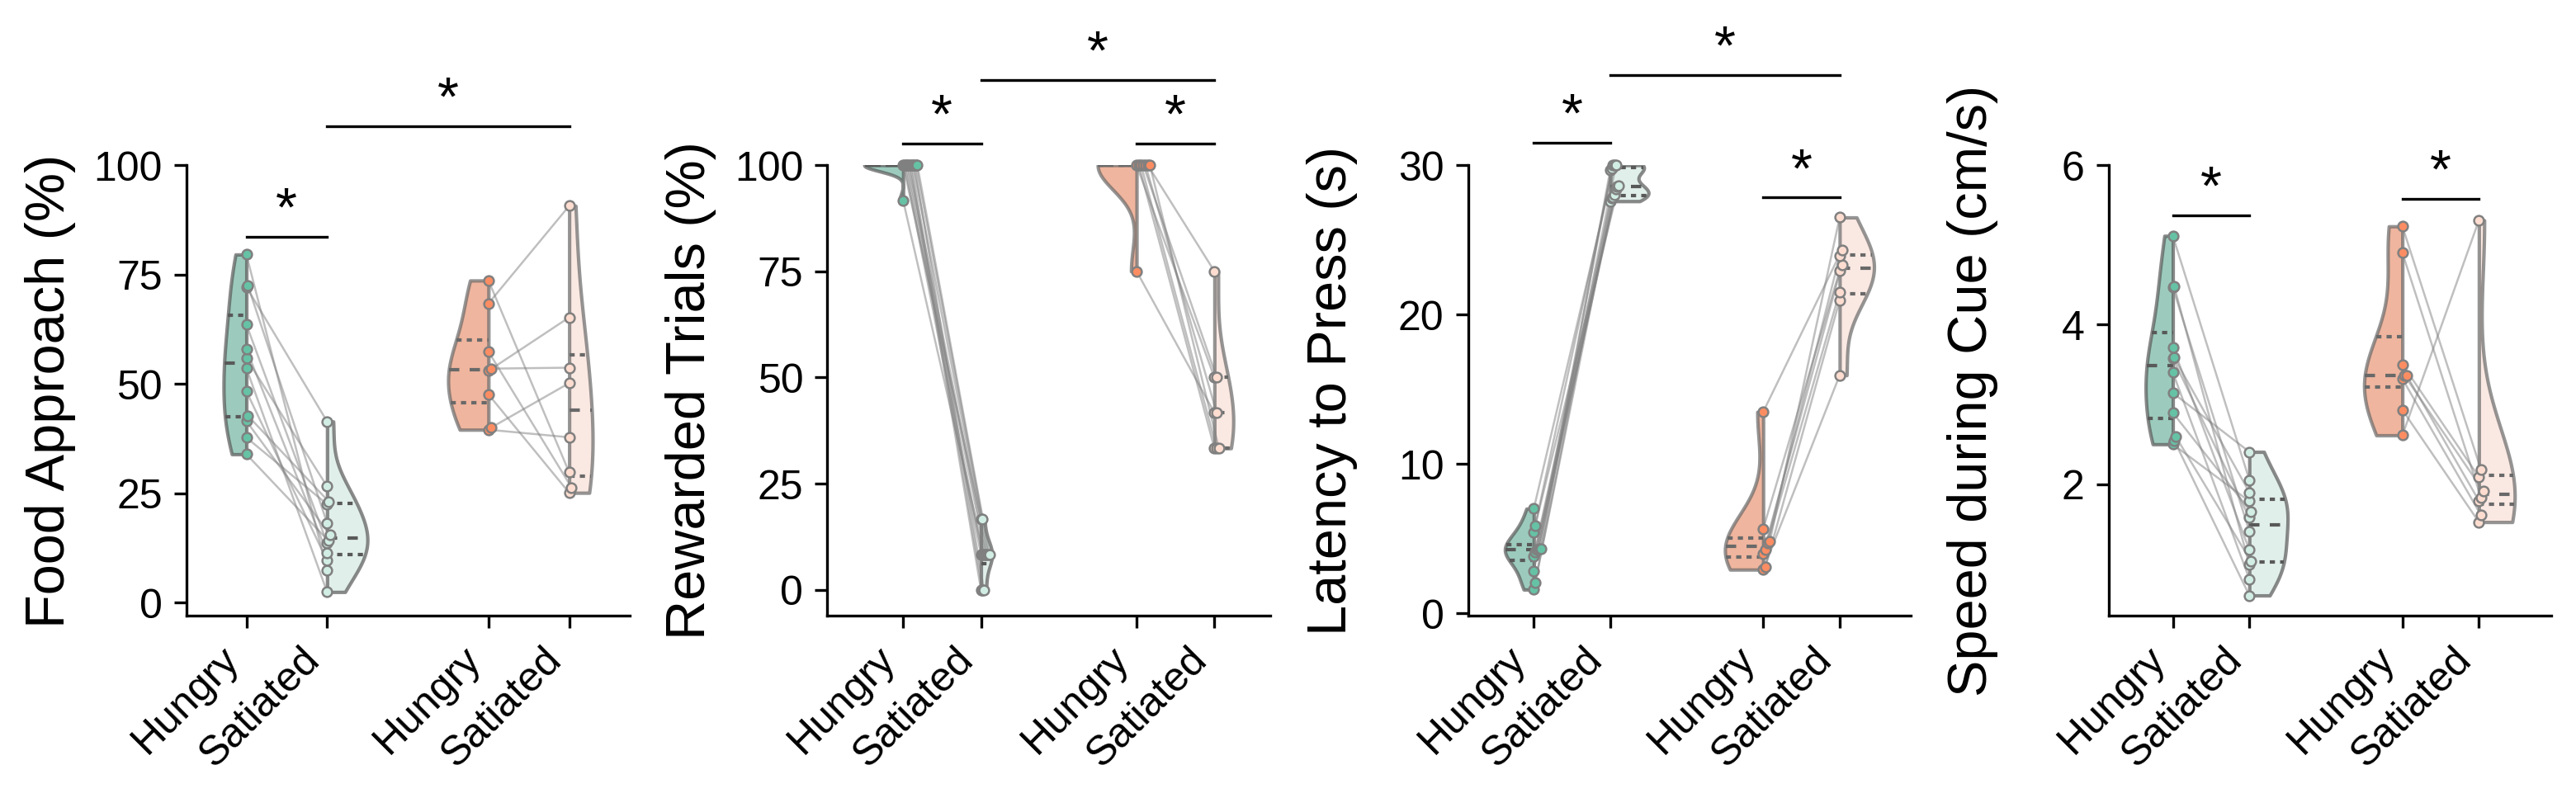

In [230]:
hungry_food_area = behavior_results_sex['hungry_food_area'].assign(Cluster=cluster_data_kmeans.Cluster.values)
satiated_food_area = behavior_results_sex['satiated_food_area'].assign(Cluster=cluster_data_kmeans.Cluster.values)

hungry_freezing = behavior_results_sex['hungry_freezing'].assign(Cluster=cluster_data_kmeans.Cluster.values)
satiated_freezing = behavior_results_sex['satiated_freezing'].assign(Cluster=cluster_data_kmeans.Cluster.values)

hungry_rewarded = behavior_results_sex['hungry_rewarded'].assign(Cluster=cluster_data_kmeans.Cluster.values).copy()
satiated_rewarded = behavior_results_sex['satiated_rewarded'].assign(Cluster=cluster_data_kmeans.Cluster.values).copy()
hungry_rewarded['Data'] = pd.DataFrame(behavior_results_sex['hungry_rewarded'].iloc[:,1:-1].mean(axis =1)*100)
satiated_rewarded['Data'] = pd.DataFrame(behavior_results_sex['satiated_rewarded'].iloc[:,1:-1].mean(axis =1)*100)

hungry_latency = behavior_results_sex['hungry_latency'].assign(Cluster=cluster_data_kmeans.Cluster.values).copy()
satiated_latency  = behavior_results_sex['satiated_latency'].assign(Cluster=cluster_data_kmeans.Cluster.values).copy()
hungry_latency['Data'] = pd.DataFrame(behavior_results_sex['hungry_latency'].iloc[:,1:-1].mean(axis =1))

satiated_latency['Data'] = pd.DataFrame(behavior_results_sex['satiated_latency'].iloc[:,1:-1].mean(axis =1))
title_splitviolin = None
figsize = (10.5, 3.5)

hungry_speed = behavior_results_sex['hungry_speed_cue'].assign(Cluster=cluster_data_kmeans.Cluster.values).copy()
satiated_speed  = behavior_results_sex['satiated_speed_cue'].assign(Cluster=cluster_data_kmeans.Cluster.values).copy()
hungry_speed['Data'] = pd.DataFrame(behavior_results_sex['hungry_speed_cue'].iloc[:,1:-1].mean(axis =1))*100
satiated_speed['Data'] = pd.DataFrame(behavior_results_sex['satiated_speed_cue'].iloc[:,1:-1].mean(axis =1))*100



y_label_food = 'Food Approach (%)'
y_label_speed = 'Speed during Cue (cm/s)'
y_label_speed_1s = 'Speed 1s Post-Cue (cm/s)'
y_label_rewarded = 'Rewarded Trials (%)'
y_label_latency = 'Latency to Press (s)'
ylim_food = (None, 100)
ylim_hidden = (None, 100)
ylim_speed = (None, 6)
ylim_rewarded = (None, 100)
ylim_latency = (None, 30)

fig, axs = plt.subplots(1, 4, figsize=figsize, dpi=300)

split_violin_with_dots_lines_multicluster(axs[0], hungry_food_area, satiated_food_area, 'Hungry', 'Satiated',title_splitviolin, y_label_food, ylim_food, label = False)
split_violin_with_dots_lines_multicluster(axs[1], hungry_rewarded, satiated_rewarded, 'Hungry', 'Satiated',title_splitviolin, y_label_rewarded, ylim_rewarded, label = False)
split_violin_with_dots_lines_multicluster(axs[2], hungry_latency, satiated_latency, 'Hungry', 'Satiated',title_splitviolin, y_label_latency, ylim_latency, label = False)
split_violin_with_dots_lines_multicluster(axs[3], hungry_speed, satiated_speed, 'Hungry', 'Satiated',title_splitviolin, y_label_speed, ylim_speed, label = False)

plt.tight_layout()
plt.show()

In [140]:

hungry_latency['Data_scaled'] = hungry_latency['Data']*100/30
satiated_latency['Data_scaled'] = satiated_latency['Data']*100/30
hungry_speed['Data_scaled'] = hungry_speed['Data']*100/5.5
satiated_speed['Data_scaled'] = satiated_speed['Data']*100/5.5

In [179]:
import plotly.graph_objects as go
import plotly.offline as pyo
import plotly.io as pio

pio.renderers.default = 'notebook'
image_dir = './image'

hex_color = sns.color_palette('Set2', 2)[0]
rgb_color = np.array(to_rgb(hex_color))

# Convert to (0-255) RGB format and round the values
rgb_255_format = np.round(rgb_color * 255).astype(int)

modified_rgb = (0.7+ 0.3*rgb_color)
rgb_255_format_modified = np.round(modified_rgb * 255).astype(int)

categories = ['Food Approach','Rewarded Trials','Latency to Press',
              'Speed during Cue']

num_categories = len(categories)

full_hungry = [hungry_food_area[hungry_food_area.Cluster =='0'].Data.mean(),
               hungry_rewarded[hungry_rewarded.Cluster =='0'].Data.mean(),
               hungry_latency[hungry_latency.Cluster == '0'].Data_scaled.mean(),
               hungry_speed[hungry_speed.Cluster == '0'].Data_scaled.mean()]
full_satiated = [satiated_food_area[satiated_food_area.Cluster =='0'].Data.mean(),
               satiated_rewarded[satiated_rewarded.Cluster =='0'].Data.mean(),
               satiated_latency[satiated_latency.Cluster == '0'].Data_scaled.mean(),
               satiated_speed[satiated_speed.Cluster == '0'].Data_scaled.mean()]

fig = go.Figure(
    data=[
        go.Scatterpolar(r=full_hungry, theta=categories, fill='toself', name='Hungry', 
            line=dict(color=f'rgb({rgb_255_format[0]}, {rgb_255_format[1]}, {rgb_255_format[2]})'),  
            fillcolor= f'rgba({rgb_255_format[0]}, {rgb_255_format[1]}, {rgb_255_format[2]}, 0.7)'),
        go.Scatterpolar(r=full_satiated, theta=categories, fill='toself', name='Satiated',
            line=dict(color=f'rgb({rgb_255_format_modified[0]}, {rgb_255_format_modified[1]}, {rgb_255_format_modified[2]})'),  
            fillcolor= f'rgba({rgb_255_format_modified[0]}, {rgb_255_format_modified[1]}, {rgb_255_format_modified[2]}, 0.8)'),
    ],
    layout=go.Layout(
        font_family='Arial',
        font_color="black",
        title=go.layout.Title(text='Fully Suppressed', x=0.5, y = 1, font= dict(size=36), pad = dict(b=40, t = 10)),
        polar={'radialaxis': {'visible': True, 'showticklabels': False, 'showline': False, 'dtick': 20},
              'angularaxis': dict(tickfont=dict(size=26), showticklabels=False),
              'bgcolor': 'lightgrey'},
        showlegend=True,
        legend=dict(x=0.85, y=1.2, font=dict(size=26))
    )
)

fig.update_layout(
    paper_bgcolor='rgba(0,0,0,0)',
    plot_bgcolor='rgba(0,0,0,0)',
)


num_categories = len(categories)
angles_deg = np.linspace(0, 360, num_categories, endpoint=False)  # Evenly spaced angles in degrees
angles_rad = np.deg2rad(angles_deg)  # Convert angles to radians


# Assuming the plot is centered at (0.5, 0.5) in 'paper' coordinates
label_positions = [(0.5 + 0.35 * np.cos(angle), 0.5 + 0.6 * np.sin(angle)) for angle in angles_rad]

def calculate_label_angles(label_positions):
    angles = []
    for pos in label_positions:
        # Calculate the angle from the center (0.5, 0.5) to the label position
        angle = np.arctan2((pos[1] - 0.5), (pos[0] - 0.5))
        
        # Convert to degrees and offset by 90 degrees to make the text tangential
        angle_degrees = -np.degrees(angle) + 90
        
        # Ensure the angle is within the range [-180, 180]
        if angle_degrees < -180:
            angle_degrees += 360
        elif angle_degrees > 180:
            angle_degrees -= 360

        # Adjust the angle for labels on the bottom half of the circle
        if angle_degrees > 90 or angle_degrees < -90:
            # If label is on the bottom half, rotate additional 180 degrees to flip
            angle_degrees += 180
         
        angles.append(angle_degrees)
    
    return angles

adjusted_angles = calculate_label_angles(label_positions)

for i, label in enumerate(label_positions):
    # This part is a bit tricky; you need to adjust the position to match where your labels should be
    x,y = label_positions[i]

    
    fig.add_annotation(
        go.layout.Annotation(
            text=categories[i],
            x=x,
            y=y,
            xref="paper",
            yref="paper",
            showarrow=False,
            font=dict(size=30),
            textangle=adjusted_angles[i],
            xanchor="center",
            yanchor="middle"
        )
    )

pyo.plot(fig)
fig.show()

pio.write_image(fig, os.path.join(image_dir,'fully_supressed_satiation.svg'), scale=2, engine="kaleido")  # Adjust width, height, and scale as needed



In [178]:
hex_color = sns.color_palette('Set2', 2)[1]
rgb_color = np.array(to_rgb(hex_color))

# Convert to (0-255) RGB format and round the values
rgb_255_format = np.round(rgb_color * 255).astype(int)

modified_rgb = (0.7+ 0.3*rgb_color)
rgb_255_format_modified = np.round(modified_rgb * 255).astype(int)

categories = ['Food Approach','Rewarded Trials','Latency to Press',
              'Speed during Cue']
full_hungry = [hungry_food_area[hungry_food_area.Cluster =='1'].Data.mean(),
               hungry_rewarded[hungry_rewarded.Cluster =='1'].Data.mean(),
               hungry_latency[hungry_latency.Cluster == '1'].Data_scaled.mean(),
               hungry_speed[hungry_speed.Cluster == '1'].Data_scaled.mean()]
full_satiated = [satiated_food_area[satiated_food_area.Cluster =='1'].Data.mean(),
               satiated_rewarded[satiated_rewarded.Cluster =='1'].Data.mean(),
               satiated_latency[satiated_latency.Cluster == '1'].Data_scaled.mean(),
               satiated_speed[satiated_speed.Cluster == '1'].Data_scaled.mean()]

fig = go.Figure(
    data=[
        go.Scatterpolar(r=full_hungry, theta=categories, fill='toself', name='Hungry', 
            line=dict(color=f'rgb({rgb_255_format[0]}, {rgb_255_format[1]}, {rgb_255_format[2]})'),  
            fillcolor= f'rgba({rgb_255_format[0]}, {rgb_255_format[1]}, {rgb_255_format[2]}, 0.7)'),
        go.Scatterpolar(r=full_satiated, theta=categories, fill='toself', name='Satiated',
            line=dict(color=f'rgb({rgb_255_format_modified[0]}, {rgb_255_format_modified[1]}, {rgb_255_format_modified[2]})'),  
            fillcolor= f'rgba({rgb_255_format_modified[0]}, {rgb_255_format_modified[1]}, {rgb_255_format_modified[2]}, 0.8)'),
    ],
    layout=go.Layout(
        font_family='Arial',
        font_color="black",
        title=go.layout.Title(text='Persistent Feeders', x=0.5, y = 1,  font= dict(size=36), pad = dict(b=40, t = 10)),
        polar={'radialaxis': {'visible': True, 'showticklabels': False, 'showline': False, 'dtick': 20},
              'angularaxis': dict(tickfont=dict(size=26), showticklabels=False),
              'bgcolor': 'lightgrey'},
        showlegend=True,
        legend=dict(x=0.85, y=1.2, font=dict(size=26))
    )
)

fig.update_layout(
    paper_bgcolor='rgba(0,0,0,0)',
    plot_bgcolor='rgba(0,0,0,0)',
)
num_categories = len(categories)
angles_deg = np.linspace(0, 360, num_categories, endpoint=False)  # Evenly spaced angles in degrees
angles_rad = np.deg2rad(angles_deg)  # Convert angles to radians

# Assuming the plot is centered at (0.5, 0.5) in 'paper' coordinates
label_positions = [(0.5 + 0.35 * np.cos(angle), 0.5 + 0.6 * np.sin(angle)) for angle in angles_rad]

def calculate_label_angles(label_positions):
    angles = []
    for pos in label_positions:
        # Calculate the angle from the center (0.5, 0.5) to the label position
        angle = np.arctan2((pos[1] - 0.5), (pos[0] - 0.5))
        
        # Convert to degrees and offset by 90 degrees to make the text tangential
        angle_degrees = -np.degrees(angle) + 90
        
        # Ensure the angle is within the range [-180, 180]
        if angle_degrees < -180:
            angle_degrees += 360
        elif angle_degrees > 180:
            angle_degrees -= 360
        
        # Adjust the angle for labels on the bottom half of the circle
        if angle_degrees > 90 or angle_degrees < -90:
            # If label is on the bottom half, rotate additional 180 degrees to flip
            angle_degrees += 180
        
        angles.append(angle_degrees)
    
    return angles

adjusted_angles = calculate_label_angles(label_positions)

for i, label in enumerate(label_positions):
    # This part is a bit tricky; you need to adjust the position to match where your labels should be
    x,y = label_positions[i]

    
    fig.add_annotation(
        go.layout.Annotation(
            text=categories[i],
            x=x,
            y=y,
            xref="paper",
            yref="paper",
            showarrow=False,
            font=dict(size=30),
            textangle=adjusted_angles[i],
            xanchor="center",
            yanchor="middle"
        )
    )

pyo.plot(fig)
fig.show()

pio.write_image(fig, os.path.join(image_dir,'persistent_feeder_satiation.svg'), scale=2, engine="kaleido")  # Adjust width, height, and scale as needed


In [ ]:
full_satiated = [satiated_food_area[satiated_food_area.Cluster =='0'].Data.mean(),
               satiated_rewarded[satiated_rewarded.Cluster =='0'].Data.mean(),
               satiated_latency[satiated_latency.Cluster == '0'].Data.mean(),
               satiated_speed[satiated_speed.Cluster == '0'].Data.mean()]

In [ ]:
# Perform K-means clustering
kmeans = KMeans(n_clusters=3, random_state=0)
clusters = kmeans.fit_predict(data_scaled)
inertia = kmeans.inertia_
silhouette = silhouette_score(data_scaled, kmeans.labels_)

# Add the cluster labels to the original data
cluster_data_kmeans = cluster_data.copy()
cluster_data_kmeans['Cluster'] = clusters.astype('str')


In [ ]:
cluster_data_kmeans

In [ ]:
labels = kmeans.labels_
labels = ['Full Supression' if i == 0 else 'Partial Supression' for i in labels]

# PCA to reduce to 2 dimensions for visualization
pca = PCA(n_components=2)
principal_components = pca.fit_transform(data_scaled)

# Plot
plt.figure(figsize=(3, 3), dpi = 300)

centroids_pca = pca.transform(kmeans.cluster_centers_)

# Create a meshgrid for the Voronoi diagram
x_min, x_max = principal_components[:, 0].min() - 1, principal_components[:, 0].max() + 1
y_min, y_max = principal_components[:, 1].min() - 1, principal_components[:, 1].max() + 1
xx, yy = np.meshgrid(np.linspace(x_min, x_max, 300), np.linspace(y_min, y_max, 300))
Z = kmeans.predict(pca.inverse_transform(np.c_[xx.ravel(), yy.ravel()]))
Z = Z.reshape(xx.shape)

# Plot
plt.contourf(xx, yy, Z, alpha=0.2)
ax = sns.scatterplot(x=principal_components[:, 0], y=principal_components[:, 1], hue=labels)
# plt.title('PCA Cluster Visualization')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
legend = plt.legend(loc='upper center', bbox_to_anchor=(0.5, 1.15), fontsize= 6, frameon=False)
legend.get_frame().set_facecolor('none')

plt.show()

# # Heatmap for cluster centroids
# cluster_centers = kmeans.cluster_centers_
# sns.heatmap(cluster_centers, annot=True, cmap='coolwarm')
# plt.title('Cluster Centroids')
# plt.xlabel('Feature')
# plt.ylabel('Cluster')
# plt.show()

In [ ]:
def generate_symmetric_points(center, spread, n_points):
    if n_points == 1:
        return np.array([center])
    else:
        offsets = np.linspace(-spread, spread, n_points)
        return center + offsets

def group_values_with_indices(values, threshold):
    sorted_indices = np.argsort(values)
    sorted_values = values[sorted_indices]
    groups = [([sorted_values[0]], [sorted_indices[0]])]
    for i in range(1, len(values)):
        if abs(sorted_values[i] - groups[-1][0][-1]) <= threshold:
            groups[-1][0].append(sorted_values[i])
            groups[-1][1].append(sorted_indices[i])
        else:
            groups.append(([sorted_values[i]], [sorted_indices[i]]))
    return groups

def wilcoxon_sign_test(group_data, data1_name, data2_name,):
        safe_data = group_data[group_data['Condition'] == data1_name]['Data']
        threat_data = group_data[group_data['Condition'] == data2_name]['Data']

       
        stat, p_value = stats.wilcoxon(safe_data, threat_data)
        
        return stat, p_value
    
def paired_ttest(group_data, data1_name, data2_name,):
        safe_data = group_data[group_data['Condition'] == data1_name]['Data']
        threat_data = group_data[group_data['Condition'] == data2_name]['Data']
        
        # Data are normally distributed
        stat, p_value = stats.ttest_rel(safe_data, threat_data)
        
        return stat, p_value
    
def split_violin_with_dots_lines_multicluster(ax, data1, data2, data1_name, data2_name, title, y_label, ylim, label, point_size=8, line_width=0.6):
    # Combine data1 and data2 into a single DataFrame
    data1['Condition'] = data1_name
    data2['Condition'] = data2_name
    combined_data = pd.concat([data1[['animal_id','Data', 'Condition','Cluster']], data2[['animal_id','Data', 'Condition','Cluster']]])

    # Encode categorical variables
    combined_data['Cluster'] = pd.Categorical(combined_data['Cluster'])
    combined_data['Condition'] = pd.Categorical(combined_data['Condition'])

    # Perform 2-way RM ANOVA using MixedLM
    model = MixedLM.from_formula("Data ~ Cluster * Condition", combined_data, groups=combined_data["animal_id"], re_formula="~Condition")
    results = model.fit()
    print(results.summary())

    # The fixed effects are typically in the second table (index 1)
    fixed_effects_df = results.summary().tables[1]
    
    # Assuming the interaction term is in the third row (index 2) and the p-value is in the fourth column (index 3)
    interaction_p_value = float(fixed_effects_df.iloc[2, 3])
    print("Interaction: p-value =", interaction_p_value)

    # Number of clusters
    unique_clusters = combined_data['Cluster'].unique()
    
    # Normality test
    safe_data = combined_data[combined_data['Condition'] == data1_name]['Data']
    threat_data = combined_data[combined_data['Condition'] == data2_name]['Data']
    diff = safe_data - threat_data
    normality = stats.shapiro(diff)
    print(f"Normality test results: Statistics = {normality[0]}, p-value = {normality[1]}")

    p_values =[]
    statistics = []
    for i, cluster in enumerate(unique_clusters):
        cluster_dt = combined_data[combined_data['Cluster'] == cluster]
               
        if normality[1] < 0.05:
            stat, pvalue = wilcoxon_sign_test(cluster_dt, data1_name, data2_name)
            statistics.append(stat)
            p_values.append(pvalue)
        elif normality[1] >= 0.05:
            stat, pvalue = paired_ttest(cluster_dt, data1_name, data2_name)
            statistics.append(stat)
            p_values.append(pvalue)
    
    sidak_corrected = multipletests(p_values, method='sidak')

    # Print results
    for i, cluster in enumerate(unique_clusters):
        print(f"Cluster {i} comparison: Statistics = {statistics[i]}, original p-values = {p_values[i]},  Sidak corrected p-values = {sidak_corrected[1][i]}")
    
    # Prepare plot_data with positions for the violin plot
    plot_data = combined_data.copy()
    num_conditions = 2  # Number of conditions
    plot_positions = {}
    gap_index = 0  # To create a gap between clusters
    for i, cluster in enumerate(sorted(unique_clusters)):
        plot_positions[cluster] = [gap_index * num_conditions+gap_index, gap_index * num_conditions + 1+gap_index]
        gap_index += 1  # Increase index for the next cluster

        # Add dummy category for the gap
        for gap in range(gap_index - 1):
            dummy_data = pd.DataFrame({'PlotPos': [gap * (num_conditions+1)+2], 'Data': [None], 'Condition': [None], 'Cluster': [None]})
            plot_data = pd.concat([plot_data, dummy_data], ignore_index=True)

    plot_data['PlotPos'] = plot_data.apply(lambda row: plot_positions[row['Cluster']][0 if row['Condition'] == data1_name else 1] if pd.notna(row['Cluster']) else row['PlotPos'], axis=1)


    # Prepare colors for each cluster and condition
    base_colors = sns.color_palette('Set2', len(unique_clusters))
    condition_colors = {cluster: {data1_name: to_rgb(base_colors[i]), data2_name: 0.6 + 0.4 * np.array(to_rgb(base_colors[i]))} for i, cluster in enumerate(sorted(unique_clusters))}

    for cluster in sorted(unique_clusters):
        cls_data = plot_data[plot_data.Cluster == cluster]

        for i in set(plot_data.PlotPos) - set(cls_data.PlotPos):
            dummy_data = pd.DataFrame({'PlotPos': [i], 'Data': [None], 'Condition': [None], 'Cluster': [None]})
            cls_data = pd.concat([cls_data, dummy_data], ignore_index=True)
        sns.violinplot(x = 'PlotPos', y='Data', hue='Condition', 
               data=cls_data, 
               fill=False, split=True, width=1, palette=condition_colors[cluster], scale_hue=False,
               linewidth=1, inner='quart', cut=0, ax=ax, dodge = 'auto')


    ax.legend().remove()
    plt.setp(ax.collections, alpha=0.6)

    # Initialize a dictionary to store coordinates for connecting lines
    point_coords = {}
    
    # Calculate the diameter in points
    diameter_points = 2 * sqrt(point_size / pi)
    actual_ylim = ax.get_ylim()
    
    # Convert diameter to inches
    diameter_inches = diameter_points / 72

    # Get the height of the axes in inches
    bbox = ax.get_window_extent().transformed(fig.dpi_scale_trans.inverted())
    axes_height_inches = bbox.height

    # Get the conversion factor from inches to data units
    y_range = ylim[1] - actual_ylim[0]
    conversion_factor = y_range / axes_height_inches

    # Convert diameter from points to data units
    diameter_data_units = diameter_inches * conversion_factor
    
    # Spread scatter points for each cluster and store their coordinates
    offset = 0.1  # Adjust this value to change the spread of points
    for cluster in unique_clusters:
        for condition in [data1_name, data2_name]:
            condition_data = plot_data[(plot_data['Cluster'] == cluster) & (plot_data['Condition'] == condition)]
            grouped_values = group_values_with_indices(condition_data['Data'].values, diameter_data_units)
            condition_color = condition_colors[cluster][condition]

            for group, indices in grouped_values:
                x_positions = generate_symmetric_points(plot_positions[cluster][0 if condition == data1_name else 1], offset, len(condition_data))

                for i, idx in enumerate(indices):
                    animal_id = condition_data.iloc[idx].animal_id  # Correct index from group_data
                    x_coord = x_positions[i]
                    y_value = condition_data[condition_data.animal_id == animal_id].Data.values
                    if animal_id not in point_coords:
                        point_coords[animal_id] = {}
                        
                    # Store the coordinates for lines
                    point_coords[animal_id][condition] = (x_coord, y_value)

                    ax.scatter(x_coord, y_value, color=condition_color, edgecolors='gray', alpha=1, clip_on=False, s=point_size, lw=line_width, zorder=3)

 
    # Draw connecting lines based on stored coordinates
    for animal_id, coords in point_coords.items():
        if data1_name in coords and data2_name in coords:
            x_coords = [coords[data1_name][0], coords[data2_name][0]]
            y_coords = [coords[data1_name][1], coords[data2_name][1]]
            ax.plot(x_coords, y_coords, color='gray', alpha=0.5, linewidth=line_width)

    y_max = min(combined_data['Data'].max()*1.05, ylim[1]*1.05)
    for i, (cluster, p_value) in enumerate(zip(unique_clusters, sidak_corrected[1])):
        if p_value < 0.05:
            x_coords = plot_positions[cluster]
            ax.plot([x_coords[0], x_coords[0], x_coords[1], x_coords[1]], [y_max, y_max, y_max, y_max], lw=0.8, c='k', clip_on=False)
            # Add asterisk for significance
            ax.text((x_coords[0] + x_coords[1]) / 2, y_max, "*", ha='center', va='bottom', color='k', fontsize=16)

    if label:
        custom_legend = [mlines.Line2D([], [], color=condition_colors[cluster][data1_name], marker='o', linestyle='None', markersize=point_size, label='Cluster 0', mec = 'gray', markeredgewidth=line_width) for i, cluster in enumerate(sorted(unique_clusters))]
        ax.legend(custom_legend, ['Full Supression' if cluster == '0' else 'Partial Supression' for cluster in sorted(unique_clusters)], loc='upper right', frameon=False, markerscale = 1, fontsize = 12, bbox_to_anchor=(1.4, 1.1))

    # Customization and Annotations
    ax.set_xticks([pos for cluster in plot_positions for pos in plot_positions[cluster]])
    ax.set_xticklabels([f'{condition}' for cluster in combined_data['Cluster'].unique() for condition in [data1_name, data2_name]], rotation=45, ha='right')
    ax.set_title(title)
    ax.set_xlabel(None)
    ax.set_title(title, fontsize=6, pad = 25)
    ax.set_ylabel(y_label, fontsize=8)
    ax.set_ylim(*ylim)
    ax.tick_params(axis = 'x', labelsize=8)
    ax.tick_params(axis = 'y', labelsize=8)
    sns.despine() 
    ax.margins(x=0.1)
    
    return ax

In [ ]:
cluster_data_kmeans

In [ ]:
hungry_food_area = behavior_results_sex['hungry_food_area'].assign(Cluster=cluster_data_kmeans.Cluster.values)
satiated_food_area = behavior_results_sex['satiated_food_area'].assign(Cluster=cluster_data_kmeans.Cluster.values)

hungry_freezing = behavior_results_sex['hungry_freezing'].assign(Cluster=cluster_data_kmeans.Cluster.values)
satiated_freezing = behavior_results_sex['satiated_freezing'].assign(Cluster=cluster_data_kmeans.Cluster.values)

hungry_rewarded = behavior_results_sex['hungry_rewarded'].assign(Cluster=cluster_data_kmeans.Cluster.values).copy()
satiated_rewarded = behavior_results_sex['satiated_rewarded'].assign(Cluster=cluster_data_kmeans.Cluster.values).copy()
hungry_rewarded['Data'] = pd.DataFrame(behavior_results_sex['hungry_rewarded'].iloc[:,1:-1].mean(axis =1)*100)
satiated_rewarded['Data'] = pd.DataFrame(behavior_results_sex['satiated_rewarded'].iloc[:,1:-1].mean(axis =1)*100)

hungry_latency = behavior_results_sex['hungry_latency'].assign(Cluster=cluster_data_kmeans.Cluster.values).copy()
satiated_latency  = behavior_results_sex['satiated_latency'].assign(Cluster=cluster_data_kmeans.Cluster.values).copy()
hungry_latency['Data'] = pd.DataFrame(behavior_results_sex['hungry_latency'].iloc[:,1:-1].mean(axis =1))
satiated_latency['Data'] = pd.DataFrame(behavior_results_sex['satiated_latency'].iloc[:,1:-1].mean(axis =1))
title_splitviolin = None
figsize = (11.5, 3)

hungry_speed = behavior_results_sex['hungry_speed_cue'].assign(Cluster=cluster_data_kmeans.Cluster.values).copy()
satiated_speed  = behavior_results_sex['satiated_speed_cue'].assign(Cluster=cluster_data_kmeans.Cluster.values).copy()
hungry_speed['Data'] = pd.DataFrame(behavior_results_sex['hungry_speed_cue'].iloc[:,1:-1].mean(axis =1))
satiated_speed['Data'] = pd.DataFrame(behavior_results_sex['satiated_speed_cue'].iloc[:,1:-1].mean(axis =1))


y_label_food = 'Food Area Duration(%)'
y_label_speed = 'Speed during Cue (m/s)'
y_label_speed_1s = 'Speed 1s Post-Cue (m/s)'
y_label_rewarded = 'Rewarded Trials (%)'
y_label_latency = 'Latency to Press (s)'
ylim_food = (None, 100)
ylim_hidden = (None, 100)
ylim_speed = (None, 0.1)
ylim_rewarded = (None, 100)
ylim_latency = (None, 30)

fig, axs = plt.subplots(1, 4, figsize=figsize, dpi=300)

split_violin_with_dots_lines_multicluster(axs[0], hungry_food_area, satiated_food_area, 'Hungry', 'Satiated',title_splitviolin, y_label_food, ylim_food, label = False)
split_violin_with_dots_lines_multicluster(axs[1], hungry_rewarded, satiated_rewarded, 'Hungry', 'Satiated',title_splitviolin, y_label_rewarded, ylim_rewarded, label = False)
split_violin_with_dots_lines_multicluster(axs[2], hungry_latency, satiated_latency, 'Hungry', 'Satiated',title_splitviolin, y_label_latency, ylim_latency, label = False)
split_violin_with_dots_lines_multicluster(axs[3], hungry_speed, satiated_speed, 'Hungry', 'Satiated',title_splitviolin, y_label_speed, ylim_speed, label = True)

plt.tight_layout()
plt.show()